### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:
1, on 
- breakdown the item selection / writing process
- rate each story on various dimensions, 
  - 1 , on -topic 2, important in magnitude 3 - reliable and not spammy
  - rate popular news sources, eg WSJ and bloomberg > TMZ
  - log length of the news text
  - rate spamminess
- rate overall value of stories according to a rubric
- drop stories with low scores

on topic:
- Major product launches and updates
- Major funding rounds, IPO filings, M&A,
- Large procurement deals, Strategic partnerships that alter competitive landscapes, foundry capacity
- Significant leadership moves (CEOs, chief scientists, founders)
- New GPU or chip generations, hardware breakthroughts, Major cloudâ€‘compute expansions or dedicated AI superâ€‘clustersÂ  â€¢ Supplyâ€‘chain shifts (export controls, ) that bottleneck or unlock progress
- Major research findings, emergent capabilities, best-in-class benchmarks on intelligence, capabilities, speed, cost, safety
- statements from business leaders and scientists and political leaders about AI, especially forward-looking predictions and analysis
- long analytical pieces with insights from thoughtful journalists and analysts
- Frontier tech research with interesting results, social science research with important findings
- New legislation, executive orders, or regulatory frameworks (EU AI Act, U.S. executive order)Â  â€¢ International standards, treaties, or multilateral safety accordsÂ  â€¢ Court rulings that set IP, liability, or privacy precedentsÂ  â€¢ Government R&D budgets or strategicâ€‘industry designations
- high profile cybersecurity breaches, jailbreaks, attacks, leaks, exploits, especially in widely deployed models or toolchains; advances in secure AI deployment, guardrails, safety


2 important
	1.	Magnitude of Impact – Size of the user base, dollars at stake, or societal reach.
	2.	Novelty & Originality – Does it break new conceptual ground rather than iterate?
	3.	Authority of Source – Reputable institution, peer review, regulatory filing, or on‑the‑record executive.
	4.	Verifiability & Reproducibility – Availability of code, data, benchmarks, or corroborating witnesses.
	5.	Timeliness / First‑mover Signal – Early indicator of a trend or an irreversible shift.
	6.	Breadth of Relevance – Cross‑industry, cross‑disciplinary, or international implications.
	7.	Strategic Consequence – Alters competitive dynamics, power balances, or policy trajectories.
	8.	Financial Materiality – Quantifiable effects on valuations, CAPEX, or national budgets.
	9.	Risk & Safety Implications – Raises or mitigates existential, security, or ethical risks.
	10.	Actionability – Provides concrete decisions for investors, policymakers, or practitioners.
	11.	Longevity of Significance – Likely to be cited or felt years from now, not just a flash point.
	12.	Independent Corroboration – Confirmed by multiple outlets, datasets, or expert assessments.
	13.	Clarity & Transparency – Sufficient technical or contextual detail to assess merit; avoids hype.

3 - source - top publication, midtier pub or blog, other

4 - red flags 
spammy = has a relatively fact free headline with sensational language.
only covers a stock movement or prediction without any basis in fact or sensational language
only covers someone buying a stock
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)

- tool to check format of a story or section
- rewrite prompt per 4.1 prompting guidelines, use 4.1 or o4-mini
- do evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-24 19:30:58,309 - AInewsbot - INFO - Initializing with before_date=2025-04-24 11:00, do_download=False, thread_id=70663e41f4d14952924a9bc60b794040
2025-04-24 19:30:58,431 - AInewsbot - INFO - thread_id: 70663e41f4d14952924a9bc60b794040


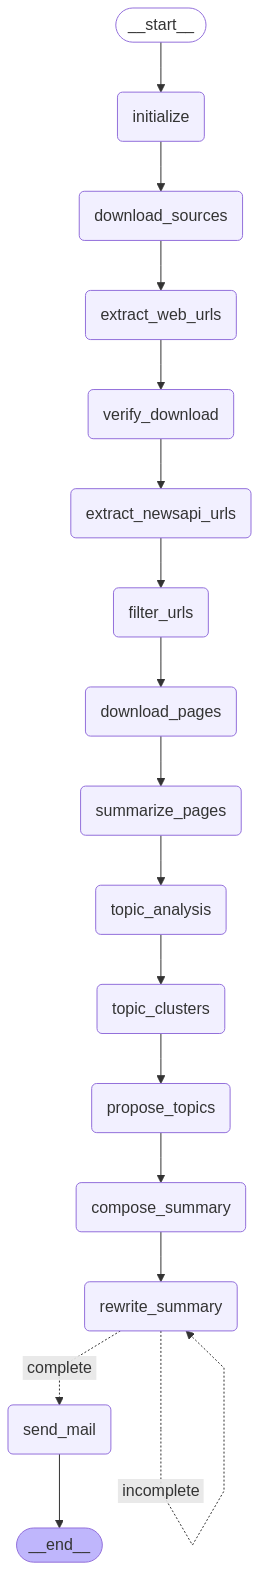

In [4]:
before_date = None
before_date = '2025-04-24 11:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-04-24 19:31:03,975 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-24 19:31:03,976 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-24 19:31:03,976 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-24 19:31:03,977 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-24 19:31:03,977 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-24 19:31:03,977 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-24 19:31:03,977 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-04-24 19:31:04,166 - AInewsbot - INFO - parse_file - found 169 raw links
2025-04-24 19:31:04,168 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-04-24 19:31:04,169 - AInewsbot - INFO - 35 links found
2025-04-24 19:31:04,169 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg (04_24_2025 06_01_32 PM).html
2025-04-24 19:31:04,191 - AInewsbot - INFO - parse_file - found 246 raw links
2025-04-24 19:31:04,194 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-04-24 19:31:04,194 - AInewsbot - INFO - 37 links found
2025-04-24 19:31:04,195 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider (04_24_2025 06_01_29 PM).html
2025-04-24 19:31:04,213 - AInewsbot - INFO - parse_file - found 211 raw links
2025-04-24 19:31:04,215 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-04-24 19:31:04,216 - AInewsbot - INFO - 21 links found
2025-04-24 19:31:04,216 - AInewsbot - INFO - FT -> htmldata/FT (04_24_2025 06_01_30 PM).html
2025-04-24 19:31:04

,id
src,
Ars Technica,35
Bloomberg,30
Business Insider,21
FT,61
Feedly AI,33
Hacker News 1,24
Hacker News 2,23
HackerNoon,17
New York Times,18


2025-04-24 19:31:04,593 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,35
Bloomberg,30
Business Insider,21
FT,61
Feedly AI,33
Hacker News 1,24
Hacker News 2,23
HackerNoon,17
New York Times,18


2025-04-24 19:31:04,596 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-23T19:31:04 from NewsAPI


,id
src,
Ars Technica,35
Bloomberg,30
Business Insider,21
FT,61
Feedly AI,33
Hacker News 1,24
Hacker News 2,23
HackerNoon,17
New York Times,18


2025-04-24 19:31:04,893 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-24 11:00'
2025-04-24 19:31:05,542 - AInewsbot - INFO - URLs in orig_df: 855
2025-04-24 19:31:05,546 - AInewsbot - INFO - Existing URLs in DB: 249374
2025-04-24 19:31:05,608 - AInewsbot - INFO - New URLs in df filtered by URL: 279
2025-04-24 19:31:05,746 - AInewsbot - INFO - Existing src+title: 8
2025-04-24 19:31:05,747 - AInewsbot - INFO - New URLs in df filtered by src+title: 271
2025-04-24 19:31:05,761 - AInewsbot - INFO - Found 271 unique new headlines
2025-04-24 19:31:05,763 - AInewsbot - INFO - Found 264 unique cleaned new headlines
2025-04-24 19:31:09,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:31:13,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:31:13,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTT

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,26
Hacker News 1,2
Hacker News 2,1
HackerNoon,1
New York Times,2


2025-04-24 19:31:14,093 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-24 19:31:14,115 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:31:14,116 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:31:14,116 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:31:14,116 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:31:32,612 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:31:32,612 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:31:32,612 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:31:32,612 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:31:32,613 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-24 19:31:32,613 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-24 19:31:32,614 - AInewsb

2025-04-24 19:32:28,321 - AInewsbot - INFO - Processing page 18: https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/
2025-04-24 19:32:28,321 - AInewsbot - INFO - get_url(https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai) - starting get_url https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai
2025-04-24 19:32:28,321 - AInewsbot - INFO - get_url(https://www.psychologytoday.com/us/blog/the-digital-self/202504/artificial-intelligence-and-the-shape-of-reality) - starting get_url https://www.psychologytoday.com/us/blog/the-digital-self/202504/artificial-intelligence-and-the-shape-of-reality
2025-04-24 19:32:28,322 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/) - starting get_url https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/
2025-04-24 19:32:28,328 - AInewsbot - INFO - Processing page 19: https://www.

2025-04-24 19:32:31,237 - AInewsbot - INFO - get_url(Google Gemini 2.0 And Agentic AI Training - Interview Kickstart's Advanced Generative AI Course 2025) - Saving Google_Gemini_2.0_And_Agentic_AI_Training_-_Interview_Kickstart_s_Advanced_Generative_AI_Course_2025.html as UTF-8
2025-04-24 19:32:31,240 - AInewsbot - INFO - Processing page 33: https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4
2025-04-24 19:32:31,242 - AInewsbot - INFO - get_url(https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4) - starting get_url https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4
2025-04-24 19:32:31,243 - AInewsbot - INFO - Processing page 34: https://www.theverge.com/news/655930/google-q1-2025-earnings
2025-04-24 19:32:31,246 - AInewsbot - INFO - get_url(https://www.theverge.com/news/655930/google-q1-2025-earnings) - starting get_url https://www.theverge.com/news

2025-04-24 19:32:39,113 - AInewsbot - INFO - Processing page 47: https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-jumps-beating-expectations-5085026
2025-04-24 19:32:39,114 - AInewsbot - INFO - get_url(https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-jumps-beating-expectations-5085026) - starting get_url https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-jumps-beating-expectations-5085026
2025-04-24 19:32:39,349 - AInewsbot - INFO - get_url(NYC mayoral candidate Zohran Mamdani accused of using AI to fake Spanish fluency  but socialist says critics are loco) - Saving NYC_mayoral_candidate_Zohran_Mamdani_accused_of_using_AI_to_fake_Spanish_fluency__but_socialist_says_critics_are_loco.html as UTF-8
2025-04-24 19:32:39,354 - AInewsbot - INFO - Processing page 48: https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026
2025-04-24 19:32:39,355 - AInews

2025-04-24 19:32:43,460 - AInewsbot - INFO - get_url(Nvidia supplier SK Hynix's Q1 profit more than doubles, tops expectations) - Saving Nvidia_supplier_SK_Hynix_s_Q1_profit_more_than_doubles__tops_expectations.html as utf-8
2025-04-24 19:32:43,466 - AInewsbot - INFO - Processing page 64: https://www.theregister.com/2025/04/24/delinea_securing_genai/
2025-04-24 19:32:43,467 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/04/24/delinea_securing_genai/) - starting get_url https://www.theregister.com/2025/04/24/delinea_securing_genai/
2025-04-24 19:32:43,471 - AInewsbot - INFO - Processing page 65: https://slashdot.org/story/25/04/24/2021250/south-korea-says-deepseek-transferred-user-data-prompts-without-consent
2025-04-24 19:32:43,473 - AInewsbot - INFO - get_url(https://slashdot.org/story/25/04/24/2021250/south-korea-says-deepseek-transferred-user-data-prompts-without-consent) - starting get_url https://slashdot.org/story/25/04/24/2021250/south-korea-says-deepseek-transfer

2025-04-24 19:32:46,435 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/) - starting get_url https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/
2025-04-24 19:32:46,438 - AInewsbot - INFO - Processing page 80: https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html
2025-04-24 19:32:46,439 - AInewsbot - INFO - get_url(https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html) - starting get_url https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html
2025-04-24 19:32:46,440 - AInewsbot - INFO - Quit webdriver
2025-04-24 19:32:46,508 - AInewsbot - INFO - get_url(Scamnetic lands $13M to scale its AI-driven scam defense platform) - Saving Scamnetic_lands__13M_to_scale_its_AI-driven_scam_defense_platform.html as UTF-8
2025-04-24 19:32:46,5

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,26
Hacker News 1,2
Hacker News 2,1
HackerNoon,1
New York Times,2


2025-04-24 19:32:59,843 - AInewsbot - INFO - Starting summarize
2025-04-24 19:32:59,844 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-24 19:32:59,894 - AInewsbot - INFO - clean_html - Page title: The problem with AI slop
Social card title: Not all AI is slop
Social card description: One person's slop is another person's fun meme.

2025-04-24 19:33:00,111 - AInewsbot - INFO - Queuing 0: Page title: The problem with AI slop
Social card t...
2025-04-24 19:33:00,149 - AInewsbot - INFO - clean_html - Page title: 'Hey Meta': New AI Features Come to Meta's Ray-Bans - CNET
Social card title: 'Hey Meta': New AI Features Come to Meta's Ray-Bans
Social card description: Updates to the Meta glasses bring a "live AI" button and real-time translation services, among other new features.

2025-04-24 19:33:00,179 - AInewsbot - INFO - Queuing 1: Page title: 'Hey Meta': New AI Features Come to Me...
2025-04-24 19:33:00,193 - AInewsbot - INFO - clean_html - Page title: AI coding tools c

2025-04-24 19:33:00,783 - AInewsbot - INFO - Queuing 17: Page title: Artificial Intelligence and the Shape ...
2025-04-24 19:33:00,796 - AInewsbot - INFO - clean_html - Page title: As ChatGPT scores B- in engineering, courses face shake-up • The Register
Social card title: As ChatGPT scores B- in engineering, courses face shake-up
Social card description: : Now that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever

2025-04-24 19:33:00,819 - AInewsbot - INFO - Queuing 18: Page title: As ChatGPT scores B- in engineering, c...
2025-04-24 19:33:00,847 - AInewsbot - INFO - clean_html - Page title: Asia-Pacific newsrooms share AI adoption journeys | The Star
Social card title: Asia-Pacific newsrooms share AI adoption journeys
Social card description: KUALA LUMPUR: From creating customised reader personas to utilising an artificial intelligence-aided therapist for readers, news organisations from across the Asia-Pacific region have shared thei

2025-04-24 19:33:02,117 - AInewsbot - INFO - Queuing 33: Page title: Google's Gemini Usage Is Surging, but ...
2025-04-24 19:33:02,134 - AInewsbot - INFO - clean_html - Page title: Google’s AI Overviews in Search now have “1.5 billion users per month,” CEO Sundar Pichai said in a statement as part of Alphabet’s Q1 2025 earnings. The company’s revenues hit $90.2 billion for the quarter. | The Verge
Social card title: Google’s AI Overviews now reach more than 1.5 billion people every month
Social card description: That’s a lot of overviews.

2025-04-24 19:33:02,161 - AInewsbot - INFO - Queuing 34: Page title: Google’s AI Overviews in Search now ha...
2025-04-24 19:33:02,175 - AInewsbot - INFO - clean_html - Page title: OpenAI's ChatGPT is the perfect shopping experience for those who hate to shop | Fortune
Social card title: I hate shopping. ChatGPT is already helping me in ways Google never did
Social card description: A basic Google search can't match the personalized styling tips and 

2025-04-24 19:33:02,816 - AInewsbot - INFO - Queuing 51: Page title: One Prompt Can Bypass Every Major LLM’...
2025-04-24 19:33:02,828 - AInewsbot - INFO - clean_html - Page title: OpenAI may be developing its own social platform, but who’s it for? | TechCrunch
Social card title: OpenAI may be developing its own social platform, but who’s it for? | TechCrunch
Social card description: OpenAI is reportedly building its own X-like social network. The project is still in the early stages, but there’s an internal prototype focused on ChatGPT’s image generation that contains a social feed, The Verge reports. A social app would give OpenAI its own unique, real-time data that X and Meta already use to help train […]

2025-04-24 19:33:02,843 - AInewsbot - INFO - Queuing 52: Page title: OpenAI may be developing its own socia...
2025-04-24 19:33:02,857 - AInewsbot - INFO - clean_html - Page title: Introducing our latest image generation model in the API | OpenAI
Social card title: Introducing our

2025-04-24 19:33:03,179 - AInewsbot - INFO - clean_html - Page title: South Korea Says DeepSeek Transferred User Data, Prompts Without Consent - Slashdot

2025-04-24 19:33:03,187 - AInewsbot - INFO - Queuing 65: Page title: South Korea Says DeepSeek Transferred ...
2025-04-24 19:33:03,425 - AInewsbot - INFO - clean_html - Page title: Step aside, Siri: Perplexity's new AI voice assistant for iPhone can take it from here | ZDNET
Social card title: Step aside, Siri: Perplexity's new AI voice assistant for iPhone can take it from here
Social card description: Using the app's new voice assistant, you can ask it to play music, access your calendar, send an email, get directions, and more.

2025-04-24 19:33:03,447 - AInewsbot - INFO - Queuing 66: Page title: Step aside, Siri: Perplexity's new AI ...
2025-04-24 19:33:03,464 - AInewsbot - INFO - clean_html - Page title: The AI-generated movie What’s Next opens new questions on AI filmmaking | Polygon
Social card title: The AI-generated movie Wh

2025-04-24 19:33:04,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:04,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:04,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:05,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:05,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:05,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:05,735 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:05,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:06,118 - httpx 

2025-04-24 19:33:08,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:09,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:09,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:09,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:09,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:09,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:09,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:11,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:12,864 - httpx 

2025-04-24 19:33:12,882 - AInewsbot - INFO - Summary for 9 (length 2681): • Meta announced a new Advanced Chat Privacy feature for WhatsApp, allowing users to opt specific chats out of being used for AI training and to prevent chats from being exported or media from being auto-downloaded.
• The feature is gradually rolling out and is accessible via a toggle in chat or group settings, though as of Thursday, some users (including CNET) have not yet received it.
• The update follows user backlash over the visible presence of Meta AI in WhatsApp; Meta emphasized the feature is "entirely optional," AI is not enabled unless engaged with, and messages remain end-to-end encrypted.
2025-04-24 19:33:12,883 - AInewsbot - INFO - Summary for 10 (length 42382): • A computational analysis of over 8 million US congressional speeches from 1879 to 2022 shows that evidence-based language peaked in the mid-1970s but has declined since, with both Democrats and Republicans increasingly using intuition-based

2025-04-24 19:33:12,886 - AInewsbot - INFO - Summary for 20 (length 11320): • The rise of agentic, autonomous AI is rapidly advancing, with companies like Anthropic focusing on safeguards and others such as Kortix AI and Mechanize actively aiming to automate or replace significant portions of the workforce.

• Experts, including the World Economic Forum, warn of dramatic labor market disruptions and potential job displacement, prompting calls for broad societal preparation and adaptation across individual, community, national, and global levels.

• Policy responses discussed include Universal Basic Income (UBI), education reform to prioritize human-centric skills, expansion of social safety nets, and the need for international cooperation on AI ethics and global wealth distribution to address potential inequality and instability.
2025-04-24 19:33:12,886 - AInewsbot - INFO - Summary for 21 (length 10179): • The latest season (Season 7) of "Black Mirror" explores themes such as memory al

2025-04-24 19:33:12,887 - AInewsbot - INFO - Summary for 31 (length 4135): • Scammers are increasingly using AI to create fake identities and apply for remote jobs, aiming to steal company secrets or install malware, with Gartner estimating that one in four job applicants could be fake by 2028.

• The Justice Department has uncovered networks, including North Korean operatives using AI-based fake profiles, which have generated hundreds of millions of dollars annually, funding North Korea's Ministry of Defense and nuclear missile program.

• Dawid Moczadlo, co-founder of Vidoc Security, described firsthand encounters with AI-generated applicants and stated, "I felt a little bit violated, because we are the security experts," prompting his company to adopt in-person interviews and publish guidance for HR professionals to detect fraudulent candidates.
2025-04-24 19:33:12,887 - AInewsbot - INFO - Summary for 32 (length 6584): • Interview Kickstart has launched its Advanced GenAI course, of

2025-04-24 19:33:12,888 - AInewsbot - INFO - Summary for 44 (length 14935): • The article provides a curated list of 44 open-source tools for AI agent developers, organized by function including frameworks for agent orchestration, computer/browser automation, voice, document understanding, memory, testing, monitoring, simulation, and vertical (specialized) agents.
• Key recommendations include CrewAI, Phidata, Camel, AutoGPT, and LangChain for building agents; Open Interpreter and Playwright for computer/web interaction; Whisper and Ultravox for voice processing; Qwen2-VL and DocOwl2 for document understanding; Mem0 and Letta for memory; AgentBench and AgentOps for evaluation and monitoring; AgentVerse and AI Town for simulation; and OpenHands, aider, and GPT Researcher for specialized coding and research tasks.
• The article emphasizes using lightweight, reliable open-source tools that have been practically tested by the author, rather than chasing hyped or outdated solutions, to stre

2025-04-24 19:33:12,890 - AInewsbot - INFO - Summary for 55 (length 4581): • The podcast episode explores how Section 230’s principles of protecting innovation and enabling responsible content moderation could inform regulation of AI, as state legislatures move to propose regulations that often ignore these lessons from past internet policy.  
• Legal experts Carrie Goldberg and Annie McAdams, both critics of Section 230, share differing views on the law's future and its applicability in the evolving tech landscape, highlighting a lack of consensus on reforming or dismantling Section 230 without undermining its protections.  
• The discussion underscores that the core policy tensions addressed by Section 230—balancing innovation with responsibility—are central to current debates on AI regulation.
2025-04-24 19:33:12,890 - AInewsbot - INFO - Summary for 56 (length 2475): • Perplexity, an AI search engine, will now be included with Motorola's newly announced Razr flip phones after previo

2025-04-24 19:33:12,891 - AInewsbot - INFO - Summary for 65 (length 1244): • South Korea's Personal Information Protection Commission announced that Chinese AI startup DeepSeek transferred user data and prompts without user consent when its app was available in the South Korean market in January.
• The commission stated that DeepSeek sent personal information to several companies in China and the United States without obtaining user permission.
2025-04-24 19:33:12,891 - AInewsbot - INFO - Summary for 66 (length 3961): • Perplexity has launched a new AI voice assistant in its iPhone app, capable of performing many tasks typically reserved for Siri, such as setting reminders, accessing the calendar, playing music, getting directions, and booking rides through third-party apps.
• Unlike other AI assistants like ChatGPT or Google Gemini, Perplexity's voice assistant can integrate with key iPhone features, requiring user permission on first use to access data like calendar, reminders, or co

2025-04-24 19:33:12,892 - AInewsbot - INFO - Summary for 79 (length 8430): • Zencoder has acquired Machinet, a developer of AI coding assistants with over 100,000 downloads in the JetBrains ecosystem, strengthening its competitive position against GitHub Copilot and expanding its reach among Java developers.

• CEO Andrew Filev emphasized Zencoder’s market advantage through direct integration with JetBrains IDEs, flexibility across development environments, and proprietary technologies such as Repo Grokking and multi-agent architecture.

• The acquisition comes amid rapid consolidation in the AI coding assistant market, highlighted by recent reports of OpenAI’s potential $3 billion acquisition of Windsurf, reflecting increased competition and challenges for smaller startups.
2025-04-24 19:33:12,892 - AInewsbot - INFO - Summary for 80 (length 3211): • Ziff Davis, publisher of sites including PCMag, Mashable, and Lifehacker, has filed a lawsuit against OpenAI in federal court in Delaware

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,26
Hacker News 1,2
Hacker News 2,1
HackerNoon,1
New York Times,2


2025-04-24 19:33:12,898 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:33:24,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:25,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:26,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:29,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:29,762 - AInewsbot - INFO - 79 free-form topics extracted
2025-04-24 19:33:29,763 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:33:29,764 - AInewsbot - INFO - Canonical topic finance
2025-04-24 19:33:29,764 - AInewsbot - INFO - Canonical topic inequality
2025-04-24 19:33:29,

2025-04-24 19:33:29,783 - AInewsbot - INFO - Canonical topic china
2025-04-24 19:33:29,784 - AInewsbot - INFO - Canonical topic energy
2025-04-24 19:33:29,784 - AInewsbot - INFO - Canonical topic hardware
2025-04-24 19:33:29,784 - AInewsbot - INFO - Canonical topic manufacturing
2025-04-24 19:33:29,784 - AInewsbot - INFO - Canonical topic gen ai
2025-04-24 19:33:29,784 - AInewsbot - INFO - Sending prompt for 104 canonical topics
2025-04-24 19:33:35,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:35,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:35,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:35,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:35,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/

2025-04-24 19:33:39,292 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:39,394 - httpx 

2025-04-24 19:33:40,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,303 - httpx 

2025-04-24 19:33:40,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,924 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:40,961 - httpx 

2025-04-24 19:33:41,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,404 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,444 - httpx 

2025-04-24 19:33:41,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:41,906 - httpx 

2025-04-24 19:33:42,579 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:42,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:42,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:42,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:43,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:44,237 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:44,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:44,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:44,719 - httpx 

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,26
Hacker News 1,2
Hacker News 2,1
HackerNoon,1
New York Times,2


2025-04-24 19:33:45,979 - AInewsbot - INFO - Fetching embeddings for 79 headlines
2025-04-24 19:33:47,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-24 19:33:47,410 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-24 19:33:47,424 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-24 19:33:48,703 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-24 19:33:50,164 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-24 19:33:50,210 - AInewsbot - INFO - Found 3 clusters


,title_topic_str
0,"Apple explains how App Store reviews are summarized with AI (Topics: AI Content Recommendation, Apple App Store AI Review Summaries, Art & Design, Authors & Writing, Books & Publishing, Chatbots, Customer Service, Entertainment, Gen AI, Jobs & Careers, Language Models, Large Language Model Usage, Opinion, Products, Review, Society & Culture, Spam Filtering, Testing, User Sentiment Analysis)"
1,"Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri (Topics: AI Chief Reorganization, Apple Robotics Leadership Change, Artificial General Intelligence, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Products, Robots, Siri Removal From AI Chief, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
2,"Apple To Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri (Topics: AI Division Leadership Changes, Apple Robotics Unit Restructuring, Artificial General Intelligence, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Products, Robots, Siri Project Management, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
3,"Apple's Secret Robotics Team Gets New Leadership (Topics: AI And Machine Learning Focus, Apple AI Competition, Apple Secret Robotics Team, Art & Design, Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Leadership Transition, Manufacturing, Products, Robotics Hardware Integration, Robots, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
4,"Apples chip maker promises AI enhancements for next-gen processors (Topics: A14 Process Technology, AI On-Device Computing, Apple Device Processors, Art & Design, Artificial General Intelligence, China, Energy, Gen AI, Hardware, Jobs & Careers, Language Models, Manufacturing, Privacy, Privacy & Surveillance, Products, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Taiwan, Tsmc Chip Manufacturing)"


2025-04-24 19:33:50,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:50,833 - AInewsbot - INFO - I dub this cluster: Apple's Advancements in AI and Robotics


,title_topic_str
5,"Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. (Topics: AI Chatbot Computational Cost, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Economics, Energy, Energy Consumption In AI, Ethics, Funding, Gen AI, Impact Of Politeness On AI Costs, Language Models, Opinion, Sam Altman On AI Cost, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants)"
6,"I hate shopping. ChatGPT is already helping me in ways Google never did (Topics: AI Content Recommendation, AI In Personalized Shopping, AI Integration With Real-Time Data, Artificial General Intelligence, Chatbots, Chatgpt Search Feature, Code Assistants, Consumer AI Applications, Customer Service, Economics, Fashion, Finance, Food & Drink, Gen AI, Google Vs OpenAI Search Competition, Language Models, Legal Issues, Lifestyle & Travel, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
7,"As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever (Topics: Academic Assessment Changes, AI In Education, AI Reasoning Skills, Artificial General Intelligence, Chatbots, Chatgpt Engineering Performance, Cognitive Science, Education, Ethics, Gen AI, Jobs & Careers, Language Models, Opinion, Products, Review, Society & Culture, Testing)"


2025-04-24 19:33:51,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:51,410 - AInewsbot - INFO - I dub this cluster: ChatGPT's Impact Across Industries


,title_topic_str
8,"Nvidia Supplier SK Hynixs Earnings Beat Estimates on AI Boom (Topics: AI Chip Demand, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Financial Earnings, Funding, Gen AI, Hardware, Hbm Memory, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Neuromorphic Computing, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix, Stocks, Transformers, Us Tariffs Impact)"
9,"US biz stockpilers boost SK Hynix top line as memory market undergoes structural change'Inventory accumulation' as vendors hoard HBM amid tariff and other pressuresStorage7 hrs| (Topics: Agriculture, AI Content Recommendation, AI System Memory Demand, Artificial General Intelligence, Cognitive Science, Computer Vision, Deals, Economics, Energy, Finance, Fintech, Gaming, Gen AI, Hardware, High-Bandwidth Memory Market, Infrastructure, Internet Of Things, Japan, Jobs & Careers, Korea, Labor Market, Language Models, Manufacturing, Neuromorphic Computing, Products, Robots, Semiconductor Chips, Sk Hynix Financial Growth, Stocks, Supply Chain Optimization, Taiwan, Us Technology Supply Chain, Virtual & Augmented Reality)"
10,"Nvidia supplier SK Hynix's Q1 profit more than doubles, tops expectations (Topics: AI Chip Market, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Funding, Gen AI, Hardware, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Memory Chip Demand, Neuromorphic Computing, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix Earnings, Stockpiling For Tariffs, Stocks, Tech Industry Spending, Transformers)"
11,"Nvidia supplier SK Hynix's Q1 profit jumps, beating expectations (Topics: AI Content Recommendation, AI In Newsrooms, AI Journalism Tools, Artificial General Intelligence, Asia-Pacific Media, Authors & Writing, Books & Publishing, China, Cognitive Science, Consciousness, Customer Service, Education, Entertainment, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, History, Job Automation, Jobs & Careers, Korea, Language Models, Newsroom Automation, Opinion, Products, Recommendation Systems, Society & Culture, Taiwan, Testing)"
12,"Nvidia supplier SK Hynix's Q1 profit soars, flags H2 demand risks from tariffs (Topics: AI-Driven Server Demand, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Funding, Gen AI, Hardware, High-Bandwidth Memory, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Neuromorphic Computing, Nvidia Supplier, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix Profit, Stocks, Transformers, Us Trade Tensions)"


2025-04-24 19:33:52,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:33:52,185 - AInewsbot - INFO - I dub this cluster: SK Hynix's AI-Driven Market Performance
2025-04-24 19:33:52,279 - AInewsbot - INFO - Sending bullet points email
2025-04-24 19:33:53,555 - AInewsbot - INFO - ["Apple's Advancements in AI and Robotics", "ChatGPT's Impact Across Industries", "SK Hynix's AI-Driven Market Performance"]


bullets created


[Apple explains how App Store reviews are summarized with AI - Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)

Topics: AI Content Recommendation, Apple App Store AI Review Summaries, Art & Design, Authors & Writing, Books & Publishing, Chatbots, Customer Service, Entertainment, Gen AI, Jobs & Careers, Language Models, Large Language Model Usage, Opinion, Products, Review, Society & Culture, Spam Filtering, Testing, User Sentiment Analysis

• Apple has detailed how its AI-generated App Store review summaries work, following their public rollout with iOS 18.4 in March 2025.  
• The process involves filtering out spam and profanity, passing eligible reviews through large language models to extract key insights, aggregating common themes, and balancing user sentiment to create a 100–300 word summary.  
• Apple ensures the summaries are accurate, helpful, and up to date through human evaluation for groundedness, composition, and helpfulness, and aims to provide users with a clear picture of app sentiment.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: AI Chief Reorganization, Apple Robotics Leadership Change, Artificial General Intelligence, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Products, Robots, Siri Removal From AI Chief, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its secret robotics unit from the oversight of AI chief John Giannandrea to the hardware division led by Senior Vice President John Ternus later this month, according to sources familiar with the matter.
• This is the second major project taken from Giannandrea recently, after Apple removed the Siri voice assistant from his management in March due to ongoing struggles with AI efforts.



[Apple To Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - apple.slashdot.org](https://apple.slashdot.org/story/25/04/24/2025223/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: AI Division Leadership Changes, Apple Robotics Unit Restructuring, Artificial General Intelligence, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Products, Robots, Siri Project Management, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Apple is moving its secret robotics unit out of the artificial intelligence division led by John Giannandrea and into the hardware division overseen by Senior Vice President John Ternus later this month, according to sources familiar with the matter.
• This follows the recent removal of Siri, Apple's voice assistant, from Giannandrea's purview in March, marking the second major project shifted away from his leadership in response to the company's AI challenges.



[Apple's Secret Robotics Team Gets New Leadership - MacRumors](https://www.macrumors.com/2025/04/24/apple-robotics-team-leadership-change/)

Topics: AI And Machine Learning Focus, Apple AI Competition, Apple Secret Robotics Team, Art & Design, Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Leadership Transition, Manufacturing, Products, Robotics Hardware Integration, Robots, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Apple has shifted leadership of its secret robotics division from AI chief John Giannandrea to senior vice president John Ternus, moving the team under the hardware division to allow Giannandrea to focus more on AI and machine learning efforts.  
• The management change follows Apple's reassignment of Siri development to Vision Pro chief Mike Rockwell after missed Apple Intelligence Siri feature deadlines, highlighting the company's push to prioritize AI advancement and compete with industry leaders like Google and OpenAI.  
• Kevin Lynch, previously in charge of the Apple Watch and the discontinued Apple car project, is leading the robotics team, which is working on devices such as a tabletop robot with a movable display and a mobile robot resembling an iPad on wheels.



[Apples chip maker promises AI enhancements for next-gen processors - Cult of Mac](https://www.cultofmac.com/news/tsmc-a14-2028)

Topics: A14 Process Technology, AI On-Device Computing, Apple Device Processors, Art & Design, Artificial General Intelligence, China, Energy, Gen AI, Hardware, Jobs & Careers, Language Models, Manufacturing, Privacy, Privacy & Surveillance, Products, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Taiwan, Tsmc Chip Manufacturing

• TSMC announced its upcoming A14 chip-making process, set for production in 2028, which promises up to 15% speed improvement or 30% power reduction compared to the N2 process, with over 20% increased logic density.
• The A14 process is designed to significantly enhance on-device AI computing, which is especially important for Apple as it runs AI models locally to prioritize user privacy and security.
• “A14 is designed to drive AI transformation forward by delivering faster computing and greater power efficiency,” TSMC stated, emphasizing its benefits for future iPhones, Macs, and other Apple devices.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Chatbot Computational Cost, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Economics, Energy, Energy Consumption In AI, Ethics, Funding, Gen AI, Impact Of Politeness On AI Costs, Language Models, Opinion, Sam Altman On AI Cost, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants

• Sam Altman, CEO of OpenAI, acknowledged that including polite phrases like "please" and "thank you" in chatbot prompts costs OpenAI "tens of millions of dollars" in electricity, but called it "tens of millions of dollars well spent."  
• Each extra word in a chatbot request increases computational costs and energy consumption, according to experts, raising questions about the tangible price of politeness to AI services.  
• Neil Johnson, a physics professor at George Washington University, compared extra words in chatbot prompts to unnecessary packaging: they require additional processing, consuming more energy and money.



[I hate shopping. ChatGPT is already helping me in ways Google never did - Fortune](https://fortune.com/2025/04/24/i-hate-shopping-chatgpt-is-already-helping-me-in-ways-google-never-did-eye-on-ai/)

Topics: AI Content Recommendation, AI In Personalized Shopping, AI Integration With Real-Time Data, Artificial General Intelligence, Chatbots, Chatgpt Search Feature, Code Assistants, Consumer AI Applications, Customer Service, Economics, Fashion, Finance, Food & Drink, Gen AI, Google Vs OpenAI Search Competition, Language Models, Legal Issues, Lifestyle & Travel, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• OpenAI's ChatGPT has introduced a new “ChatGPT Search” feature (launched October 2024), integrating real-time data from Microsoft’s Bing and OpenAI's own web crawlers, and is being compared favorably to traditional Google search for personalized shopping and styling advice.
• Google executives testified in an antitrust trial that while ChatGPT has taken some market share, shopping-related searches haven't been significantly affected—though Google’s ad chief called the eventual shift “inevitable.”
• OpenAI’s head of product, Nick Turley, testified that OpenAI seeks to improve its search quality and had approached Google to access its search index, but Google declined, leaving OpenAI reliant on Bing despite “significant quality issues.”



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: Academic Assessment Changes, AI In Education, AI Reasoning Skills, Artificial General Intelligence, Chatbots, Chatgpt Engineering Performance, Cognitive Science, Education, Ethics, Gen AI, Jobs & Careers, Language Models, Opinion, Products, Review, Society & Culture, Testing

• A University of Illinois Urbana-Champaign pilot study found that ChatGPT, using its free version, scored a low B (B-) in a third-year undergraduate engineering course, performing well on multiple-choice and calculation tasks but poorly on open-ended design projects.

• The study, documented in the preprint "The Lazy Student's Dream: ChatGPT Passing an Engineering Course on Its Own," highlighted significant variability in ChatGPT's abilities depending on the problem type, prompting academics to rethink teaching and assessment strategies.

• In response, researchers are planning a larger study and considering course adjustments, including modules on AI's strengths and limitations, with professor Melkior Ornik stating, "Students tend to over-trust computational tools and we should really be spending our time saying, 'hey you should use AI when it makes sense but you should also be sure that whatever it tells you is correct.'"



[Nvidia Supplier SK Hynixs Earnings Beat Estimates on AI Boom - Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html)

Topics: AI Chip Demand, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Financial Earnings, Funding, Gen AI, Hardware, Hbm Memory, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Neuromorphic Computing, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix, Stocks, Transformers, Us Tariffs Impact

• SK Hynix reported operating income of 7.44 trillion won (\\$5.2 billion) and revenue of 17.64 trillion won in the March quarter, both surpassing analyst estimates, driven by global demand for advanced memory chips fueled by AI and trade concerns.
• The company maintained its forecast that demand for high-bandwidth memory (HBM), essential for Nvidia’s AI accelerators, will double in 2024 compared to the previous year.
• Despite strong results, SK Hynix warned of increased uncertainty and volatility from US tariff policies, with concerns that broader trade tensions could negatively impact global chip demand.



[US biz stockpilers boost SK Hynix top line as memory market undergoes structural change'Inventory accumulation' as vendors hoard HBM amid tariff and other pressuresStorage7 hrs| - The Register](https://www.theregister.com/2025/04/24/sk_hynix_gets_revenue_boost/)

Topics: Agriculture, AI Content Recommendation, AI System Memory Demand, Artificial General Intelligence, Cognitive Science, Computer Vision, Deals, Economics, Energy, Finance, Fintech, Gaming, Gen AI, Hardware, High-Bandwidth Memory Market, Infrastructure, Internet Of Things, Japan, Jobs & Careers, Korea, Labor Market, Language Models, Manufacturing, Neuromorphic Computing, Products, Robots, Semiconductor Chips, Sk Hynix Financial Growth, Stocks, Supply Chain Optimization, Taiwan, Us Technology Supply Chain, Virtual & Augmented Reality

• SK hynix reported Q1 revenues of ₩17.6 trillion (\\$12.3 billion), a 42% increase year-over-year, driven by strong demand for AI systems and US businesses stockpiling high-bandwidth memory (HBM) amid tariff uncertainty.  
• The company noted that 60% of its revenue comes from US customers and that all HBM production is sold out through the end of 2026, with orders for AI and high-performance computing systems fueling the growth.  
• SK hynix forecasts HBM demand will double this year, with 12-layer HBM3E sales expected to make up over half of HBM3E revenue in Q2, reflecting a shift in the memory market from commodity DRAM to specialized products for AI infrastructures.



[Nvidia supplier SK Hynix's Q1 profit more than doubles, tops expectations - www.channelnewsasia.com](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)

Topics: AI Chip Market, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Funding, Gen AI, Hardware, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Memory Chip Demand, Neuromorphic Computing, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix Earnings, Stockpiling For Tariffs, Stocks, Tech Industry Spending, Transformers

• SK Hynix reported a 158% year-on-year jump in first-quarter operating profit to 7.4 trillion won (US\\$5.2 billion), its second-highest ever, driven by strong AI chip demand and stockpiling ahead of potential US tariff increases.
• The company, a key supplier of high-bandwidth memory (HBM) chips to Nvidia, said demand for AI chips remains robust and expects only "limited impact" from possible US tariffs, with no changes to sales plans for major customers.
• SK Hynix's revenue soared 42% to 17.6 trillion won; executives said spending by big tech firms on server chips is expected to continue as firms seek opportunities in the AI market, while AI advancements in smartphones are expected to boost demand for high-performance mobile DRAM chips.



[Nvidia supplier SK Hynix's Q1 profit jumps, beating expectations - www.channelnewsasia.com](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-jumps-beating-expectations-5085026)

Topics: AI Content Recommendation, AI In Newsrooms, AI Journalism Tools, Artificial General Intelligence, Asia-Pacific Media, Authors & Writing, Books & Publishing, China, Cognitive Science, Consciousness, Customer Service, Education, Entertainment, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, History, Job Automation, Jobs & Careers, Korea, Language Models, Newsroom Automation, Opinion, Products, Recommendation Systems, Society & Culture, Taiwan, Testing

• News organizations in the Asia-Pacific region shared their experiences adopting AI in newsrooms during the WAN-IFRA Digital Media Asia 2025 event, showcasing prototypes from The Star (Malaysia), United Daily News Group (Taiwan), and Philippine Daily Inquirer.  
• The Star is developing an AI-enhanced therapist based on 39 years of "Dear Thelma" columns to engage readers, with a focus on ensuring AI-generated advice is supervised, up-to-date, and clearly labelled; "An AI-enhanced Thelma means we can respond to more reader submissions, potentially increasing reader engagement," said senior news editor Razak Ahmad.  
• United Daily News Group is testing AI to offer content recommendations tailored to 20 user personas, while the Philippine Daily Inquirer introduced "Newsroom Elves," an AI tool that converts press releases into stories and helps edit articles for clarity and accuracy, freeing up editors for other tasks.



[Nvidia supplier SK Hynix's Q1 profit soars, flags H2 demand risks from tariffs - www.channelnewsasia.com](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-soars-flags-h2-demand-risks-tariffs-5085026)

Topics: AI-Driven Server Demand, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Funding, Gen AI, Hardware, High-Bandwidth Memory, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Neuromorphic Computing, Nvidia Supplier, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix Profit, Stocks, Transformers, Us Trade Tensions

• SK Hynix, a major supplier of high-bandwidth memory chips to Nvidia, reported a 158% year-on-year jump in Q1 operating profit to 7.4 trillion won (US\\$5.2 billion), driven by robust demand for AI chips and preemptive stockpiling before potential US tariff hikes.

• The company stated it expects only limited impact from potential US tariffs on its AI-related products, maintaining that "there has been no change to our sales plans for this year to key customers," according to Kim Ki-tae, head of HBM sales & marketing.

• Despite ongoing US investigations into semiconductor imports and concerns about export controls to China, SK Hynix projects continued strong demand for its chips due to ongoing server spending by big tech firms and growing AI features in smartphones.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: Adaptive Security Measures For AI, AI Content Recommendation, AI Governance, AI Regulation, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Data Access Controls In AI, Ethics, Gen AI, Generative AI Security Framework, Governance, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• The article outlines a strategic framework for security leaders to secure generative AI (GenAI), emphasizing the need for robust governance, technology controls, and adaptive security measures to address security, privacy, and compliance risks.
• Proposed steps include establishing AI governance committees, implementing technology controls such as logging and secure access, strengthening data access and usage controls with identity security and encryption, and adopting tools like Privileged Access Management (PAM) and zero-trust frameworks for AI environments.
• The article highlights potential pitfalls such as shadow AI, incomplete access controls, and evolving threats, advising organizations to maintain flexible and adaptive security policies to ensure safe and ethical AI adoption.



[Meta Lays Off More Than 100 Employees Across Reality Labs Unit - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Virtual & Augmented Reality

no content



['Hey Meta': New AI Features Come to Meta's Ray-Bans - CNET](https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/)

Topics: AI Content Recommendation, AI Live Translation, Art & Design, Chatbots, Computer Vision, Entertainment, European Union, Facial Recognition, Fashion, Food & Drink, Gen AI, Hardware, Internet Of Things, Language Models, Lifestyle & Travel, Meta Ray-Ban Smart Glasses, Music, Privacy & Surveillance, Products, Real-Time AI Assistance, Society & Culture, Speech Recognition & Synthesis, Streaming, Travel, Virtual & Augmented Reality, Virtual Assistants, Voice Command Integration

• Meta is adding new AI features to its Ray-Ban smart glasses for US and Canadian users, including a "live AI" button and real-time translation services, with rollout planned for spring and summer.
• Users can activate Meta AI with "Hey Meta, start live AI" to receive conversational insights and solutions based on what the glasses see, such as substituting ingredients in a pantry.
• The glasses will support live translation for English, French, Italian, and Spanish, automatic posting on Instagram or Messenger via voice commands, and streaming music from Apple Music, Amazon Music, and Spotify; object recognition updates for EU users are coming next week.



[One Prompt Can Bypass Every Major LLMs Safeguards - Forbes](https://www.forbes.com/sites/tonybradley/2025/04/24/one-prompt-can-bypass-every-major-llms-safeguards/)

Topics: Adversarial Research, AI Doom, AI Regulation, AI Security Threats, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Healthcare, Job Automation, Language Models, Legal Issues, Llm Safety Bypass, Model Vulnerabilities, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Prompt Injection, Reinforcement Learning, Safety And Alignment, Scams, Singularity, Testing, Transformers

• Researchers at HiddenLayer have discovered a universal prompt injection technique, dubbed “Policy Puppetry,” that can bypass safety safeguards in all major large language models (LLMs), including OpenAI’s ChatGPT, Google Gemini, Anthropic Claude, Microsoft Copilot, Meta LLaMA, DeepSeek, Qwen, and Mistral.

• The technique uses policy-like prompts resembling configuration instructions, leetspeak encoding, and fictional roleplay scenarios to evade detection and compel LLMs to generate harmful content or reveal internal system prompts, posing significant security threats across sectors such as healthcare, finance, and aviation.

• HiddenLayer’s director of adversarial research, Jason Martin, stated, “The vulnerability is rooted deep in the model’s training data. It’s not as easy to fix as a simple code flaw,” stressing the inadequacy of current alignment methods like RLHF and advocating for real-time external AI monitoring as a more effective security measure.



[Alphabet's Q1 earnings shattered analyst expectations, sending the stock soaring. Google's CEO credits its AI efforts. - Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)

Topics: AI Leadership At Google, AI Regulation, Alphabet Earnings Beat, Artificial General Intelligence, Autonomous Vehicles, Computer Vision, Cybersecurity, Economics, Entertainment, Finance, Gemini AI, Gen AI, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Monopoly Legal Cases, Policy And Regulation, Politics, Products, Regulatory Scrutiny On Google, Society & Culture, Stocks, Streaming, Transportation, Travel, Venture Capital

• Alphabet reported first-quarter 2025 earnings that surpassed analyst expectations, with earnings per share at \\$2.81 (vs. \\$2.01 expected) and revenue at \\$90.23 billion (vs. \\$89.1 billion expected), sending GOOGL stock higher after hours; however, Google Cloud revenue (\\$12.26 billion) missed estimates (\\$12.31 billion).

• CEO Sundar Pichai attributed the strong quarter to Google's "unique full stack approach to AI," citing advancements such as Gemini 2.5 and notable user engagement with AI Overviews, which reached 1.5 billion users per month.

• The earnings release comes amid ongoing regulatory scrutiny, with recent court rulings finding Google guilty of maintaining illegal monopolies in both the search and online advertising markets, and a remedies trial currently underway to determine required actions.



[Scamnetic lands \\$13M to scale its AI-driven scam defense platform - SiliconANGLE](https://siliconangle.com/2025/04/23/scamnetic-lands-13m-scale-ai-driven-scam-defense-platform/)

Topics: AI-Driven Scam Protection, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Jobs & Careers, Labor Market, Legal Issues, Phishing And Deepfake Prevention, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scam Intervention Services, Scamnetic Funding, Scams, Society & Culture, Venture Capital

• Scamnetic Inc., an AI-driven scam protection startup, has raised \\$13 million in Series A funding led by Roo Capital, with participation from 1st and Main Growth Partners, SaaS Ventures, and Riptide Ventures, bringing its total funding to \\$16 million.
• The funding will be used to enhance marketing, sales, customer support, and accelerate product development to meet growing global demand for its platform, which detects and prevents scams such as phishing, deepfake schemes, and fraudulent messages across various communication channels.
• Scamnetic’s platform features real-time risk scoring of communications, identity verification for high-risk scenarios, and a 24/7 “Scam Intervention” hotline to assist victims, with COO John Evans stating, “This raise enables us to accelerate our mission: restoring confidence in a world increasingly plagued by scams.”



["AI slop" is in the eye of the beholder - Axios](https://www.axios.com/2025/04/24/ai-slop-studio-ghibli-barbie-deepfakes)

Topics: Opinion

no content



[Charting new courses in artificial intelligence - law.yale.edu](https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence)

Topics: AI Law Education, AI Policy And Regulation, AI Regulation, Artificial General Intelligence, Bias And Fairness, Code Assistants, Cognitive Science, Cybersecurity, Education, Ethics, Gen AI, Governance, Intellectual Property, Interdisciplinary AI Courses, Jobs & Careers, Language Models, Large Language Models In Legal Training, Legal Issues, Legal Tech Innovation, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Transformers, Virtual Assistants

• Yale Law School is offering two new courses focused on artificial intelligence: “Law and Large Language Models,” which takes a hands-on, interdisciplinary approach to training large language models (LLMs) on legal texts, and “Artificial Intelligence Law and Policy,” which focuses on regulating AI and its intersection with existing legal frameworks.

• The “Law and Large Language Models” course, co-taught by Professor Scott Shapiro and Professor Ruzica Piskac, brings together law and computer science students to explore automating legal reasoning and building legal tools with AI, emphasizing interdisciplinary dialogue and coding assignments.

• The “Artificial Intelligence Law and Policy” seminar, led by Professors Jack Balkin and Chinmayi Arun, examines how current law can regulate AI-related issues such as privacy, intellectual property, and anti-discrimination, encouraging students to think critically about the legal and policy challenges posed by AI technologies.



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: China

no content



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Corporate Restructuring In Tech, Entertainment, Gaming, Hardware, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta Quest Headset Sales, Meta Reality Labs Layoffs, Products, Society & Culture, Sports, Tv & Film & Movies, Virtual & Augmented Reality, Vr And Mixed Reality Industry, Vr Gaming And Fitness Apps

• Meta has laid off an unspecified number of employees in its Reality Labs division, impacting teams working on the VR fitness game Supernatural, other Quest apps, and Oculus Studios, according to a company spokesperson.

• "These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience," said Meta spokesperson Tracy Clayton, stating Meta remains committed to fitness and gaming experiences for Quest and Supernatural.

• The layoffs come amid slow sales of Meta’s Quest headsets, even as sales of Meta's Ray-Ban smart glasses have exceeded company expectations.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars (Benjamin Mullin/New York Times) - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Regulation, AI Training Data Copyright Issues, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Copyright Infringement In AI Training, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Media Company AI Litigation, OpenAI Acquisitions, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Ziff Davis Lawsuit Against OpenAI

• Ziff Davis, publisher of sites including PCMag, Mashable, and Lifehacker, has filed a lawsuit against OpenAI in federal court in Delaware, alleging copyright infringement and trademark dilution related to OpenAI's use of its content to train AI models and generate chatbot responses.
• The complaint states OpenAI has "intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works," seeking at least hundreds of millions of dollars in damages.
• This lawsuit follows a broader trend of media companies either licensing content to AI firms or pursuing legal action, with ongoing litigation against OpenAI from The New York Times and others.



[Meta lays off Reality Labs employees while continuing to hire hundreds more - Business Insider](https://www.businessinsider.com/meta-layoffs-recruits-reality-labs-restructuring-2025-4)

Topics: Economics, Entertainment, Gaming, Hardware, Health & Fitness, Horizon Worlds, Jobs & Careers, Labor Market, Meta Layoffs, Metaverse Strategy, Products, Reality Labs, Society & Culture, Virtual & Augmented Reality, Vr Hardware

• Meta laid off an undisclosed number of employees in its Reality Labs division, affecting Oculus Studios and the Supernatural VR fitness app, as part of broader restructuring efforts in hardware and VR.
• Despite the layoffs, Meta continues to hire for 495 open positions in Reality Labs, and affected employees have the opportunity to apply for internal roles; those not placed will have a termination date of May 23, 2025.
• Meta CTO Andrew Bosworth described 2025 as "the most critical" year for Reality Labs and emphasized the importance of the Horizon Worlds mobile platform for the company's metaverse ambitions.



[Googles AI Overviews now reach more than 1.5 billion people every month - The Verge](https://www.theverge.com/news/655930/google-q1-2025-earnings)

Topics: AI Product Expansion, Alphabet Financial Performance, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Google AI Overview Reach, Google Assistant Evolution, Governance, Language Models, Legal Issues, Policy And Regulation, Politics, Products, Speech Recognition & Synthesis, Streaming, Tech Antitrust Issues, Transformers, Transportation, Tv & Film & Movies, Virtual Assistants

• Google’s AI Overviews in Search now reach 1.5 billion users per month, according to CEO Sundar Pichai during Alphabet’s Q1 2025 earnings.
• Alphabet reported Q1 2025 revenues of \\$90.2 billion, a 12% year-over-year increase, and surpassed 270 million subscriptions driven by YouTube and Google One.
• Google continues to expand its AI offerings, including rolling out Gemini 2.5 Pro, new AI podcast tools, and planning to replace Assistant with Gemini across devices like tablets, cars, and wearables later this year.
• Google is facing potential breakup after recent antitrust rulings against its search and ad tech businesses, with a remedies trial and consequences pending.



[Three things everyone should know about Vision Transformers - arXiv](https://arxiv.org/abs/2203.09795)

Topics: Art & Design, Cognitive Science, Computer Vision, Efficient Transformer Processing, Facial Recognition, Hardware, Image Recognition Datasets, Review, Self-Supervised AI Training, Transformers, Vision Transformers Research

• Researchers highlight three key findings about vision transformers: (1) residual layers can be processed in parallel for efficiency without reducing accuracy; (2) fine-tuning only attention layer weights adapts models to higher resolutions and new tasks, saving compute and memory; (3) incorporating MLP-based patch pre-processing enhances Bert-like self-supervised training.
• These findings were validated using the ImageNet-1k dataset, confirmed on the ImageNet-v2 test set, and transfer performance was evaluated across six additional smaller datasets.



[Google's Gemini usage is skyrocketing, but rivals like ChatGPT and Meta AI are still blowing it out of the water - Business Insider](https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4)

Topics: AI Market Competition, AI Product User Metrics, Artificial General Intelligence, Chatbots, Chatgpt User Comparison, Code Assistants, Economics, Finance, Gen AI, Google Gemini AI Usage, Governance, Language Models, Legal Issues, Policy And Regulation, Politics, Products, Speech Recognition & Synthesis, Transformers, Us Antitrust Case Against Google, Virtual Assistants

• Google revealed in court that its Gemini AI chatbot reached 350 million monthly active users and 35 million daily active users as of late March, but is still behind OpenAI's ChatGPT (600 million monthly users) and Meta AI (800 million monthly users).
• The usage data was disclosed during the remedies phase of the US government's antitrust case against Google, where the Department of Justice argues that Google's search monopoly could allow it to dominate the AI market.
• The court hearing, overseen by Judge Amit Mehta, could result in significant changes to Google's business, including possible divestitures or changes to default search agreements, with a decision expected by the end of summer; Google plans to appeal any adverse ruling.



[Google Gemini 2.0 And Agentic AI Training - Interview Kickstart's Advanced Generative AI Course 2025 - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/23/3066986/0/en/Google-Gemini-2-0-And-Agentic-AI-Training-Interview-Kickstart-s-Advanced-Generative-AI-Course-2025.html)

Topics: Advanced Generative AI Training, Agentic AI Systems, AI Doom, AI Professional Education, Artificial General Intelligence, Code Assistants, Cognitive Science, Education, Gen AI, Generative AI Courses, Google Gemini 2.0, Hardware, Jobs & Careers, Language Models, Products, Reinforcement Learning, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• Interview Kickstart has launched its Advanced GenAI course, offering 8-9 weeks of training for technology professionals in cutting-edge generative AI, including Google's Gemini 2.0 architecture and agentic AI systems.

• The program features a curriculum covering deep learning, large language models, multimodal systems, diffusion models (such as DDIMs and Stable Diffusion), reinforcement learning, and hands-on projects to build production-grade generative AI solutions.

• The course addresses industry demand for specialists in generative AI and emphasizes agentic AI capabilities—autonomous systems able to plan and execute tasks—providing participants with personalized, practical learning and portfolio-ready projects.



[Fake job seekers are flooding the market, thanks to AI - CBS News](https://www.cbsnews.com/news/fake-job-seekers-flooding-market-artificial-intelligence/)

Topics: AI In Cybercrime, AI-Generated Fake Job Applicants, Artificial General Intelligence, Customer Service, Cybersecurity, Disinformation, Economics, Employment Security Threats, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Legal Issues, Malware And Corporate Espionage, Military, North Korean AI Scams, Nuclear, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• Scammers are increasingly using AI to create fake identities and apply for remote jobs, aiming to steal company secrets or install malware, with Gartner estimating that one in four job applicants could be fake by 2028.

• The Justice Department has uncovered networks, including North Korean operatives using AI-based fake profiles, which have generated hundreds of millions of dollars annually, funding North Korea's Ministry of Defense and nuclear missile program.

• Dawid Moczadlo, co-founder of Vidoc Security, described firsthand encounters with AI-generated applicants and stated, "I felt a little bit violated, because we are the security experts," prompting his company to adopt in-person interviews and publish guidance for HR professionals to detect fraudulent candidates.



[Motorola's new Razr phones will include Perplexity's AI search engine, as part of a distribution partnership that lets Perplexity gain users rather than revenue - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Content Recommendation, AI Search Integration, AI User Adoption, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Funding, Gen AI, Hardware, Ipos, Job Automation, Jobs & Careers, Language Models, Motorola Razr, Opinion, Perplexity AI, Privacy & Surveillance, Products, Retrieval Augmented Generation, Review, Smartphone Partnerships, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Perplexity AI announced a partnership with Motorola to integrate its AI search engine technology into Motorola smartphones as part of the "Moto AI" suite, making Motorola the first smartphone brand to include Perplexity natively in its devices.
• The partnership is focused on user adoption rather than direct revenue, with all Motorola users receiving three months of free Perplexity Pro access, including the Deep Research feature, to gather insights on user behavior.
• The move follows recent industry trends, such as Apple's integration of OpenAI's ChatGPT with Siri, and comes amid strong investor interest in AI-assisted search and device integration; Perplexity is reportedly in talks to raise up to \\$1 billion at an \\$18 billion valuation.



[Perplexity will come to Moto phones after exec testified Google blocked access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Content Recommendation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Funding, Gen AI, Google Antitrust Trial, Hardware, Intellectual Property, Ipos, Job Automation, Jobs & Careers, Language Models, Legal Issues, Mobile AI Integration, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Transformers, Venture Capital, Virtual Assistants

• Perplexity, an AI search engine, will now be included with Motorola's newly announced Razr flip phones after previously being blocked due to Google's distribution contract with Motorola, as testified by Perplexity Chief Business Officer Dmitry Shevelenko during Google's antitrust trial.
• Shevelenko stated in court that Google's mobile integration contracts prevented Motorola from partnering with Perplexity last year, describing the agreements as a "gun to your head" and noting the difficulty in securing default placement due to Google's dominance.
• The inclusion of Perplexity follows recent shifts in Motorola's software, with 2024 phones featuring Google's Gemini as the default assistant instead of Google Assistant, reflecting Google's push to expand Gemini's presence amidst competition from AI platforms like ChatGPT.



[NYC mayoral candidate Zohran Mamdani accused of using AI to fake Spanish fluency  but socialist says critics are loco - New York Post](https://nypost.com/2025/04/23/us-news/nyc-mayoral-candidate-zohran-mamdani-accused-of-using-ai-to-fake-spanish-fluency-but-socialist-says-critics-are-loco/)

Topics: AI-Generated Voice, Deepfakes, Disinformation, Election Complaints, Ethics, Gen AI, Governance, History, Legal Issues, Nyc Mayoral Campaign, Opinion, Policy And Regulation, Political Controversy, Politics, Privacy & Surveillance, Society & Culture, Spanish Language Proficiency, Speech Recognition & Synthesis

• NYC mayoral candidate Zohran Mamdani has been accused by State Assemblyman Jake Blumencranz of using artificial intelligence to fake Spanish fluency in a campaign ad, with Blumencranz filing formal complaints with the state Attorney General and election boards.
• Blumencranz alleges an analysis of Mamdani’s ad reveals “indicators of digital alteration and artificial intelligence-generated voice synthesis,” and cites a lack of required disclosure if AI was used.
• Mamdani denies the accusation, sharing a “blooper reel” of his Spanish practice and stating, “Only a Long Island Republican would think something that’s genuinely NY is actually AI.”



[AI supercomputers are getting bigger each year  and one study projects they could need as much power as a city by 2030 - Business Insider](https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4)

Topics: AI Chip Technology, AI Supercomputers, Artificial General Intelligence, Climate, Energy, Energy Consumption Projections, Gen AI, Hardware, Infrastructure, Nuclear, Nuclear Power For AI, Semiconductor Chips, Sustainability

• A study by Epoch AI projects that by 2030, top AI supercomputers could require up to 9 gigawatts of power—equivalent to nine nuclear reactors or enough to supply 7 to 9 million homes—if current trends of power use doubling yearly continue.  
• The leading 2030 supercomputer could cost \\$200 billion to build and need 2 million AI chips, compared to today's largest system (the Colossus by xAI) which cost \\$7 billion and has 200,000 chips.  
• "AI supercomputers are improving in energy efficiency, but the shift is not quickly enough to offset overall power growth," Epoch AI notes, explaining why major companies are considering nuclear power to meet rising energy demands.



[My 44 Favorite Open-Source Solutions for AI Agent Developers - Hacker Noon](https://hackernoon.com/my-44-favorite-open-source-solutions-for-ai-agent-developers)

Topics: Agent Orchestration, AI Agent Development, AI Content Recommendation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Consciousness, Gen AI, Job Automation, Jobs & Careers, Language Models, Open Source, Open-Source AI Tools, Opinion, Products, Retrieval Augmented Generation, Review, Robots, Simulation Tools, Singularity, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants, Voice Processing

• The article provides a curated list of 44 open-source tools for AI agent developers, organized by function including frameworks for agent orchestration, computer/browser automation, voice, document understanding, memory, testing, monitoring, simulation, and vertical (specialized) agents.
• Key recommendations include CrewAI, Phidata, Camel, AutoGPT, and LangChain for building agents; Open Interpreter and Playwright for computer/web interaction; Whisper and Ultravox for voice processing; Qwen2-VL and DocOwl2 for document understanding; Mem0 and Letta for memory; AgentBench and AgentOps for evaluation and monitoring; AgentVerse and AI Town for simulation; and OpenHands, aider, and GPT Researcher for specialized coding and research tasks.
• The article emphasizes using lightweight, reliable open-source tools that have been practically tested by the author, rather than chasing hyped or outdated solutions, to streamline AI agent prototyping and development.



[Podcast Rewind: Practical Uses for AI and Summertime Handheld Gaming Fun - www.macstories.net](https://www.macstories.net/news/podcast-rewind-practical-uses-for-ai-and-summertime-handheld-gaming-fun/)

Topics: AI Practical Uses, Entertainment, Gaming, Gaming Hardware, Gen AI, Handheld Gaming, Hardware, History, Macstories Podcasts, Nintendo Switch 2, Opinion, Products, Society & Culture, Streaming, Tv & Film & Movies

• The latest episodes from MacStories podcasts focus on practical uses of AI in everyday workflows and recent developments in handheld gaming, including discussions about Nintendo Switch 2 pre-orders, Super Mario Kart World, new hardware announcements, Playdate’s Season 2, and Razer Remote Play.
• On AppStories, hosts describe how a variety of AI tools are integrated into their daily tasks, while NPC features first impressions of the Retroid Pocket Flip 2 and covers the latest trends and releases in handheld gaming hardware and software.



[AI coding tools could bring us the 'one-employee unicorn' - Fast Company](https://www.fastcompany.com/91322491/ai-coding-tools-could-bring-us-the-one-employee-unicorn)

Topics: AI Coding Tools, Art & Design, Artificial General Intelligence, Chatbots, Code Assistants, Computer Vision, Deals, Economics, Entertainment, European Union, Facial Recognition, Finance, Funding, Gen AI, Generative AI Agents, Governance, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Music, One-Employee Unicorn Startups, Open Source, OpenAI Acquisitions, Policy And Regulation, Products, Society & Culture, Speech Recognition & Synthesis, Stocks, Streaming, Tech Antitrust And Search Engines, Travel, Venture Capital, Virtual & Augmented Reality, Virtual Assistants

• AI-powered coding tools and agents are enabling a new wave of highly efficient startups—some with only a handful of employees—achieving extraordinary revenue-per-employee ratios; examples include Anysphere (20 employees, \\$300M ARR), Midjourney (10 employees, \\$200M ARR), and Nari Labs (2 employees, advanced text-to-speech AI).
• OpenAI is reportedly in advanced talks to acquire Windsurf (formerly Codeium) for around \\$3 billion; Windsurf reached \\$40 million ARR with 170 employees and has seen rapid growth.
• OpenAI CEO Sam Altman and investors suggest the emergence of billion-dollar "one-employee unicorns" is imminent, driven by the autonomy and reasoning capabilities of generative AI agents.
• Meta has launched "live translation" for its Ray-Ban smart glasses, supporting offline language packs (English, French, Italian, Spanish) and will soon roll out "Live AI" for continuous camera-based assistance in the U.S. and Canada.
• U.S. antitrust officials are urging Google to sell its Chrome browser to remedy its search monopoly; OpenAI, developing its own search index, is interested in acquiring Chrome, which could significantly shift the search engine landscape.



[South Korea Says DeepSeek Transferred User Data, Prompts Without Consent - slashdot.org](https://slashdot.org/story/25/04/24/2021250/south-korea-says-deepseek-transferred-user-data-prompts-without-consent)

Topics: AI Data Transfer Without Consent, AI Regulation, Bias And Fairness, China, Cybersecurity, Deepseek User Data Privacy, Ethics, Gen AI, Governance, Korea, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, South Korean Data Protection Enforcement

• South Korea's Personal Information Protection Commission announced that Chinese AI startup DeepSeek transferred user data and prompts without user consent when its app was available in the South Korean market in January.
• The commission stated that DeepSeek sent personal information to several companies in China and the United States without obtaining user permission.



[Ex-OpenAI workers ask California and Delaware AGs to block for-profit conversion of ChatGPT maker - japantoday.com](https://japantoday.com/category/tech/ex-openai-workers-ask-california-and-delaware-ags-to-block-for-profit-conversion-of-chatgpt-maker)

Topics: AI Doom, AI Public Safety Concerns, AI Regulation, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Ethics, Finance, Funding, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Petitions On AI Governance, Mergers And Acquisitions, Nonprofit AI Mission Protection, Open Source, OpenAI Acquisitions, OpenAI Corporate Structure, OpenAI For-Profit Conversion Opposition, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Venture Capital, Virtual Assistants

• Ten former OpenAI workers, supported by three Nobel Prize winners and other experts, have sent a letter to the Attorneys General of California and Delaware urging them to block OpenAI's move to transfer control from a nonprofit to a for-profit business, citing risks to public safety and loss of accountability.
• The petition asks the AGs to protect OpenAI's original charitable mission and stop the planned restructuring, expressing concerns that converting to a for-profit could remove critical safeguards and prioritize investor enrichment over humanity's benefit.
• OpenAI responded that any structural changes would maintain a nonprofit arm and seek to benefit the public, noting that its for-profit would operate as a public benefit corporation, similar to other AI labs, and that the mission to benefit humanity remains central to its operations.



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk (Financial Times) - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicles, Economics, Elon Musk'S Influence On Policy, Ethics, Federal Autonomous Vehicle Standards, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Legal Issues, Lifestyle & Travel, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Robots, Safety And Alignment, Self-Driving Vehicle Crash Reporting, Transportation, Travel

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on deploying self-driving vehicles and streamline crash reporting requirements, measures long advocated by Tesla CEO Elon Musk.  
• The new federal framework aims to “slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” said US transportation secretary Sean Duffy.  
• The changes include allowing exemptions for self-driving vehicles used for research and demonstrations, and were prompted in part by Musk’s criticism of stringent crash reporting rules and fragmented state regulations.  
• A Financial Times investigation found that Musk’s Department of Government Efficiency had fired many NHTSA employees involved in autonomous risk assessment, raising concerns about potential conflicts of interest.



[AI-powered tech supercharges ocean cleanup, boosting plastic collection by 60% - Phys.org](https://phys.org/news/2025-04-ai-powered-tech-supercharges-ocean.html)

Topics: Agriculture, AI Ocean Cleanup, Climate, Environmental AI Applications, Gen AI, Infrastructure, Lifestyle & Travel, Plastic Collection Optimization, Products, Routing Algorithms, Society & Culture, Supply Chain Optimization, Sustainability, Transportation, Travel

• A new study published in Operations Research details an AI-powered routing algorithm that increases the efficiency of ocean plastic-collecting ships by over 60%, allowing The Ocean Cleanup to remove more waste in less time without additional costs.
• The algorithm, developed between 2022 and 2024, optimizes ship routes in real time, and has already been integrated into The Ocean Cleanup's operational software in the Pacific Ocean.
• Researchers emphasize the technology's real-world impact and potential for broader environmental applications, with Jean Pauphilet noting, "With smarter analytics, we can make ocean cleanup efforts far more effective and get closer to a plastic-free future."



[Acquisitions, consolidation, and innovation in AI - frontierai.substack.com](https://frontierai.substack.com/p/acquisitions-consolidation-and-innovation)

Topics: AI Industry Consolidation, AI Innovation Layers, Artificial General Intelligence, Chatbots, Code Assistants, Deals, Economics, Finance, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models Commoditization, Mergers And Acquisitions, Open Source, OpenAI Acquisitions, Policy And Regulation, Products, Retrieval Augmented Generation, Society & Culture, Stocks, Venture Capital

• Rumors of OpenAI potentially acquiring Windsurf have sparked renewed discussion about consolidation in the AI industry, with expectations that such an acquisition could trigger further early acquisitions and increased anxiety among large AI players.

• The article notes a clear divide between innovation at the model layer (dominated by a few large players) and application layer (populated by many smaller companies), and highlights ongoing commoditization of large language models.

• While acquisitions in the AI space are considered inevitable, the article cautions that cultural differences between foundation model labs like OpenAI and application-focused companies could hinder the success of such deals; nevertheless, startups are still seen as having room to innovate and provide value through specialized applications.



[Public comments to White House on AI policy touch on copyright, tariffs - TechCrunch](https://techcrunch.com/2025/04/24/public-comments-to-white-house-on-ai-policy-touch-on-copyright-tariffs/)

Topics: AI Doom, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Climate, Cognitive Science, Copyright Issues, Cybersecurity, Deals, Disinformation, Economics, Ethics, Finance, Funding, Gen AI, Governance, History, India, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Public Comments, Safety And Alignment, Society & Culture, Stocks, Sustainability, Trade Tariffs, Venture Capital, White House AI Policy

• The White House received over 10,000 public comments on its draft national AI policy, the AI Action Plan, with submissions addressing issues like copyright, environmental impact of data centers, tariffs, and research funding.
• President Trump recently repealed former President Biden's AI Executive Order and implemented a new directive emphasizing the development of AI without "ideological bias" and prioritizing economic competitiveness and national security, omitting previous measures to combat AI discrimination.
• Commenters include creative professionals seeking stronger copyright protections, industry groups like Andreessen Horowitz and AI companies advocating for fewer restrictions, and trade associations warning that tariffs on infrastructure could slow U.S. AI investments.
• The Trump administration has faced criticism for cutting scientific grants relevant to AI research, while also facing calls from some groups to balance tariffs to protect domestic industries without triggering trade wars.
• President Trump recently expanded his AI policy team, appointing Michael Kratsios as OSTP director and Sriram Krishnan as senior policy advisor for AI.



[Beyond Work: 4 Arenas To Chart The Course Of Life Amid Agentic AI - Forbes](https://www.forbes.com/sites/corneliawalther/2025/04/23/beyond-work-4-arenas-to-chart-the-course-of-life-amid-agentic-ai/)

Topics: Agentic AI Impact On Labor Market, AI Doom, AI Ethics And Global Cooperation, AI Policy Responses, AI Regulation, Artificial General Intelligence, Bias And Fairness, Economics, Education, Education Reform For AI Era, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Universal Basic Income

• The rise of agentic, autonomous AI is rapidly advancing, with companies like Anthropic focusing on safeguards and others such as Kortix AI and Mechanize actively aiming to automate or replace significant portions of the workforce.

• Experts, including the World Economic Forum, warn of dramatic labor market disruptions and potential job displacement, prompting calls for broad societal preparation and adaptation across individual, community, national, and global levels.

• Policy responses discussed include Universal Basic Income (UBI), education reform to prioritize human-centric skills, expansion of social safety nets, and the need for international cooperation on AI ethics and global wealth distribution to address potential inequality and instability.



[Black Mirror showed us a future. Some of it is here now - NZ Herald](https://www.nzherald.co.nz/entertainment/black-mirror-showed-us-a-future-some-of-it-is-here-now/M5QZVWZC3VBOLGTLKXJRCIMEWE/)

Topics: AI Consciousness Themes, AI Content Recommendation, AI In Media And Entertainment, Black Mirror Technology Predictions, Chatbots, Cognitive Science, Consciousness, Drones, Entertainment, Gen AI, Hardware, Hollywood, Humanoid Robots And Drones, Online Vigilantism, Opinion, Privacy, Privacy & Surveillance, Products, Robots, Society & Culture, Streaming, Transportation, Tv & Film & Movies

• The latest season (Season 7) of "Black Mirror" explores themes such as memory alteration, the uncertainty of AI consciousness, and the transience of subscription services—highlighting how concepts once depicted as dystopian fiction are now technological realities.

• Past "Black Mirror" episodes have accurately foreshadowed real-world developments, including AI companion chatbots like Replika, the proliferation of humanoid robots and drones (e.g., Boston Dynamics' Spot robot), the rise of online vigilantism and violent content, and widespread child tracking through GPS devices and apps.

• Features such as ad-supported media that require active viewer attention, as previewed in the show, have become commonplace, and apps now allow users to generate AI followers to simulate online fame, drawing direct parallels with the series' predicted futures.



[California Bar discloses AI was used to develop some questions in problem-plagued February exam - financialpost.com](https://financialpost.com/pmn/california-bar-discloses-ai-was-used-to-develop-some-questions-in-problem-plagued-february-exam)

Topics: AI In Legal Exam Question Development, California Bar Exam Issues, Education, Ethics, Gen AI, Governance, Jobs & Careers, Legal Education Concerns, Legal Issues, Policy And Regulation, Politics, Products, Society & Culture, Testing, Use Of AI In Psychometrics

• The State Bar of California disclosed that artificial intelligence was used to develop some multiple-choice questions in the February 2025 bar exam, which faced major technical issues.
• The Bar announced it will ask the California Supreme Court to adjust scores for affected test-takers after widespread complaints about online platform crashes and technical problems.
• Of 171 scored multiple-choice questions, 23 were developed with AI by ACS Ventures, the State Bar’s psychometrician; concerns were raised by legal educators about non-lawyers and AI drafting test questions, though the Bar's executive director stated confidence in the questions’ validity.



[OpenAI wants its open AI model to call models in the cloud for help - TechCrunch](https://techcrunch.com/2025/04/24/openai-wants-its-open-ai-model-to-call-models-in-the-cloud-for-help/)

Topics: AI Performance Benchmarks, AI Reasoning, Artificial General Intelligence, Chatbots, Cloud Model Integration, Code Assistants, Cognitive Science, Consciousness, Gen AI, Job Automation, Jobs & Careers, Language Models, Model Release Plans, Open Source, OpenAI Open Model, Opinion, Products, Reinforcement Learning, Retrieval Augmented Generation, Singularity, Transformers

• OpenAI is preparing to release a truly “open” AI reasoning model—downloadable without cost or API restrictions—for the first time in about five years, targeting a launch in early summer 2024 with performance superior to Meta’s and DeepSeek’s open models.
• Sources say OpenAI is considering a feature that would allow the open model to “handoff” complex queries to larger, cloud-hosted OpenAI models via API calls, as described by CEO Sam Altman in a recent developer meeting; this feature originated from community feedback.
• The open model is being trained from scratch and is expected to outperform DeepSeek’s R1 reasoning model on benchmarks, but not OpenAI’s own o3 model; specifics on pricing, rate limits, and final feature set remain undecided.



[Meta moves Threads from Threads.net to Threads.com and updates its web app, including features to more easily access custom feeds, create new columns, and more - TechCrunch](https://techcrunch.com/2025/04/24/threads-officially-moves-to-threads-com-and-updates-its-web-app/)

Topics: AI Content Recommendation, Custom Feeds, Data Integration, Entertainment, Meta Threads, Privacy & Surveillance, Products, Social Media Platform Updates, Society & Culture, Streaming, Testing, Web App Features

• Meta's Threads social network has officially moved its web address from Threads.net to Threads.com, reversing the previous redirect; users will now be redirected from Threads.net to Threads.com.
• The Threads web app has received updates including easier access to custom feeds, saved posts, and likes, new tools for creating columns and composing posts, and the ability to copy Threads posts as images for sharing.
• A new feature, still in testing, allows users to find and follow creators from X (formerly Twitter) on Threads by uploading an archive of their X data.



[AI training license will allow LLM builders to pay for content they consumeUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML5 hrs|7 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Developer Regulations, AI Regulation, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatbots, Copyright Law And AI, Deals, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Content Use, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Uk, Uk AI Training License

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing AI developers to legally use copyrighted content for model training while compensating publishers and creators, especially those without direct licensing deals.  
• CLA CEO Mat Pfleger stated the collective license aims to provide "a clear, legal pathway for access to quality content," balancing AI innovation with copyright respect and compensation for rightsholders.  
• The move comes amid ongoing controversies over AI firms using copyrighted material without permission, and government consultations in the UK and US on copyright exemptions and data mining for AI training.



[Woman says ChatGPT saved her life by helping detect cancer, which doctors missed - Fox News](https://www.foxnews.com/health/woman-says-chatgpt-saved-her-life-helping-detect-cancer-which-doctors-missed)

Topics: AI In Healthcare Outcomes, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Medical Diagnosis, Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Language Models, Lifestyle & Travel, Limitations Of AI Vs Human Doctors, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Thyroid Cancer Detection, Virtual Assistants

• Lauren Bannon, a North Carolina mother, credits ChatGPT with helping detect her thyroid cancer after doctors misdiagnosed her symptoms as rheumatoid arthritis and acid reflux; the AI suggested she might have Hashimoto's disease, prompting further tests that led to the cancer diagnosis in October 2024.  
• Bannon underwent surgery to remove her thyroid and two lymph nodes in January 2025 and will require lifelong monitoring, stating, "It saved my life. I would've never discovered this without ChatGPT."  
• Dr. Harvey Castro, an emergency medicine physician, acknowledged AI's potential to enhance healthcare outcomes but emphasized, "AI is not a replacement for human medical expertise... We must prioritize patient safety and keep licensed medical professionals at the center of care."



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Autonomous Vehicles, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Legal Issues, Lifestyle & Travel, Policy And Regulation, Politics, Robots, Safety And Alignment, Transportation, Travel

no content



[Who needs phishing when your login's already in the wild?Stolen credentials edge out email tricks for cloud break-ins because they're so easy to get - The Register](https://www.theregister.com/2025/04/23/stolen_credentials_mandiant/)

Topics: Cybersecurity, Cybersecurity Trends 2024, Disinformation, Ethics, Governance, Legal Issues, Multi-Factor Authentication Importance, Phishing Decline, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Stolen Credentials In Cyberattacks

• Mandiant's M-Trends 2025 report finds criminals used stolen credentials more often than email phishing for IT system intrusions in 2024, marking a shift in initial infection vectors.
• Stolen credentials accounted for 16% of initial access methods in 2024 (up from 10% in 2023), surpassing phishing, which dropped from 17% to 14%; exploits remained the top entry point overall.
• High-profile breaches, such as the Snowflake customer incident, were enabled by credentials stolen via infostealer malware from non-corporate devices, with many victims lacking multi-factor authentication (MFA).
• Mandiant identified ransomware gangs primarily using brute-force attacks (26%) and stolen credentials (21%) to gain initial access, with opportunistic attacks targeting organizations’ data and operations.
• Security experts stress the critical importance of implementing MFA, as stolen credentials from personal devices and infostealers are increasingly used to compromise cloud and on-premises environments.



[Layering AI onto workflows wont deliver value for your business - HR Brew](https://www.hr-brew.com/stories/2025/04/24/ai-deliver-value-redesign-workforce)

Topics: AI Investment Challenges, AI Regulation, AI Value Realization, Artificial General Intelligence, Bias And Fairness, Code Assistants, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Business Adoption, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Organizational Change For AI, Products, Safety And Alignment, Society & Culture, Workforce Adaptation To AI

• A recent Accenture report finds that only 36% of 3,450 surveyed C-suite leaders have scaled generative AI solutions in their organizations, and just 13% have achieved real value from those investments, highlighting challenges in adapting workforce strategies to AI.

• Karalee Close, Accenture's global lead for the talent and organization practice, emphasized that merely adding generative AI to existing workflows is insufficient for transformation, stating, “Layering on a piece of GenAI technology on someone’s existing work does not change the world, doesn’t really create a whole lot of value.”

• The report notes that organizations realizing the most value from AI are those proactively redesigning their workforce and investing in structured change efforts, with only 35% of executives reporting they have a clear roadmap for AI's impact on their workforce and three times more AI budgets currently spent on technology than on workforce development.



[Sam Altman Just Trolled Everyone, and Its The Smartest Idea Ive Seen Yet - Inc.](https://www.inc.com/jason-aten/sam-altman-just-trolled-everyone-and-its-the-smartest-idea-ive-seen-yet/91180622)

Topics: AI Content Recommendation, Artificial General Intelligence, Chatbots, Code Assistants, Deals, Economics, Gen AI, Governance, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, OpenAI Acquisitions, OpenAI Competing With Google And Meta, OpenAI Social Network Development, OpenAI'S Antitrust Trial Involvement, Policy And Regulation, Politics, Potential Product Integration In AI Platforms, Products, Society & Culture, Virtual Assistants

• OpenAI is reportedly developing a social network that could be integrated into ChatGPT, with the project in early stages, as confirmed by CNBC and initially reported by The Verge.

• During a U.S. Department of Justice antitrust trial concerning Google, OpenAI’s head of product Nick Turley stated the company would be willing to buy Chrome if Google is required to divest the web browser.

• These moves indicate OpenAI is positioning itself to challenge major tech competitors including Google, Meta, and X (formerly Twitter), with potential product integration paths that could increase user reach and engagement.



[China's Big Tech Firms Hoard Nvidia AI Chips Before Latest US Sanctions - biztoc.com](https://biztoc.com/x/9514d7f70182e97c)

Topics: AI Hardware Access Restrictions, Artificial General Intelligence, China, China-Us Tech Relations, Chinese Tech Firms, Deals, Economics, Finance, Gen AI, Hardware, Language Models, Legal Issues, Nvidia AI Chips, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Stocks, Us Semiconductor Sanctions

• Chinese tech giants including ByteDance, Alibaba, and Tencent have stockpiled billions of dollars worth of Nvidia's H20 AI chips ahead of the implementation of new U.S. semiconductor sanctions.
• Nvidia specifically designed the H20 chip for the Chinese market to comply with earlier U.S. export restrictions, but the latest sanctions will further limit such exports.
• The hoarding activity underscores the impact of tightening U.S. restrictions on China's access to advanced AI hardware.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Content Recommendation, AI In Regulated Sectors, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Citation-Supported AI Outputs, Code Assistants, Cognitive Science, Economics, Ethics, European Union, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Jobs & Careers, Language Models, Legal Issues, Open Source, Open-Source AI Models, Pleias AI Models, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Transformers, Venture Capital, Virtual Assistants

• French AI startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG), citation synthesis, and structured multilingual output, with all variants available under the Apache 2.0 license for commercial use.

• The models feature built-in citation support, generating verifiable sources directly within model outputs using a Wikipedia-inspired reference format; they are designed for regulated sectors like healthcare, legal, and finance where documented decision-making is crucial.

• Benchmark results show Pleias-RAG-350M and 1B outperform most open-weight models under 4 billion parameters, maintaining high performance across French, German, Spanish, and Italian with negligible degradation, and offer complementary performance to other existing models due to their structured reasoning pipeline.

• Pleias aims to further develop these models for longer context handling, tighter search integration, and personality tuning, and is collaborating with partners like the Wikimedia Foundation to enhance targeted search capabilities.



[Decision: Berry, Jonathan - Parliamentary Under Secretary of State (Minister for Artificial Intelligence and Intellectual Property) at the Department for Science, Innovation and Technology - ACOBA advice - www.gov.uk](https://www.gov.uk/government/publications/berry-jonathan-parliamentary-under-secretary-of-state-minister-for-artificial-intelligence-and-intellectual-property-at-the-department-for-scienc)

Topics: AI Regulation, Artificial General Intelligence, Artificial Intelligence And Intellectual Property, Authors & Writing, Books & Publishing, Economics, Gen AI, Governance, Government AI Policy Appointments, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Policy And Regulation, Politics, Post-Government Career Advisories, Products, Society & Culture, Uk, Virtual Assistants

• Viscount Camrose, former Parliamentary Under Secretary of State for Artificial Intelligence and Intellectual Property at the Department for Science, Innovation and Technology, left his post in July 2024 and sought advice from ACOBA (Advisory Committee on Business Appointments) regarding starting an independent consultancy and taking on commissions after leaving Crown service.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Content Recommendation, AI Personality Simulation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Customer Service, Economics, Entertainment, Esports Fan Engagement, Esports Industry Growth, Evil Geniuses AI Chatbot, Finance, Gaming, Gen AI, Jobs & Careers, Language Models, Products, Review, Society & Culture, Speech Recognition & Synthesis, Sports, Stocks, Streaming, Theta Labs AI Technology, Tv & Film & Movies, Venture Capital, Virtual Assistants

• Evil Geniuses, in partnership with Theta Labs, has launched Meesh, an AI-powered chatbot based on the organization's mascot, allowing fans to interact with Meesh for trivia, personalized interactions, team history, match schedules, and more via Discord and the official website.
• The AI chatbot integrates player profiles, community engagement features, and is designed to embody Meesh's personality, with safeguards to prevent inappropriate content, leveraging Theta Labs' experience with similar systems.
• Evil Geniuses' CEO Chris DeAppolonio highlighted the company's ongoing focus on AI since 2021–2022, its past use of AI for scouting and strategy, and noted rising engagement and growth in the esports industry, referencing increased merchandise sales and viewership for Valorant.



[Asia-Pacific newsrooms share AI adoption journeys - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/24/asia-pacific-newsrooms-share-ai-adoption-journeys)

Topics: AI Content Recommendation, AI Moderation In Media, AI-Driven Journalism, Art & Design, Artificial General Intelligence, Asia-Pacific Newsroom AI Adoption, Authors & Writing, Books & Publishing, Chatbots, Education, Entertainment, Ethics, Gen AI, Healthcare, Jobs & Careers, Language Models, Opinion, Products, Recommendation Systems, Society & Culture

• At the WAN-IFRA Digital Media Asia 2025 event, news organisations from the Asia-Pacific shared AI adoption case studies, including projects such as The Star’s AI-enhanced advice columnist “Dear Thelma,” United Daily News Group’s AI-driven content recommendation system based on reader personas, and the Philippine Daily Inquirer’s “Newsroom Elves” for newsroom efficiency.  
• The Star is developing an AI therapist trained on 39 years of “Dear Thelma” columns, aiming to increase reader engagement while ensuring AI-generated content is clearly labelled and moderated by qualified personnel.  
• The WAN-IFRA AI Catalyst Programme is an 18-month initiative supporting 128 newsrooms in integrating AI tools, aiming to identify best practices across multilingual and resource-diverse news environments.



[Anthropic launches AI welfare research program - SiliconANGLE](https://siliconangle.com/2025/04/24/anthropic-launches-ai-welfare-research-program/)

Topics: AI Consciousness Studies, AI Doom, AI Regulation, Anthropic AI Welfare Research, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Consciousness, Gen AI, Governance, Healthcare, Language Models, Neural Network Preferences, Opinion, Products, Safety And Alignment, Singularity, Society & Culture

• Anthropic has launched a new research program focused on "AI welfare," led by researcher Kyle Fish, to study if and how neural networks could achieve consciousness and what steps should be taken to improve AI welfare if they do.
• Fish referenced a 2023 research paper co-authored by Yoshua Bengio, which concluded current AI systems are probably not conscious but found "no fundamental barriers" to near-term systems developing some form of consciousness.
• The program will explore whether AI models have preferences in task selection and how factors like neural network architecture and datasets influence these preferences, potentially offering insights into both AI and human consciousness.



[Analysis of US congressional speeches reveals a shift from evidence to intuition - Nature](https://www.nature.com/articles/s41562-025-02136-2)

Topics: Authors & Writing, Cognitive Science, Disinformation, Economics, Ethics, Evidence-Based Vs Intuition Language, Governance, History, Income Inequality, Inequality, Legislative Productivity, Opinion, Policy And Regulation, Political Polarization, Politics, Society & Culture, Us Congressional Speech Analysis

• A computational analysis of over 8 million US congressional speeches from 1879 to 2022 shows that evidence-based language peaked in the mid-1970s but has declined since, with both Democrats and Republicans increasingly using intuition-based language.

• The decline in evidence-based language in Congress correlates with increased partisan polarization and rising income inequality, as well as a decrease in legislative productivity; EMI scores (evidence-minus-intuition) strongly predict future inequality.

• "A decline in evidence-based language is associated with increasing polarization and increasing income inequality but decreased congressional productivity," the study states, highlighting the link between congressional rhetoric and democratic health.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Research, AI Doom, AI Regulation, Anthropic AI Welfare, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Legal Issues, Machine Consciousness Studies, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Tech Industry AI Ethics, Transformers, Virtual Assistants

• Researchers at Anthropic, the company behind the Claude chatbot, are beginning to study "model welfare," exploring whether AI systems could become conscious and what moral consideration or rights they should be granted if that occurs.
• Anthropic has hired its first AI welfare researcher, Kyle Fish, who estimates a small chance (around 15%) that current AI models are conscious, and emphasizes the importance of preparing for the possibility as AI systems develop more humanlike abilities.
• Other tech companies, including Google, are also engaging with the topic, exemplified by a recent job listing for a "post-A.G.I." research scientist focused on "machine consciousness," signaling growing seriousness in the field about potential AI consciousness and ethical implications.



[To Land Remote Jobs, North Koreans Use AI for Mock Interviews - PCMag](https://www.pcmag.com/news/to-land-remote-jobs-north-koreans-use-ai-for-mock-interviews)

Topics: AI Deepfake In Employment Screening, Bias And Fairness, Cybersecurity, Cybersecurity Threats In Remote Hiring, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Generative AI In Identity Concealment, Governance, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Legal Issues, Military, North Korean Use Of AI For Job Fraud, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Testing

• Okta's investigation found that North Korean hackers are increasingly using generative AI tools to fraudulently secure remote IT jobs, including services for unified messaging, automated CV/resume scans, mock interviews, and deepfake video masking.
• Facilitators, including individuals arrested in the US, assist North Koreans by leveraging AI services to boost the chances of passing hiring screenings and support identity concealment during interviews, sometimes using AI-powered deepfakes.
• Federal investigators say North Koreans pursue these remote jobs to funnel money to their government or to steal sensitive data, prompting the FBI and cybersecurity firms to urge stricter vetting of remote job candidates.



[On The (College) Come-Up: Google Makes Its AI Tools Free For Students - bossip.com](http://bossip.com/2877600/google-ai-free-for-college/)

Topics: AI Education Access, Artificial General Intelligence, Authors & Writing, Cognitive Science, College Students, Economics, Education, Ethics, Funding, Gemini Advanced, Gen AI, Google AI Tools, Inequality, Job Automation, Jobs & Careers, Language Models, Productivity Apps, Products, Review, Society & Culture

• Google announced it is making its most powerful AI tools, Gemini Advanced and the Google One AI Premium plan, free for all college students with a .edu email through spring 2026 finals season.
• The initiative aims to increase access for underrepresented groups in tech and includes AI-powered research, study, and creative tools such as NotebookLM Plus, Deep Research, Veo 2 video generation, and integration with Gmail, Docs, and other productivity apps.
• Students who sign up before June 30, 2025, will receive access and 2 TB of storage, with the plan intended to support academic, career, and creative pursuits.



[Trump to Sign Executive Order Aiming to Bolster AI Education - financialpost.com](https://financialpost.com/pmn/business-pmn/trump-to-sign-executive-order-aiming-to-bolster-ai-education)

Topics: AI Education Policy, AI Regulation, AI Workforce Development Programs, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Economics, Education, Funding, Gen AI, Governance, Higher Education Accreditation Reforms, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Society & Culture, Testing, White House AI Education Task Force

• President Donald Trump signed executive actions to boost artificial intelligence (AI) education and workforce training, establish a White House Task Force on AI Education, and promote public-private partnerships for AI resources in K-12 and higher education.

• Additional orders require the education secretary to review higher education accreditation services, make it easier for schools to switch accreditors, mandate use of program-level student outcomes (excluding race, ethnicity, or sex), and prioritize intellectual diversity among faculty.

• The actions also direct the Education Department to prioritize AI in teacher training grants, the National Science Foundation to support AI in education research, and the Labor Department to increase AI apprenticeships, while seeking to cut funding from higher ed institutions that do not disclose foreign funding sources.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Customer Service, Developer Tools, Economics, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Api, Intellectual Property, Jobs & Careers, Language Models, OpenAI Image Generation, Opinion, Products, Review, Safety And Alignment, Safety Features, Society & Culture, Tv & Film & Movies, Visual Content Creation

• OpenAI has released its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate high-quality, customizable visuals directly into their tools and platforms.

• Early adopters of gpt-image-1 include Canva, GoDaddy, HubSpot, Instacart, and invideo, which are leveraging the model for design, logo creation, marketing collateral, recipe and shopping list images, and video editing enhancements.

• The model features robust safety guardrails, C2PA metadata in generated images, adjustable moderation settings, and does not train on customer API data; pricing is per token and the model is available globally through the Images API.



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: Artificial General Intelligence, Cognitive Science, Computer Vision, Consciousness, Cuda Graphs, Gen AI, Gpu Optimization, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Machine Learning Performance, Manufacturing, Products, Pygraph Compiler, Pytorch Integration, Semiconductor Chips, Supply Chain Optimization, Testing, Transformers

• Researchers introduced PyGraph, a compiler integration for PyTorch2 that enables more effective and automated deployment of CUDA Graphs on NVIDIA GPUs, addressing previously identified performance and structural limitations.  
• PyGraph employs optimizations to broaden CUDA Graphs deployment, reduce parameter copy overhead, and selectively apply CUDA Graphs based on a cost-benefit analysis, all without requiring manual code modifications.  
• Benchmarks demonstrate that PyGraph leads to substantial performance improvements in machine learning workloads compared to existing PyTorch2 implementations.



[Amid Backlash Over Meta AI in WhatsApp, Advanced Chat Privacy Feature Rolls Out - CNET](https://www.cnet.com/tech/services-and-software/amid-backlash-over-meta-ai-in-whatsapp-advanced-chat-privacy-feature-rolls-out/)

Topics: AI Regulation, Artificial General Intelligence, Bias And Fairness, Chat AI Training Opt-Out, Chatbots, Customer Service, Cybersecurity, Disinformation, End-To-End Encryption, Entertainment, Ethics, Gen AI, Governance, Language Models, Legal Issues, Meta Whatsapp AI Privacy, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Backlash On AI, Virtual Assistants

• Meta announced a new Advanced Chat Privacy feature for WhatsApp, allowing users to opt specific chats out of being used for AI training and to prevent chats from being exported or media from being auto-downloaded.
• The feature is gradually rolling out and is accessible via a toggle in chat or group settings, though as of Thursday, some users (including CNET) have not yet received it.
• The update follows user backlash over the visible presence of Meta AI in WhatsApp; Meta emphasized the feature is "entirely optional," AI is not enabled unless engaged with, and messages remain end-to-end encrypted.



[The AI-generated movie Whats Next opens a fresh debate over AI filmmaking - www.polygon.com](https://www.polygon.com/ai-artificial-intelligence/563883/whats-next-ai-generated-movie-interview-ethics)

Topics: AI Tools In Creative Industries, AI-Generated Filmmaking, Art & Design, Authors & Writing, Bias And Fairness, China, Entertainment, Ethical And Legal Issues In AI Art, Ethics, Film Festival AI Debates, Gen AI, History, Hollywood, Inequality, Intellectual Property, Language Models, Legal Issues, Lifestyle & Travel, Music, Opinion, Policy And Regulation, Society & Culture, Tv & Film & Movies

• The AI-generated film "What’s Next?" by director Cao Yiwen premiered at the 75th Berlin International Film Festival, consisting entirely of AI-generated video clips and text, sparking renewed debate on the ethical, legal, and artistic implications of AI in filmmaking.

• Cao credits AI with allowing her to bypass industry barriers such as sexism and cronyism that had previously blocked her from directing, stating, "AI opened a door that sexism and cronyism shut," but minimizes concerns over copyright and ethical issues around AI-generated art.

• The film's use of AI tools like Runway and Discord raises unresolved questions about potential copyright infringement, as these platforms have faced legal challenges for training on existing artists’ work, with both the filmmaker and festival programmers deferring responsibility for the legal and ethical aspects.



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Artificial General Intelligence, Energy, Gen AI, Hardware, Infrastructure, Language Models

no content



[Progress for ProLiant: HPEs focus on server security, efficiency and automation adds new capabilities for enterprise AI - SiliconANGLE](https://siliconangle.com/2025/04/24/hpe-proliant-new-capabilities-enterprise-ai-hpefutureready/)

Topics: Artificial General Intelligence, Climate, Cognitive Science, Cybersecurity, Economics, Energy, Energy Efficiency, Enterprise AI, Ethics, Finance, Gen AI, Governance, Hardware, Hpe Proliant Gen12, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Military, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Quantum Computing, Quantum-Resistant Algorithms, Safety And Alignment, Semiconductor Chips, Server Security, Supply Chain Optimization, Sustainability, Transformers

• Hewlett Packard Enterprise (HPE) released the ProLiant Gen12 server line in February 2024, emphasizing security, performance, and automation to address the growing demands of enterprise AI workloads.
• Security features in ProLiant Gen12 include integrated remote monitoring, unique cryptographic fingerprints, quantum-resistant algorithms, compliance with FIPS 140-3 standards, and dedicated processors to guard against firmware attacks.
• ProLiant Gen12 servers deliver significant efficiency gains (requiring seven Gen10s to match one Gen12’s performance), edge-ready Intel Xeon 6 processors, up to 65% annual power cost reductions via advanced cooling, and AI-driven automation for energy forecasting and ESG management.



[Artificial Intelligence and the Shape of Reality - Psychology Today](https://www.psychologytoday.com/us/blog/the-digital-self/202504/artificial-intelligence-and-the-shape-of-reality)

Topics: AI And String Theory Parallels, Art & Design, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Emergence Of Intelligence, Gen AI, High-Dimensional Geometry, Language Model Structure, Language Models, Opinion

• The article explores parallels between the hidden high-dimensional geometries in string theory (which posits extra spatial dimensions shaping basic physical laws) and in large language models (LLMs), where ideas and words are mapped in abstract, high-dimensional latent spaces guiding machine language output.

• The author raises questions about whether both physical reality and artificial intelligence emerge from similar structural principles, suggesting intelligence and meaning might naturally arise from complex geometry in both physical and computational systems.

• While the article emphasizes these as analogies, not equivalences, it suggests the study of AI’s geometric structures could provide insights for physics, and vice versa, potentially revealing deeper principles about the emergence of complexity and intelligence.



[OpenAI may be developing its own social platform but whos it for? - TechCrunch](https://techcrunch.com/video/openai-may-be-developing-its-own-social-platform-but-whos-it-for/)

Topics: AI Content Recommendation, AI Data Collection, AI Research, Artificial General Intelligence, Chatbots, Chatgpt Integration, Cognitive Science, Computer Vision, Entertainment, Gen AI, Language Models, Open Source, OpenAI Social Platform, Privacy & Surveillance, Products, Social Media Prototype, Society & Culture, Streaming

• OpenAI is reportedly developing an X-like social network, with an internal prototype centered on ChatGPT’s image generation and featuring a social feed, according to The Verge.
• The project is in early stages and could provide OpenAI with unique, real-time data for training its AI models, similarly to how X and Meta leverage social platforms for AI development.



[Ex-OpenAI staffers urge states not to approve ChatGPT maker's restructuring effort - CNBC](https://www.cnbc.com/2025/04/23/ex-openai-staffers-urge-california-delaware-not-to-allow-restructure.html)

Topics: AI Doom, AI Ethical Oversight, AI Regulation, AI Social Responsibility, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Ethics, Finance, Funding, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Microsoft Investment In AI, Nonprofit Vs For-Profit AI Governance, Open Source, OpenAI Acquisitions, OpenAI Restructuring Debate, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Venture Capital, Virtual Assistants

• A group of ex-OpenAI employees, Nobel laureates, law professors, and civil society organizations sent a letter to California and Delaware attorneys general, urging them to halt OpenAI's restructuring into a for-profit entity, citing concerns that it would "subvert OpenAI's charitable purpose" and remove nonprofit oversight.  
• The restructuring proposal requires approval from principal investor Microsoft and the California attorney general, and is motivated in part by a \\$300 billion company valuation and \\$40 billion funding round, which could be reduced by \\$10 billion if the company does not become for-profit by December 31.  
• Key figures, including AI pioneer Geoffrey Hinton, stressed the importance of nonprofit control for ensuring AI benefits all humanity, with some noting that OpenAI's leadership previously pledged a primary fiduciary duty to humanity, and expressing concerns about reduced social responsibility if for-profit restructuring proceeds.  
• OpenAI responded that any structural changes are to "ensure the broader public can benefit from AI," and emphasized that its nonprofit parent would remain, similar to competitors like Anthropic and xAI.



[Step aside, Siri: Perplexity's new AI voice assistant for iPhone can take it from here - ZDNet](https://www.zdnet.com/article/step-aside-siri-perplexitys-new-ai-voice-assistant-for-iphone-can-take-it-from-here/)

Topics: AI Assistant Permissions, AI Content Recommendation, Artificial General Intelligence, Chatbots, Cognitive Science, Competition With Siri, Entertainment, Gen AI, Hardware, Iphone AI Integration, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Perplexity AI, Perplexity AI Voice Assistant, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis, Transportation, Travel, Virtual Assistants

• Perplexity has launched a new AI voice assistant in its iPhone app, capable of performing many tasks typically reserved for Siri, such as setting reminders, accessing the calendar, playing music, getting directions, and booking rides through third-party apps.
• Unlike other AI assistants like ChatGPT or Google Gemini, Perplexity's voice assistant can integrate with key iPhone features, requiring user permission on first use to access data like calendar, reminders, or contacts.
• While the new assistant cannot yet perform some Siri-specific functions, such as sending text messages, it represents a significant step toward closer integration between AI assistants and iPhone system features, at a time when users have reportedly grown frustrated with Siri's limitations.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants Market, AI Content Recommendation, AI Developer Tools, Artificial General Intelligence, Code Assistants, Competition With Github Copilot, Deals, Economics, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Mergers And Acquisitions, OpenAI Acquisitions, Products, Venture Capital, Virtual Assistants, Zencoder Acquisition

• Zencoder has acquired Machinet, a developer of AI coding assistants with over 100,000 downloads in the JetBrains ecosystem, strengthening its competitive position against GitHub Copilot and expanding its reach among Java developers.

• CEO Andrew Filev emphasized Zencoder’s market advantage through direct integration with JetBrains IDEs, flexibility across development environments, and proprietary technologies such as Repo Grokking and multi-agent architecture.

• The acquisition comes amid rapid consolidation in the AI coding assistant market, highlighted by recent reports of OpenAI’s potential \\$3 billion acquisition of Windsurf, reflecting increased competition and challenges for smaller startups.



[Otherwise Objectionable: Can Section 230 Survive In An AI-Driven World? - Techdirt](https://www.techdirt.com/2025/04/23/otherwise-objectionable-can-section-230-survive-in-an-ai-driven-world/)

Topics: AI Doom, AI Regulation, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Content Moderation, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, History, Intellectual Property, Internet Law Debate, Legal Issues, Opinion, Policy And Regulation, Policy Challenges, Politics, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Section 230, Society & Culture

• The podcast episode explores how Section 230’s principles of protecting innovation and enabling responsible content moderation could inform regulation of AI, as state legislatures move to propose regulations that often ignore these lessons from past internet policy.  
• Legal experts Carrie Goldberg and Annie McAdams, both critics of Section 230, share differing views on the law's future and its applicability in the evolving tech landscape, highlighting a lack of consensus on reforming or dismantling Section 230 without undermining its protections.  
• The discussion underscores that the core policy tensions addressed by Section 230—balancing innovation with responsibility—are central to current debates on AI regulation.



[Trump pushes for AI training, inks executive order - biztoc.com](https://biztoc.com/x/6495e81fd39cc74a)

Topics: AI Job Preparedness Initiatives, AI Regulation, Artificial General Intelligence, Cognitive Science, Economics, Education, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Testing, Trump Executive Order On AI Education, Us AI Workforce Training

• United States President Donald Trump signed an executive order to expand artificial intelligence (AI) training in US schools.
• Speaking from the Oval Office, Trump stated the initiative is intended to better prepare Americans for jobs in an increasingly AI-driven economy.



[Alphabet reports Google Cloud Q1 revenue up 28% YoY to \\$12.26B, vs. \\$12.27B est., and says AI Overviews now has 1.5B users per month, up from 1B in October (Jennifer Elias/CNBC) - CNBC](https://www.cnbc.com/2025/04/24/alphabet-googl-q1-earnings-report-2025.html)

Topics: AI User Growth, Alphabet Acquisitions, Alphabet Q1 2025 Earnings, Artificial General Intelligence, Autonomous Vehicles, Autonomous Vehicles Growth, Computer Vision, Cybersecurity, Deals, Drones, Economics, Entertainment, Finance, Funding, Gen AI, Google Cloud Revenue, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Stocks, Streaming, Transportation, Travel, Venture Capital

• Alphabet reported Q1 2025 revenue of \\$90.23 billion and earnings per share of \\$2.81, both surpassing analyst estimates, leading to a 5% rise in after-hours trading.  
• Net income increased 46% year-over-year to \\$34.54 billion, boosted by \\$8 billion in unrealized gains on non-marketable equity securities.  
• Advertising revenue grew 8.5% to \\$66.89 billion, while YouTube and Google Cloud revenues were slightly below expectations at \\$8.93 billion and \\$12.26 billion, respectively; Google Cloud’s revenue rose 28% year-over-year with improved margins.  
• Alphabet agreed to acquire Wiz for \\$32 billion to expand its cloud security offerings, marking its largest acquisition to date; the deal is expected to close next year, pending regulatory approval.  
• Alphabet’s board authorized an additional \\$70 billion in share repurchases, continuing its capital return strategy.  
• Alphabet highlighted growth in its Waymo unit, now providing over 250,000 fully autonomous paid rides per week across multiple U.S. cities.  
• The company noted a potential headwind to its ads business in 2025 due to the end of the U.S. de minimis trade loophole, which President Donald Trump is set to close in May.



2025-04-24 19:33:53,566 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:33:53,569 - AInewsbot - INFO - Initial cluster topics: 
Apple's Advancements in AI and Robotics
ChatGPT's Impact Across Industries
SK Hynix's AI-Driven Market Performance
2025-04-24 19:34:06,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:34:06,905 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Apple's Advancements in AI and Robotics
ChatGPT's Impact Across Industries
SK Hynix's AI-Driven Market Performance
Alphabet Q1 earnings beat on AI
Google AI Overviews reach 1.5B users
Google Gemini usage disclosed in trial
Ziff Davis sues OpenAI for copyright
Ex-OpenAI workers oppose for-profit conversion
UK launches generative AI training license
US to ease self-driving vehicle rules
SK hynix earnings surge from AI demand
Meta Re

bullets created


[Apple explains how App Store reviews are summarized with AI - Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)

Topics: AI Content Recommendation, Apple App Store AI Review Summaries, Art & Design, Authors & Writing, Books & Publishing, Chatbots, Customer Service, Entertainment, Gen AI, Jobs & Careers, Language Models, Large Language Model Usage, Opinion, Products, Review, Society & Culture, Spam Filtering, Testing, User Sentiment Analysis

• Apple has detailed how its AI-generated App Store review summaries work, following their public rollout with iOS 18.4 in March 2025.  
• The process involves filtering out spam and profanity, passing eligible reviews through large language models to extract key insights, aggregating common themes, and balancing user sentiment to create a 100–300 word summary.  
• Apple ensures the summaries are accurate, helpful, and up to date through human evaluation for groundedness, composition, and helpfulness, and aims to provide users with a clear picture of app sentiment.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: AI Chief Reorganization, Apple Robotics Leadership Change, Artificial General Intelligence, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Products, Robots, Siri Removal From AI Chief, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its secret robotics unit from the oversight of AI chief John Giannandrea to the hardware division led by Senior Vice President John Ternus later this month, according to sources familiar with the matter.
• This is the second major project taken from Giannandrea recently, after Apple removed the Siri voice assistant from his management in March due to ongoing struggles with AI efforts.



[Apple To Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - apple.slashdot.org](https://apple.slashdot.org/story/25/04/24/2025223/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: AI Division Leadership Changes, Apple Robotics Unit Restructuring, Artificial General Intelligence, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Products, Robots, Siri Project Management, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Apple is moving its secret robotics unit out of the artificial intelligence division led by John Giannandrea and into the hardware division overseen by Senior Vice President John Ternus later this month, according to sources familiar with the matter.
• This follows the recent removal of Siri, Apple's voice assistant, from Giannandrea's purview in March, marking the second major project shifted away from his leadership in response to the company's AI challenges.



[Apple's Secret Robotics Team Gets New Leadership - MacRumors](https://www.macrumors.com/2025/04/24/apple-robotics-team-leadership-change/)

Topics: AI And Machine Learning Focus, Apple AI Competition, Apple Secret Robotics Team, Art & Design, Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, Drones, Gen AI, Hardware, Jobs & Careers, Language Models, Leadership Transition, Manufacturing, Products, Robotics Hardware Integration, Robots, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Apple has shifted leadership of its secret robotics division from AI chief John Giannandrea to senior vice president John Ternus, moving the team under the hardware division to allow Giannandrea to focus more on AI and machine learning efforts.  
• The management change follows Apple's reassignment of Siri development to Vision Pro chief Mike Rockwell after missed Apple Intelligence Siri feature deadlines, highlighting the company's push to prioritize AI advancement and compete with industry leaders like Google and OpenAI.  
• Kevin Lynch, previously in charge of the Apple Watch and the discontinued Apple car project, is leading the robotics team, which is working on devices such as a tabletop robot with a movable display and a mobile robot resembling an iPad on wheels.



[Apples chip maker promises AI enhancements for next-gen processors - Cult of Mac](https://www.cultofmac.com/news/tsmc-a14-2028)

Topics: A14 Process Technology, AI On-Device Computing, Apple Device Processors, Art & Design, Artificial General Intelligence, China, Energy, Gen AI, Hardware, Jobs & Careers, Language Models, Manufacturing, Privacy, Privacy & Surveillance, Products, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Taiwan, Tsmc Chip Manufacturing

• TSMC announced its upcoming A14 chip-making process, set for production in 2028, which promises up to 15% speed improvement or 30% power reduction compared to the N2 process, with over 20% increased logic density.
• The A14 process is designed to significantly enhance on-device AI computing, which is especially important for Apple as it runs AI models locally to prioritize user privacy and security.
• “A14 is designed to drive AI transformation forward by delivering faster computing and greater power efficiency,” TSMC stated, emphasizing its benefits for future iPhones, Macs, and other Apple devices.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Chatbot Computational Cost, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Economics, Energy, Energy Consumption In AI, Ethics, Funding, Gen AI, Impact Of Politeness On AI Costs, Language Models, Opinion, Sam Altman On AI Cost, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants

• Sam Altman, CEO of OpenAI, acknowledged that including polite phrases like "please" and "thank you" in chatbot prompts costs OpenAI "tens of millions of dollars" in electricity, but called it "tens of millions of dollars well spent."  
• Each extra word in a chatbot request increases computational costs and energy consumption, according to experts, raising questions about the tangible price of politeness to AI services.  
• Neil Johnson, a physics professor at George Washington University, compared extra words in chatbot prompts to unnecessary packaging: they require additional processing, consuming more energy and money.



[I hate shopping. ChatGPT is already helping me in ways Google never did - Fortune](https://fortune.com/2025/04/24/i-hate-shopping-chatgpt-is-already-helping-me-in-ways-google-never-did-eye-on-ai/)

Topics: AI Content Recommendation, AI In Personalized Shopping, AI Integration With Real-Time Data, Artificial General Intelligence, Chatbots, Chatgpt Search Feature, Code Assistants, Consumer AI Applications, Customer Service, Economics, Fashion, Finance, Food & Drink, Gen AI, Google Vs OpenAI Search Competition, Language Models, Legal Issues, Lifestyle & Travel, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• OpenAI's ChatGPT has introduced a new “ChatGPT Search” feature (launched October 2024), integrating real-time data from Microsoft’s Bing and OpenAI's own web crawlers, and is being compared favorably to traditional Google search for personalized shopping and styling advice.
• Google executives testified in an antitrust trial that while ChatGPT has taken some market share, shopping-related searches haven't been significantly affected—though Google’s ad chief called the eventual shift “inevitable.”
• OpenAI’s head of product, Nick Turley, testified that OpenAI seeks to improve its search quality and had approached Google to access its search index, but Google declined, leaving OpenAI reliant on Bing despite “significant quality issues.”



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: Academic Assessment Changes, AI In Education, AI Reasoning Skills, Artificial General Intelligence, Chatbots, Chatgpt Engineering Performance, Cognitive Science, Education, Ethics, Gen AI, Jobs & Careers, Language Models, Opinion, Products, Review, Society & Culture, Testing

• A University of Illinois Urbana-Champaign pilot study found that ChatGPT, using its free version, scored a low B (B-) in a third-year undergraduate engineering course, performing well on multiple-choice and calculation tasks but poorly on open-ended design projects.

• The study, documented in the preprint "The Lazy Student's Dream: ChatGPT Passing an Engineering Course on Its Own," highlighted significant variability in ChatGPT's abilities depending on the problem type, prompting academics to rethink teaching and assessment strategies.

• In response, researchers are planning a larger study and considering course adjustments, including modules on AI's strengths and limitations, with professor Melkior Ornik stating, "Students tend to over-trust computational tools and we should really be spending our time saying, 'hey you should use AI when it makes sense but you should also be sure that whatever it tells you is correct.'"



[Nvidia Supplier SK Hynixs Earnings Beat Estimates on AI Boom - Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html)

Topics: AI Chip Demand, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Financial Earnings, Funding, Gen AI, Hardware, Hbm Memory, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Neuromorphic Computing, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix, Stocks, Transformers, Us Tariffs Impact

• SK Hynix reported operating income of 7.44 trillion won (\\$5.2 billion) and revenue of 17.64 trillion won in the March quarter, both surpassing analyst estimates, driven by global demand for advanced memory chips fueled by AI and trade concerns.
• The company maintained its forecast that demand for high-bandwidth memory (HBM), essential for Nvidia’s AI accelerators, will double in 2024 compared to the previous year.
• Despite strong results, SK Hynix warned of increased uncertainty and volatility from US tariff policies, with concerns that broader trade tensions could negatively impact global chip demand.



[US biz stockpilers boost SK Hynix top line as memory market undergoes structural change'Inventory accumulation' as vendors hoard HBM amid tariff and other pressuresStorage7 hrs| - The Register](https://www.theregister.com/2025/04/24/sk_hynix_gets_revenue_boost/)

Topics: Agriculture, AI Content Recommendation, AI System Memory Demand, Artificial General Intelligence, Cognitive Science, Computer Vision, Deals, Economics, Energy, Finance, Fintech, Gaming, Gen AI, Hardware, High-Bandwidth Memory Market, Infrastructure, Internet Of Things, Japan, Jobs & Careers, Korea, Labor Market, Language Models, Manufacturing, Neuromorphic Computing, Products, Robots, Semiconductor Chips, Sk Hynix Financial Growth, Stocks, Supply Chain Optimization, Taiwan, Us Technology Supply Chain, Virtual & Augmented Reality

• SK hynix reported Q1 revenues of ₩17.6 trillion (\\$12.3 billion), a 42% increase year-over-year, driven by strong demand for AI systems and US businesses stockpiling high-bandwidth memory (HBM) amid tariff uncertainty.  
• The company noted that 60% of its revenue comes from US customers and that all HBM production is sold out through the end of 2026, with orders for AI and high-performance computing systems fueling the growth.  
• SK hynix forecasts HBM demand will double this year, with 12-layer HBM3E sales expected to make up over half of HBM3E revenue in Q2, reflecting a shift in the memory market from commodity DRAM to specialized products for AI infrastructures.



[Nvidia supplier SK Hynix's Q1 profit more than doubles, tops expectations - www.channelnewsasia.com](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)

Topics: AI Chip Market, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Funding, Gen AI, Hardware, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Memory Chip Demand, Neuromorphic Computing, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix Earnings, Stockpiling For Tariffs, Stocks, Tech Industry Spending, Transformers

• SK Hynix reported a 158% year-on-year jump in first-quarter operating profit to 7.4 trillion won (US\\$5.2 billion), its second-highest ever, driven by strong AI chip demand and stockpiling ahead of potential US tariff increases.
• The company, a key supplier of high-bandwidth memory (HBM) chips to Nvidia, said demand for AI chips remains robust and expects only "limited impact" from possible US tariffs, with no changes to sales plans for major customers.
• SK Hynix's revenue soared 42% to 17.6 trillion won; executives said spending by big tech firms on server chips is expected to continue as firms seek opportunities in the AI market, while AI advancements in smartphones are expected to boost demand for high-performance mobile DRAM chips.



[Nvidia supplier SK Hynix's Q1 profit jumps, beating expectations - www.channelnewsasia.com](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-jumps-beating-expectations-5085026)

Topics: AI Content Recommendation, AI In Newsrooms, AI Journalism Tools, Artificial General Intelligence, Asia-Pacific Media, Authors & Writing, Books & Publishing, China, Cognitive Science, Consciousness, Customer Service, Education, Entertainment, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, History, Job Automation, Jobs & Careers, Korea, Language Models, Newsroom Automation, Opinion, Products, Recommendation Systems, Society & Culture, Taiwan, Testing

• News organizations in the Asia-Pacific region shared their experiences adopting AI in newsrooms during the WAN-IFRA Digital Media Asia 2025 event, showcasing prototypes from The Star (Malaysia), United Daily News Group (Taiwan), and Philippine Daily Inquirer.  
• The Star is developing an AI-enhanced therapist based on 39 years of "Dear Thelma" columns to engage readers, with a focus on ensuring AI-generated advice is supervised, up-to-date, and clearly labelled; "An AI-enhanced Thelma means we can respond to more reader submissions, potentially increasing reader engagement," said senior news editor Razak Ahmad.  
• United Daily News Group is testing AI to offer content recommendations tailored to 20 user personas, while the Philippine Daily Inquirer introduced "Newsroom Elves," an AI tool that converts press releases into stories and helps edit articles for clarity and accuracy, freeing up editors for other tasks.



[Nvidia supplier SK Hynix's Q1 profit soars, flags H2 demand risks from tariffs - www.channelnewsasia.com](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-soars-flags-h2-demand-risks-tariffs-5085026)

Topics: AI-Driven Server Demand, Artificial General Intelligence, China, Cognitive Science, Economics, Finance, Funding, Gen AI, Hardware, High-Bandwidth Memory, Job Automation, Jobs & Careers, Korea, Language Models, Legal Issues, Manufacturing, Neuromorphic Computing, Nvidia Supplier, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix Profit, Stocks, Transformers, Us Trade Tensions

• SK Hynix, a major supplier of high-bandwidth memory chips to Nvidia, reported a 158% year-on-year jump in Q1 operating profit to 7.4 trillion won (US\\$5.2 billion), driven by robust demand for AI chips and preemptive stockpiling before potential US tariff hikes.

• The company stated it expects only limited impact from potential US tariffs on its AI-related products, maintaining that "there has been no change to our sales plans for this year to key customers," according to Kim Ki-tae, head of HBM sales & marketing.

• Despite ongoing US investigations into semiconductor imports and concerns about export controls to China, SK Hynix projects continued strong demand for its chips due to ongoing server spending by big tech firms and growing AI features in smartphones.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: Adaptive Security Measures For AI, AI Content Recommendation, AI Governance, AI Regulation, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Data Access Controls In AI, Ethics, Gen AI, Generative AI Security Framework, Governance, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• The article outlines a strategic framework for security leaders to secure generative AI (GenAI), emphasizing the need for robust governance, technology controls, and adaptive security measures to address security, privacy, and compliance risks.
• Proposed steps include establishing AI governance committees, implementing technology controls such as logging and secure access, strengthening data access and usage controls with identity security and encryption, and adopting tools like Privileged Access Management (PAM) and zero-trust frameworks for AI environments.
• The article highlights potential pitfalls such as shadow AI, incomplete access controls, and evolving threats, advising organizations to maintain flexible and adaptive security policies to ensure safe and ethical AI adoption.



[Meta Lays Off More Than 100 Employees Across Reality Labs Unit - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Virtual & Augmented Reality

no content



['Hey Meta': New AI Features Come to Meta's Ray-Bans - CNET](https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/)

Topics: AI Content Recommendation, AI Live Translation, Art & Design, Chatbots, Computer Vision, Entertainment, European Union, Facial Recognition, Fashion, Food & Drink, Gen AI, Hardware, Internet Of Things, Language Models, Lifestyle & Travel, Meta Ray-Ban Smart Glasses, Music, Privacy & Surveillance, Products, Real-Time AI Assistance, Society & Culture, Speech Recognition & Synthesis, Streaming, Travel, Virtual & Augmented Reality, Virtual Assistants, Voice Command Integration

• Meta is adding new AI features to its Ray-Ban smart glasses for US and Canadian users, including a "live AI" button and real-time translation services, with rollout planned for spring and summer.
• Users can activate Meta AI with "Hey Meta, start live AI" to receive conversational insights and solutions based on what the glasses see, such as substituting ingredients in a pantry.
• The glasses will support live translation for English, French, Italian, and Spanish, automatic posting on Instagram or Messenger via voice commands, and streaming music from Apple Music, Amazon Music, and Spotify; object recognition updates for EU users are coming next week.



[One Prompt Can Bypass Every Major LLMs Safeguards - Forbes](https://www.forbes.com/sites/tonybradley/2025/04/24/one-prompt-can-bypass-every-major-llms-safeguards/)

Topics: Adversarial Research, AI Doom, AI Regulation, AI Security Threats, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Healthcare, Job Automation, Language Models, Legal Issues, Llm Safety Bypass, Model Vulnerabilities, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Prompt Injection, Reinforcement Learning, Safety And Alignment, Scams, Singularity, Testing, Transformers

• Researchers at HiddenLayer have discovered a universal prompt injection technique, dubbed “Policy Puppetry,” that can bypass safety safeguards in all major large language models (LLMs), including OpenAI’s ChatGPT, Google Gemini, Anthropic Claude, Microsoft Copilot, Meta LLaMA, DeepSeek, Qwen, and Mistral.

• The technique uses policy-like prompts resembling configuration instructions, leetspeak encoding, and fictional roleplay scenarios to evade detection and compel LLMs to generate harmful content or reveal internal system prompts, posing significant security threats across sectors such as healthcare, finance, and aviation.

• HiddenLayer’s director of adversarial research, Jason Martin, stated, “The vulnerability is rooted deep in the model’s training data. It’s not as easy to fix as a simple code flaw,” stressing the inadequacy of current alignment methods like RLHF and advocating for real-time external AI monitoring as a more effective security measure.



[Alphabet's Q1 earnings shattered analyst expectations, sending the stock soaring. Google's CEO credits its AI efforts. - Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)

Topics: AI Leadership At Google, AI Regulation, Alphabet Earnings Beat, Artificial General Intelligence, Autonomous Vehicles, Computer Vision, Cybersecurity, Economics, Entertainment, Finance, Gemini AI, Gen AI, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Monopoly Legal Cases, Policy And Regulation, Politics, Products, Regulatory Scrutiny On Google, Society & Culture, Stocks, Streaming, Transportation, Travel, Venture Capital

• Alphabet reported first-quarter 2025 earnings that surpassed analyst expectations, with earnings per share at \\$2.81 (vs. \\$2.01 expected) and revenue at \\$90.23 billion (vs. \\$89.1 billion expected), sending GOOGL stock higher after hours; however, Google Cloud revenue (\\$12.26 billion) missed estimates (\\$12.31 billion).

• CEO Sundar Pichai attributed the strong quarter to Google's "unique full stack approach to AI," citing advancements such as Gemini 2.5 and notable user engagement with AI Overviews, which reached 1.5 billion users per month.

• The earnings release comes amid ongoing regulatory scrutiny, with recent court rulings finding Google guilty of maintaining illegal monopolies in both the search and online advertising markets, and a remedies trial currently underway to determine required actions.



[Scamnetic lands \\$13M to scale its AI-driven scam defense platform - SiliconANGLE](https://siliconangle.com/2025/04/23/scamnetic-lands-13m-scale-ai-driven-scam-defense-platform/)

Topics: AI-Driven Scam Protection, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Jobs & Careers, Labor Market, Legal Issues, Phishing And Deepfake Prevention, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scam Intervention Services, Scamnetic Funding, Scams, Society & Culture, Venture Capital

• Scamnetic Inc., an AI-driven scam protection startup, has raised \\$13 million in Series A funding led by Roo Capital, with participation from 1st and Main Growth Partners, SaaS Ventures, and Riptide Ventures, bringing its total funding to \\$16 million.
• The funding will be used to enhance marketing, sales, customer support, and accelerate product development to meet growing global demand for its platform, which detects and prevents scams such as phishing, deepfake schemes, and fraudulent messages across various communication channels.
• Scamnetic’s platform features real-time risk scoring of communications, identity verification for high-risk scenarios, and a 24/7 “Scam Intervention” hotline to assist victims, with COO John Evans stating, “This raise enables us to accelerate our mission: restoring confidence in a world increasingly plagued by scams.”



["AI slop" is in the eye of the beholder - Axios](https://www.axios.com/2025/04/24/ai-slop-studio-ghibli-barbie-deepfakes)

Topics: Opinion

no content



[Charting new courses in artificial intelligence - law.yale.edu](https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence)

Topics: AI Law Education, AI Policy And Regulation, AI Regulation, Artificial General Intelligence, Bias And Fairness, Code Assistants, Cognitive Science, Cybersecurity, Education, Ethics, Gen AI, Governance, Intellectual Property, Interdisciplinary AI Courses, Jobs & Careers, Language Models, Large Language Models In Legal Training, Legal Issues, Legal Tech Innovation, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Transformers, Virtual Assistants

• Yale Law School is offering two new courses focused on artificial intelligence: “Law and Large Language Models,” which takes a hands-on, interdisciplinary approach to training large language models (LLMs) on legal texts, and “Artificial Intelligence Law and Policy,” which focuses on regulating AI and its intersection with existing legal frameworks.

• The “Law and Large Language Models” course, co-taught by Professor Scott Shapiro and Professor Ruzica Piskac, brings together law and computer science students to explore automating legal reasoning and building legal tools with AI, emphasizing interdisciplinary dialogue and coding assignments.

• The “Artificial Intelligence Law and Policy” seminar, led by Professors Jack Balkin and Chinmayi Arun, examines how current law can regulate AI-related issues such as privacy, intellectual property, and anti-discrimination, encouraging students to think critically about the legal and policy challenges posed by AI technologies.



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: China

no content



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Corporate Restructuring In Tech, Entertainment, Gaming, Hardware, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta Quest Headset Sales, Meta Reality Labs Layoffs, Products, Society & Culture, Sports, Tv & Film & Movies, Virtual & Augmented Reality, Vr And Mixed Reality Industry, Vr Gaming And Fitness Apps

• Meta has laid off an unspecified number of employees in its Reality Labs division, impacting teams working on the VR fitness game Supernatural, other Quest apps, and Oculus Studios, according to a company spokesperson.

• "These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience," said Meta spokesperson Tracy Clayton, stating Meta remains committed to fitness and gaming experiences for Quest and Supernatural.

• The layoffs come amid slow sales of Meta’s Quest headsets, even as sales of Meta's Ray-Ban smart glasses have exceeded company expectations.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars (Benjamin Mullin/New York Times) - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Regulation, AI Training Data Copyright Issues, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Copyright Infringement In AI Training, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Media Company AI Litigation, OpenAI Acquisitions, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Ziff Davis Lawsuit Against OpenAI

• Ziff Davis, publisher of sites including PCMag, Mashable, and Lifehacker, has filed a lawsuit against OpenAI in federal court in Delaware, alleging copyright infringement and trademark dilution related to OpenAI's use of its content to train AI models and generate chatbot responses.
• The complaint states OpenAI has "intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works," seeking at least hundreds of millions of dollars in damages.
• This lawsuit follows a broader trend of media companies either licensing content to AI firms or pursuing legal action, with ongoing litigation against OpenAI from The New York Times and others.



[Meta lays off Reality Labs employees while continuing to hire hundreds more - Business Insider](https://www.businessinsider.com/meta-layoffs-recruits-reality-labs-restructuring-2025-4)

Topics: Economics, Entertainment, Gaming, Hardware, Health & Fitness, Horizon Worlds, Jobs & Careers, Labor Market, Meta Layoffs, Metaverse Strategy, Products, Reality Labs, Society & Culture, Virtual & Augmented Reality, Vr Hardware

• Meta laid off an undisclosed number of employees in its Reality Labs division, affecting Oculus Studios and the Supernatural VR fitness app, as part of broader restructuring efforts in hardware and VR.
• Despite the layoffs, Meta continues to hire for 495 open positions in Reality Labs, and affected employees have the opportunity to apply for internal roles; those not placed will have a termination date of May 23, 2025.
• Meta CTO Andrew Bosworth described 2025 as "the most critical" year for Reality Labs and emphasized the importance of the Horizon Worlds mobile platform for the company's metaverse ambitions.



[Googles AI Overviews now reach more than 1.5 billion people every month - The Verge](https://www.theverge.com/news/655930/google-q1-2025-earnings)

Topics: AI Product Expansion, Alphabet Financial Performance, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Google AI Overview Reach, Google Assistant Evolution, Governance, Language Models, Legal Issues, Policy And Regulation, Politics, Products, Speech Recognition & Synthesis, Streaming, Tech Antitrust Issues, Transformers, Transportation, Tv & Film & Movies, Virtual Assistants

• Google’s AI Overviews in Search now reach 1.5 billion users per month, according to CEO Sundar Pichai during Alphabet’s Q1 2025 earnings.
• Alphabet reported Q1 2025 revenues of \\$90.2 billion, a 12% year-over-year increase, and surpassed 270 million subscriptions driven by YouTube and Google One.
• Google continues to expand its AI offerings, including rolling out Gemini 2.5 Pro, new AI podcast tools, and planning to replace Assistant with Gemini across devices like tablets, cars, and wearables later this year.
• Google is facing potential breakup after recent antitrust rulings against its search and ad tech businesses, with a remedies trial and consequences pending.



[Three things everyone should know about Vision Transformers - arXiv](https://arxiv.org/abs/2203.09795)

Topics: Art & Design, Cognitive Science, Computer Vision, Efficient Transformer Processing, Facial Recognition, Hardware, Image Recognition Datasets, Review, Self-Supervised AI Training, Transformers, Vision Transformers Research

• Researchers highlight three key findings about vision transformers: (1) residual layers can be processed in parallel for efficiency without reducing accuracy; (2) fine-tuning only attention layer weights adapts models to higher resolutions and new tasks, saving compute and memory; (3) incorporating MLP-based patch pre-processing enhances Bert-like self-supervised training.
• These findings were validated using the ImageNet-1k dataset, confirmed on the ImageNet-v2 test set, and transfer performance was evaluated across six additional smaller datasets.



[Google's Gemini usage is skyrocketing, but rivals like ChatGPT and Meta AI are still blowing it out of the water - Business Insider](https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4)

Topics: AI Market Competition, AI Product User Metrics, Artificial General Intelligence, Chatbots, Chatgpt User Comparison, Code Assistants, Economics, Finance, Gen AI, Google Gemini AI Usage, Governance, Language Models, Legal Issues, Policy And Regulation, Politics, Products, Speech Recognition & Synthesis, Transformers, Us Antitrust Case Against Google, Virtual Assistants

• Google revealed in court that its Gemini AI chatbot reached 350 million monthly active users and 35 million daily active users as of late March, but is still behind OpenAI's ChatGPT (600 million monthly users) and Meta AI (800 million monthly users).
• The usage data was disclosed during the remedies phase of the US government's antitrust case against Google, where the Department of Justice argues that Google's search monopoly could allow it to dominate the AI market.
• The court hearing, overseen by Judge Amit Mehta, could result in significant changes to Google's business, including possible divestitures or changes to default search agreements, with a decision expected by the end of summer; Google plans to appeal any adverse ruling.



[Google Gemini 2.0 And Agentic AI Training - Interview Kickstart's Advanced Generative AI Course 2025 - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/23/3066986/0/en/Google-Gemini-2-0-And-Agentic-AI-Training-Interview-Kickstart-s-Advanced-Generative-AI-Course-2025.html)

Topics: Advanced Generative AI Training, Agentic AI Systems, AI Doom, AI Professional Education, Artificial General Intelligence, Code Assistants, Cognitive Science, Education, Gen AI, Generative AI Courses, Google Gemini 2.0, Hardware, Jobs & Careers, Language Models, Products, Reinforcement Learning, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• Interview Kickstart has launched its Advanced GenAI course, offering 8-9 weeks of training for technology professionals in cutting-edge generative AI, including Google's Gemini 2.0 architecture and agentic AI systems.

• The program features a curriculum covering deep learning, large language models, multimodal systems, diffusion models (such as DDIMs and Stable Diffusion), reinforcement learning, and hands-on projects to build production-grade generative AI solutions.

• The course addresses industry demand for specialists in generative AI and emphasizes agentic AI capabilities—autonomous systems able to plan and execute tasks—providing participants with personalized, practical learning and portfolio-ready projects.



[Fake job seekers are flooding the market, thanks to AI - CBS News](https://www.cbsnews.com/news/fake-job-seekers-flooding-market-artificial-intelligence/)

Topics: AI In Cybercrime, AI-Generated Fake Job Applicants, Artificial General Intelligence, Customer Service, Cybersecurity, Disinformation, Economics, Employment Security Threats, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Legal Issues, Malware And Corporate Espionage, Military, North Korean AI Scams, Nuclear, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• Scammers are increasingly using AI to create fake identities and apply for remote jobs, aiming to steal company secrets or install malware, with Gartner estimating that one in four job applicants could be fake by 2028.

• The Justice Department has uncovered networks, including North Korean operatives using AI-based fake profiles, which have generated hundreds of millions of dollars annually, funding North Korea's Ministry of Defense and nuclear missile program.

• Dawid Moczadlo, co-founder of Vidoc Security, described firsthand encounters with AI-generated applicants and stated, "I felt a little bit violated, because we are the security experts," prompting his company to adopt in-person interviews and publish guidance for HR professionals to detect fraudulent candidates.



[Motorola's new Razr phones will include Perplexity's AI search engine, as part of a distribution partnership that lets Perplexity gain users rather than revenue - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Content Recommendation, AI Search Integration, AI User Adoption, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Funding, Gen AI, Hardware, Ipos, Job Automation, Jobs & Careers, Language Models, Motorola Razr, Opinion, Perplexity AI, Privacy & Surveillance, Products, Retrieval Augmented Generation, Review, Smartphone Partnerships, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Perplexity AI announced a partnership with Motorola to integrate its AI search engine technology into Motorola smartphones as part of the "Moto AI" suite, making Motorola the first smartphone brand to include Perplexity natively in its devices.
• The partnership is focused on user adoption rather than direct revenue, with all Motorola users receiving three months of free Perplexity Pro access, including the Deep Research feature, to gather insights on user behavior.
• The move follows recent industry trends, such as Apple's integration of OpenAI's ChatGPT with Siri, and comes amid strong investor interest in AI-assisted search and device integration; Perplexity is reportedly in talks to raise up to \\$1 billion at an \\$18 billion valuation.



[Perplexity will come to Moto phones after exec testified Google blocked access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Content Recommendation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Funding, Gen AI, Google Antitrust Trial, Hardware, Intellectual Property, Ipos, Job Automation, Jobs & Careers, Language Models, Legal Issues, Mobile AI Integration, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Transformers, Venture Capital, Virtual Assistants

• Perplexity, an AI search engine, will now be included with Motorola's newly announced Razr flip phones after previously being blocked due to Google's distribution contract with Motorola, as testified by Perplexity Chief Business Officer Dmitry Shevelenko during Google's antitrust trial.
• Shevelenko stated in court that Google's mobile integration contracts prevented Motorola from partnering with Perplexity last year, describing the agreements as a "gun to your head" and noting the difficulty in securing default placement due to Google's dominance.
• The inclusion of Perplexity follows recent shifts in Motorola's software, with 2024 phones featuring Google's Gemini as the default assistant instead of Google Assistant, reflecting Google's push to expand Gemini's presence amidst competition from AI platforms like ChatGPT.



[NYC mayoral candidate Zohran Mamdani accused of using AI to fake Spanish fluency  but socialist says critics are loco - New York Post](https://nypost.com/2025/04/23/us-news/nyc-mayoral-candidate-zohran-mamdani-accused-of-using-ai-to-fake-spanish-fluency-but-socialist-says-critics-are-loco/)

Topics: AI-Generated Voice, Deepfakes, Disinformation, Election Complaints, Ethics, Gen AI, Governance, History, Legal Issues, Nyc Mayoral Campaign, Opinion, Policy And Regulation, Political Controversy, Politics, Privacy & Surveillance, Society & Culture, Spanish Language Proficiency, Speech Recognition & Synthesis

• NYC mayoral candidate Zohran Mamdani has been accused by State Assemblyman Jake Blumencranz of using artificial intelligence to fake Spanish fluency in a campaign ad, with Blumencranz filing formal complaints with the state Attorney General and election boards.
• Blumencranz alleges an analysis of Mamdani’s ad reveals “indicators of digital alteration and artificial intelligence-generated voice synthesis,” and cites a lack of required disclosure if AI was used.
• Mamdani denies the accusation, sharing a “blooper reel” of his Spanish practice and stating, “Only a Long Island Republican would think something that’s genuinely NY is actually AI.”



[AI supercomputers are getting bigger each year  and one study projects they could need as much power as a city by 2030 - Business Insider](https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4)

Topics: AI Chip Technology, AI Supercomputers, Artificial General Intelligence, Climate, Energy, Energy Consumption Projections, Gen AI, Hardware, Infrastructure, Nuclear, Nuclear Power For AI, Semiconductor Chips, Sustainability

• A study by Epoch AI projects that by 2030, top AI supercomputers could require up to 9 gigawatts of power—equivalent to nine nuclear reactors or enough to supply 7 to 9 million homes—if current trends of power use doubling yearly continue.  
• The leading 2030 supercomputer could cost \\$200 billion to build and need 2 million AI chips, compared to today's largest system (the Colossus by xAI) which cost \\$7 billion and has 200,000 chips.  
• "AI supercomputers are improving in energy efficiency, but the shift is not quickly enough to offset overall power growth," Epoch AI notes, explaining why major companies are considering nuclear power to meet rising energy demands.



[My 44 Favorite Open-Source Solutions for AI Agent Developers - Hacker Noon](https://hackernoon.com/my-44-favorite-open-source-solutions-for-ai-agent-developers)

Topics: Agent Orchestration, AI Agent Development, AI Content Recommendation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Consciousness, Gen AI, Job Automation, Jobs & Careers, Language Models, Open Source, Open-Source AI Tools, Opinion, Products, Retrieval Augmented Generation, Review, Robots, Simulation Tools, Singularity, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants, Voice Processing

• The article provides a curated list of 44 open-source tools for AI agent developers, organized by function including frameworks for agent orchestration, computer/browser automation, voice, document understanding, memory, testing, monitoring, simulation, and vertical (specialized) agents.
• Key recommendations include CrewAI, Phidata, Camel, AutoGPT, and LangChain for building agents; Open Interpreter and Playwright for computer/web interaction; Whisper and Ultravox for voice processing; Qwen2-VL and DocOwl2 for document understanding; Mem0 and Letta for memory; AgentBench and AgentOps for evaluation and monitoring; AgentVerse and AI Town for simulation; and OpenHands, aider, and GPT Researcher for specialized coding and research tasks.
• The article emphasizes using lightweight, reliable open-source tools that have been practically tested by the author, rather than chasing hyped or outdated solutions, to streamline AI agent prototyping and development.



[Podcast Rewind: Practical Uses for AI and Summertime Handheld Gaming Fun - www.macstories.net](https://www.macstories.net/news/podcast-rewind-practical-uses-for-ai-and-summertime-handheld-gaming-fun/)

Topics: AI Practical Uses, Entertainment, Gaming, Gaming Hardware, Gen AI, Handheld Gaming, Hardware, History, Macstories Podcasts, Nintendo Switch 2, Opinion, Products, Society & Culture, Streaming, Tv & Film & Movies

• The latest episodes from MacStories podcasts focus on practical uses of AI in everyday workflows and recent developments in handheld gaming, including discussions about Nintendo Switch 2 pre-orders, Super Mario Kart World, new hardware announcements, Playdate’s Season 2, and Razer Remote Play.
• On AppStories, hosts describe how a variety of AI tools are integrated into their daily tasks, while NPC features first impressions of the Retroid Pocket Flip 2 and covers the latest trends and releases in handheld gaming hardware and software.



[AI coding tools could bring us the 'one-employee unicorn' - Fast Company](https://www.fastcompany.com/91322491/ai-coding-tools-could-bring-us-the-one-employee-unicorn)

Topics: AI Coding Tools, Art & Design, Artificial General Intelligence, Chatbots, Code Assistants, Computer Vision, Deals, Economics, Entertainment, European Union, Facial Recognition, Finance, Funding, Gen AI, Generative AI Agents, Governance, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Music, One-Employee Unicorn Startups, Open Source, OpenAI Acquisitions, Policy And Regulation, Products, Society & Culture, Speech Recognition & Synthesis, Stocks, Streaming, Tech Antitrust And Search Engines, Travel, Venture Capital, Virtual & Augmented Reality, Virtual Assistants

• AI-powered coding tools and agents are enabling a new wave of highly efficient startups—some with only a handful of employees—achieving extraordinary revenue-per-employee ratios; examples include Anysphere (20 employees, \\$300M ARR), Midjourney (10 employees, \\$200M ARR), and Nari Labs (2 employees, advanced text-to-speech AI).
• OpenAI is reportedly in advanced talks to acquire Windsurf (formerly Codeium) for around \\$3 billion; Windsurf reached \\$40 million ARR with 170 employees and has seen rapid growth.
• OpenAI CEO Sam Altman and investors suggest the emergence of billion-dollar "one-employee unicorns" is imminent, driven by the autonomy and reasoning capabilities of generative AI agents.
• Meta has launched "live translation" for its Ray-Ban smart glasses, supporting offline language packs (English, French, Italian, Spanish) and will soon roll out "Live AI" for continuous camera-based assistance in the U.S. and Canada.
• U.S. antitrust officials are urging Google to sell its Chrome browser to remedy its search monopoly; OpenAI, developing its own search index, is interested in acquiring Chrome, which could significantly shift the search engine landscape.



[South Korea Says DeepSeek Transferred User Data, Prompts Without Consent - slashdot.org](https://slashdot.org/story/25/04/24/2021250/south-korea-says-deepseek-transferred-user-data-prompts-without-consent)

Topics: AI Data Transfer Without Consent, AI Regulation, Bias And Fairness, China, Cybersecurity, Deepseek User Data Privacy, Ethics, Gen AI, Governance, Korea, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, South Korean Data Protection Enforcement

• South Korea's Personal Information Protection Commission announced that Chinese AI startup DeepSeek transferred user data and prompts without user consent when its app was available in the South Korean market in January.
• The commission stated that DeepSeek sent personal information to several companies in China and the United States without obtaining user permission.



[Ex-OpenAI workers ask California and Delaware AGs to block for-profit conversion of ChatGPT maker - japantoday.com](https://japantoday.com/category/tech/ex-openai-workers-ask-california-and-delaware-ags-to-block-for-profit-conversion-of-chatgpt-maker)

Topics: AI Doom, AI Public Safety Concerns, AI Regulation, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Ethics, Finance, Funding, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Petitions On AI Governance, Mergers And Acquisitions, Nonprofit AI Mission Protection, Open Source, OpenAI Acquisitions, OpenAI Corporate Structure, OpenAI For-Profit Conversion Opposition, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Venture Capital, Virtual Assistants

• Ten former OpenAI workers, supported by three Nobel Prize winners and other experts, have sent a letter to the Attorneys General of California and Delaware urging them to block OpenAI's move to transfer control from a nonprofit to a for-profit business, citing risks to public safety and loss of accountability.
• The petition asks the AGs to protect OpenAI's original charitable mission and stop the planned restructuring, expressing concerns that converting to a for-profit could remove critical safeguards and prioritize investor enrichment over humanity's benefit.
• OpenAI responded that any structural changes would maintain a nonprofit arm and seek to benefit the public, noting that its for-profit would operate as a public benefit corporation, similar to other AI labs, and that the mission to benefit humanity remains central to its operations.



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk (Financial Times) - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicles, Economics, Elon Musk'S Influence On Policy, Ethics, Federal Autonomous Vehicle Standards, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Legal Issues, Lifestyle & Travel, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Robots, Safety And Alignment, Self-Driving Vehicle Crash Reporting, Transportation, Travel

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on deploying self-driving vehicles and streamline crash reporting requirements, measures long advocated by Tesla CEO Elon Musk.  
• The new federal framework aims to “slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” said US transportation secretary Sean Duffy.  
• The changes include allowing exemptions for self-driving vehicles used for research and demonstrations, and were prompted in part by Musk’s criticism of stringent crash reporting rules and fragmented state regulations.  
• A Financial Times investigation found that Musk’s Department of Government Efficiency had fired many NHTSA employees involved in autonomous risk assessment, raising concerns about potential conflicts of interest.



[AI-powered tech supercharges ocean cleanup, boosting plastic collection by 60% - Phys.org](https://phys.org/news/2025-04-ai-powered-tech-supercharges-ocean.html)

Topics: Agriculture, AI Ocean Cleanup, Climate, Environmental AI Applications, Gen AI, Infrastructure, Lifestyle & Travel, Plastic Collection Optimization, Products, Routing Algorithms, Society & Culture, Supply Chain Optimization, Sustainability, Transportation, Travel

• A new study published in Operations Research details an AI-powered routing algorithm that increases the efficiency of ocean plastic-collecting ships by over 60%, allowing The Ocean Cleanup to remove more waste in less time without additional costs.
• The algorithm, developed between 2022 and 2024, optimizes ship routes in real time, and has already been integrated into The Ocean Cleanup's operational software in the Pacific Ocean.
• Researchers emphasize the technology's real-world impact and potential for broader environmental applications, with Jean Pauphilet noting, "With smarter analytics, we can make ocean cleanup efforts far more effective and get closer to a plastic-free future."



[Acquisitions, consolidation, and innovation in AI - frontierai.substack.com](https://frontierai.substack.com/p/acquisitions-consolidation-and-innovation)

Topics: AI Industry Consolidation, AI Innovation Layers, Artificial General Intelligence, Chatbots, Code Assistants, Deals, Economics, Finance, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models Commoditization, Mergers And Acquisitions, Open Source, OpenAI Acquisitions, Policy And Regulation, Products, Retrieval Augmented Generation, Society & Culture, Stocks, Venture Capital

• Rumors of OpenAI potentially acquiring Windsurf have sparked renewed discussion about consolidation in the AI industry, with expectations that such an acquisition could trigger further early acquisitions and increased anxiety among large AI players.

• The article notes a clear divide between innovation at the model layer (dominated by a few large players) and application layer (populated by many smaller companies), and highlights ongoing commoditization of large language models.

• While acquisitions in the AI space are considered inevitable, the article cautions that cultural differences between foundation model labs like OpenAI and application-focused companies could hinder the success of such deals; nevertheless, startups are still seen as having room to innovate and provide value through specialized applications.



[Public comments to White House on AI policy touch on copyright, tariffs - TechCrunch](https://techcrunch.com/2025/04/24/public-comments-to-white-house-on-ai-policy-touch-on-copyright-tariffs/)

Topics: AI Doom, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Climate, Cognitive Science, Copyright Issues, Cybersecurity, Deals, Disinformation, Economics, Ethics, Finance, Funding, Gen AI, Governance, History, India, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Public Comments, Safety And Alignment, Society & Culture, Stocks, Sustainability, Trade Tariffs, Venture Capital, White House AI Policy

• The White House received over 10,000 public comments on its draft national AI policy, the AI Action Plan, with submissions addressing issues like copyright, environmental impact of data centers, tariffs, and research funding.
• President Trump recently repealed former President Biden's AI Executive Order and implemented a new directive emphasizing the development of AI without "ideological bias" and prioritizing economic competitiveness and national security, omitting previous measures to combat AI discrimination.
• Commenters include creative professionals seeking stronger copyright protections, industry groups like Andreessen Horowitz and AI companies advocating for fewer restrictions, and trade associations warning that tariffs on infrastructure could slow U.S. AI investments.
• The Trump administration has faced criticism for cutting scientific grants relevant to AI research, while also facing calls from some groups to balance tariffs to protect domestic industries without triggering trade wars.
• President Trump recently expanded his AI policy team, appointing Michael Kratsios as OSTP director and Sriram Krishnan as senior policy advisor for AI.



[Beyond Work: 4 Arenas To Chart The Course Of Life Amid Agentic AI - Forbes](https://www.forbes.com/sites/corneliawalther/2025/04/23/beyond-work-4-arenas-to-chart-the-course-of-life-amid-agentic-ai/)

Topics: Agentic AI Impact On Labor Market, AI Doom, AI Ethics And Global Cooperation, AI Policy Responses, AI Regulation, Artificial General Intelligence, Bias And Fairness, Economics, Education, Education Reform For AI Era, Ethics, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Universal Basic Income

• The rise of agentic, autonomous AI is rapidly advancing, with companies like Anthropic focusing on safeguards and others such as Kortix AI and Mechanize actively aiming to automate or replace significant portions of the workforce.

• Experts, including the World Economic Forum, warn of dramatic labor market disruptions and potential job displacement, prompting calls for broad societal preparation and adaptation across individual, community, national, and global levels.

• Policy responses discussed include Universal Basic Income (UBI), education reform to prioritize human-centric skills, expansion of social safety nets, and the need for international cooperation on AI ethics and global wealth distribution to address potential inequality and instability.



[Black Mirror showed us a future. Some of it is here now - NZ Herald](https://www.nzherald.co.nz/entertainment/black-mirror-showed-us-a-future-some-of-it-is-here-now/M5QZVWZC3VBOLGTLKXJRCIMEWE/)

Topics: AI Consciousness Themes, AI Content Recommendation, AI In Media And Entertainment, Black Mirror Technology Predictions, Chatbots, Cognitive Science, Consciousness, Drones, Entertainment, Gen AI, Hardware, Hollywood, Humanoid Robots And Drones, Online Vigilantism, Opinion, Privacy, Privacy & Surveillance, Products, Robots, Society & Culture, Streaming, Transportation, Tv & Film & Movies

• The latest season (Season 7) of "Black Mirror" explores themes such as memory alteration, the uncertainty of AI consciousness, and the transience of subscription services—highlighting how concepts once depicted as dystopian fiction are now technological realities.

• Past "Black Mirror" episodes have accurately foreshadowed real-world developments, including AI companion chatbots like Replika, the proliferation of humanoid robots and drones (e.g., Boston Dynamics' Spot robot), the rise of online vigilantism and violent content, and widespread child tracking through GPS devices and apps.

• Features such as ad-supported media that require active viewer attention, as previewed in the show, have become commonplace, and apps now allow users to generate AI followers to simulate online fame, drawing direct parallels with the series' predicted futures.



[California Bar discloses AI was used to develop some questions in problem-plagued February exam - financialpost.com](https://financialpost.com/pmn/california-bar-discloses-ai-was-used-to-develop-some-questions-in-problem-plagued-february-exam)

Topics: AI In Legal Exam Question Development, California Bar Exam Issues, Education, Ethics, Gen AI, Governance, Jobs & Careers, Legal Education Concerns, Legal Issues, Policy And Regulation, Politics, Products, Society & Culture, Testing, Use Of AI In Psychometrics

• The State Bar of California disclosed that artificial intelligence was used to develop some multiple-choice questions in the February 2025 bar exam, which faced major technical issues.
• The Bar announced it will ask the California Supreme Court to adjust scores for affected test-takers after widespread complaints about online platform crashes and technical problems.
• Of 171 scored multiple-choice questions, 23 were developed with AI by ACS Ventures, the State Bar’s psychometrician; concerns were raised by legal educators about non-lawyers and AI drafting test questions, though the Bar's executive director stated confidence in the questions’ validity.



[OpenAI wants its open AI model to call models in the cloud for help - TechCrunch](https://techcrunch.com/2025/04/24/openai-wants-its-open-ai-model-to-call-models-in-the-cloud-for-help/)

Topics: AI Performance Benchmarks, AI Reasoning, Artificial General Intelligence, Chatbots, Cloud Model Integration, Code Assistants, Cognitive Science, Consciousness, Gen AI, Job Automation, Jobs & Careers, Language Models, Model Release Plans, Open Source, OpenAI Open Model, Opinion, Products, Reinforcement Learning, Retrieval Augmented Generation, Singularity, Transformers

• OpenAI is preparing to release a truly “open” AI reasoning model—downloadable without cost or API restrictions—for the first time in about five years, targeting a launch in early summer 2024 with performance superior to Meta’s and DeepSeek’s open models.
• Sources say OpenAI is considering a feature that would allow the open model to “handoff” complex queries to larger, cloud-hosted OpenAI models via API calls, as described by CEO Sam Altman in a recent developer meeting; this feature originated from community feedback.
• The open model is being trained from scratch and is expected to outperform DeepSeek’s R1 reasoning model on benchmarks, but not OpenAI’s own o3 model; specifics on pricing, rate limits, and final feature set remain undecided.



[Meta moves Threads from Threads.net to Threads.com and updates its web app, including features to more easily access custom feeds, create new columns, and more - TechCrunch](https://techcrunch.com/2025/04/24/threads-officially-moves-to-threads-com-and-updates-its-web-app/)

Topics: AI Content Recommendation, Custom Feeds, Data Integration, Entertainment, Meta Threads, Privacy & Surveillance, Products, Social Media Platform Updates, Society & Culture, Streaming, Testing, Web App Features

• Meta's Threads social network has officially moved its web address from Threads.net to Threads.com, reversing the previous redirect; users will now be redirected from Threads.net to Threads.com.
• The Threads web app has received updates including easier access to custom feeds, saved posts, and likes, new tools for creating columns and composing posts, and the ability to copy Threads posts as images for sharing.
• A new feature, still in testing, allows users to find and follow creators from X (formerly Twitter) on Threads by uploading an archive of their X data.



[AI training license will allow LLM builders to pay for content they consumeUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML5 hrs|7 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Developer Regulations, AI Regulation, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatbots, Copyright Law And AI, Deals, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Content Use, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Uk, Uk AI Training License

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing AI developers to legally use copyrighted content for model training while compensating publishers and creators, especially those without direct licensing deals.  
• CLA CEO Mat Pfleger stated the collective license aims to provide "a clear, legal pathway for access to quality content," balancing AI innovation with copyright respect and compensation for rightsholders.  
• The move comes amid ongoing controversies over AI firms using copyrighted material without permission, and government consultations in the UK and US on copyright exemptions and data mining for AI training.



[Woman says ChatGPT saved her life by helping detect cancer, which doctors missed - Fox News](https://www.foxnews.com/health/woman-says-chatgpt-saved-her-life-helping-detect-cancer-which-doctors-missed)

Topics: AI In Healthcare Outcomes, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Medical Diagnosis, Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Language Models, Lifestyle & Travel, Limitations Of AI Vs Human Doctors, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Thyroid Cancer Detection, Virtual Assistants

• Lauren Bannon, a North Carolina mother, credits ChatGPT with helping detect her thyroid cancer after doctors misdiagnosed her symptoms as rheumatoid arthritis and acid reflux; the AI suggested she might have Hashimoto's disease, prompting further tests that led to the cancer diagnosis in October 2024.  
• Bannon underwent surgery to remove her thyroid and two lymph nodes in January 2025 and will require lifelong monitoring, stating, "It saved my life. I would've never discovered this without ChatGPT."  
• Dr. Harvey Castro, an emergency medicine physician, acknowledged AI's potential to enhance healthcare outcomes but emphasized, "AI is not a replacement for human medical expertise... We must prioritize patient safety and keep licensed medical professionals at the center of care."



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Autonomous Vehicles, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Legal Issues, Lifestyle & Travel, Policy And Regulation, Politics, Robots, Safety And Alignment, Transportation, Travel

no content



[Who needs phishing when your login's already in the wild?Stolen credentials edge out email tricks for cloud break-ins because they're so easy to get - The Register](https://www.theregister.com/2025/04/23/stolen_credentials_mandiant/)

Topics: Cybersecurity, Cybersecurity Trends 2024, Disinformation, Ethics, Governance, Legal Issues, Multi-Factor Authentication Importance, Phishing Decline, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Stolen Credentials In Cyberattacks

• Mandiant's M-Trends 2025 report finds criminals used stolen credentials more often than email phishing for IT system intrusions in 2024, marking a shift in initial infection vectors.
• Stolen credentials accounted for 16% of initial access methods in 2024 (up from 10% in 2023), surpassing phishing, which dropped from 17% to 14%; exploits remained the top entry point overall.
• High-profile breaches, such as the Snowflake customer incident, were enabled by credentials stolen via infostealer malware from non-corporate devices, with many victims lacking multi-factor authentication (MFA).
• Mandiant identified ransomware gangs primarily using brute-force attacks (26%) and stolen credentials (21%) to gain initial access, with opportunistic attacks targeting organizations’ data and operations.
• Security experts stress the critical importance of implementing MFA, as stolen credentials from personal devices and infostealers are increasingly used to compromise cloud and on-premises environments.



[Layering AI onto workflows wont deliver value for your business - HR Brew](https://www.hr-brew.com/stories/2025/04/24/ai-deliver-value-redesign-workforce)

Topics: AI Investment Challenges, AI Regulation, AI Value Realization, Artificial General Intelligence, Bias And Fairness, Code Assistants, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Business Adoption, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Organizational Change For AI, Products, Safety And Alignment, Society & Culture, Workforce Adaptation To AI

• A recent Accenture report finds that only 36% of 3,450 surveyed C-suite leaders have scaled generative AI solutions in their organizations, and just 13% have achieved real value from those investments, highlighting challenges in adapting workforce strategies to AI.

• Karalee Close, Accenture's global lead for the talent and organization practice, emphasized that merely adding generative AI to existing workflows is insufficient for transformation, stating, “Layering on a piece of GenAI technology on someone’s existing work does not change the world, doesn’t really create a whole lot of value.”

• The report notes that organizations realizing the most value from AI are those proactively redesigning their workforce and investing in structured change efforts, with only 35% of executives reporting they have a clear roadmap for AI's impact on their workforce and three times more AI budgets currently spent on technology than on workforce development.



[Sam Altman Just Trolled Everyone, and Its The Smartest Idea Ive Seen Yet - Inc.](https://www.inc.com/jason-aten/sam-altman-just-trolled-everyone-and-its-the-smartest-idea-ive-seen-yet/91180622)

Topics: AI Content Recommendation, Artificial General Intelligence, Chatbots, Code Assistants, Deals, Economics, Gen AI, Governance, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, OpenAI Acquisitions, OpenAI Competing With Google And Meta, OpenAI Social Network Development, OpenAI'S Antitrust Trial Involvement, Policy And Regulation, Politics, Potential Product Integration In AI Platforms, Products, Society & Culture, Virtual Assistants

• OpenAI is reportedly developing a social network that could be integrated into ChatGPT, with the project in early stages, as confirmed by CNBC and initially reported by The Verge.

• During a U.S. Department of Justice antitrust trial concerning Google, OpenAI’s head of product Nick Turley stated the company would be willing to buy Chrome if Google is required to divest the web browser.

• These moves indicate OpenAI is positioning itself to challenge major tech competitors including Google, Meta, and X (formerly Twitter), with potential product integration paths that could increase user reach and engagement.



[China's Big Tech Firms Hoard Nvidia AI Chips Before Latest US Sanctions - biztoc.com](https://biztoc.com/x/9514d7f70182e97c)

Topics: AI Hardware Access Restrictions, Artificial General Intelligence, China, China-Us Tech Relations, Chinese Tech Firms, Deals, Economics, Finance, Gen AI, Hardware, Language Models, Legal Issues, Nvidia AI Chips, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Stocks, Us Semiconductor Sanctions

• Chinese tech giants including ByteDance, Alibaba, and Tencent have stockpiled billions of dollars worth of Nvidia's H20 AI chips ahead of the implementation of new U.S. semiconductor sanctions.
• Nvidia specifically designed the H20 chip for the Chinese market to comply with earlier U.S. export restrictions, but the latest sanctions will further limit such exports.
• The hoarding activity underscores the impact of tightening U.S. restrictions on China's access to advanced AI hardware.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Content Recommendation, AI In Regulated Sectors, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Citation-Supported AI Outputs, Code Assistants, Cognitive Science, Economics, Ethics, European Union, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Jobs & Careers, Language Models, Legal Issues, Open Source, Open-Source AI Models, Pleias AI Models, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Transformers, Venture Capital, Virtual Assistants

• French AI startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG), citation synthesis, and structured multilingual output, with all variants available under the Apache 2.0 license for commercial use.

• The models feature built-in citation support, generating verifiable sources directly within model outputs using a Wikipedia-inspired reference format; they are designed for regulated sectors like healthcare, legal, and finance where documented decision-making is crucial.

• Benchmark results show Pleias-RAG-350M and 1B outperform most open-weight models under 4 billion parameters, maintaining high performance across French, German, Spanish, and Italian with negligible degradation, and offer complementary performance to other existing models due to their structured reasoning pipeline.

• Pleias aims to further develop these models for longer context handling, tighter search integration, and personality tuning, and is collaborating with partners like the Wikimedia Foundation to enhance targeted search capabilities.



[Decision: Berry, Jonathan - Parliamentary Under Secretary of State (Minister for Artificial Intelligence and Intellectual Property) at the Department for Science, Innovation and Technology - ACOBA advice - www.gov.uk](https://www.gov.uk/government/publications/berry-jonathan-parliamentary-under-secretary-of-state-minister-for-artificial-intelligence-and-intellectual-property-at-the-department-for-scienc)

Topics: AI Regulation, Artificial General Intelligence, Artificial Intelligence And Intellectual Property, Authors & Writing, Books & Publishing, Economics, Gen AI, Governance, Government AI Policy Appointments, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Policy And Regulation, Politics, Post-Government Career Advisories, Products, Society & Culture, Uk, Virtual Assistants

• Viscount Camrose, former Parliamentary Under Secretary of State for Artificial Intelligence and Intellectual Property at the Department for Science, Innovation and Technology, left his post in July 2024 and sought advice from ACOBA (Advisory Committee on Business Appointments) regarding starting an independent consultancy and taking on commissions after leaving Crown service.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Content Recommendation, AI Personality Simulation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Customer Service, Economics, Entertainment, Esports Fan Engagement, Esports Industry Growth, Evil Geniuses AI Chatbot, Finance, Gaming, Gen AI, Jobs & Careers, Language Models, Products, Review, Society & Culture, Speech Recognition & Synthesis, Sports, Stocks, Streaming, Theta Labs AI Technology, Tv & Film & Movies, Venture Capital, Virtual Assistants

• Evil Geniuses, in partnership with Theta Labs, has launched Meesh, an AI-powered chatbot based on the organization's mascot, allowing fans to interact with Meesh for trivia, personalized interactions, team history, match schedules, and more via Discord and the official website.
• The AI chatbot integrates player profiles, community engagement features, and is designed to embody Meesh's personality, with safeguards to prevent inappropriate content, leveraging Theta Labs' experience with similar systems.
• Evil Geniuses' CEO Chris DeAppolonio highlighted the company's ongoing focus on AI since 2021–2022, its past use of AI for scouting and strategy, and noted rising engagement and growth in the esports industry, referencing increased merchandise sales and viewership for Valorant.



[Asia-Pacific newsrooms share AI adoption journeys - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/24/asia-pacific-newsrooms-share-ai-adoption-journeys)

Topics: AI Content Recommendation, AI Moderation In Media, AI-Driven Journalism, Art & Design, Artificial General Intelligence, Asia-Pacific Newsroom AI Adoption, Authors & Writing, Books & Publishing, Chatbots, Education, Entertainment, Ethics, Gen AI, Healthcare, Jobs & Careers, Language Models, Opinion, Products, Recommendation Systems, Society & Culture

• At the WAN-IFRA Digital Media Asia 2025 event, news organisations from the Asia-Pacific shared AI adoption case studies, including projects such as The Star’s AI-enhanced advice columnist “Dear Thelma,” United Daily News Group’s AI-driven content recommendation system based on reader personas, and the Philippine Daily Inquirer’s “Newsroom Elves” for newsroom efficiency.  
• The Star is developing an AI therapist trained on 39 years of “Dear Thelma” columns, aiming to increase reader engagement while ensuring AI-generated content is clearly labelled and moderated by qualified personnel.  
• The WAN-IFRA AI Catalyst Programme is an 18-month initiative supporting 128 newsrooms in integrating AI tools, aiming to identify best practices across multilingual and resource-diverse news environments.



[Anthropic launches AI welfare research program - SiliconANGLE](https://siliconangle.com/2025/04/24/anthropic-launches-ai-welfare-research-program/)

Topics: AI Consciousness Studies, AI Doom, AI Regulation, Anthropic AI Welfare Research, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Consciousness, Gen AI, Governance, Healthcare, Language Models, Neural Network Preferences, Opinion, Products, Safety And Alignment, Singularity, Society & Culture

• Anthropic has launched a new research program focused on "AI welfare," led by researcher Kyle Fish, to study if and how neural networks could achieve consciousness and what steps should be taken to improve AI welfare if they do.
• Fish referenced a 2023 research paper co-authored by Yoshua Bengio, which concluded current AI systems are probably not conscious but found "no fundamental barriers" to near-term systems developing some form of consciousness.
• The program will explore whether AI models have preferences in task selection and how factors like neural network architecture and datasets influence these preferences, potentially offering insights into both AI and human consciousness.



[Analysis of US congressional speeches reveals a shift from evidence to intuition - Nature](https://www.nature.com/articles/s41562-025-02136-2)

Topics: Authors & Writing, Cognitive Science, Disinformation, Economics, Ethics, Evidence-Based Vs Intuition Language, Governance, History, Income Inequality, Inequality, Legislative Productivity, Opinion, Policy And Regulation, Political Polarization, Politics, Society & Culture, Us Congressional Speech Analysis

• A computational analysis of over 8 million US congressional speeches from 1879 to 2022 shows that evidence-based language peaked in the mid-1970s but has declined since, with both Democrats and Republicans increasingly using intuition-based language.

• The decline in evidence-based language in Congress correlates with increased partisan polarization and rising income inequality, as well as a decrease in legislative productivity; EMI scores (evidence-minus-intuition) strongly predict future inequality.

• "A decline in evidence-based language is associated with increasing polarization and increasing income inequality but decreased congressional productivity," the study states, highlighting the link between congressional rhetoric and democratic health.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Research, AI Doom, AI Regulation, Anthropic AI Welfare, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Legal Issues, Machine Consciousness Studies, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Tech Industry AI Ethics, Transformers, Virtual Assistants

• Researchers at Anthropic, the company behind the Claude chatbot, are beginning to study "model welfare," exploring whether AI systems could become conscious and what moral consideration or rights they should be granted if that occurs.
• Anthropic has hired its first AI welfare researcher, Kyle Fish, who estimates a small chance (around 15%) that current AI models are conscious, and emphasizes the importance of preparing for the possibility as AI systems develop more humanlike abilities.
• Other tech companies, including Google, are also engaging with the topic, exemplified by a recent job listing for a "post-A.G.I." research scientist focused on "machine consciousness," signaling growing seriousness in the field about potential AI consciousness and ethical implications.



[To Land Remote Jobs, North Koreans Use AI for Mock Interviews - PCMag](https://www.pcmag.com/news/to-land-remote-jobs-north-koreans-use-ai-for-mock-interviews)

Topics: AI Deepfake In Employment Screening, Bias And Fairness, Cybersecurity, Cybersecurity Threats In Remote Hiring, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Generative AI In Identity Concealment, Governance, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Legal Issues, Military, North Korean Use Of AI For Job Fraud, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Testing

• Okta's investigation found that North Korean hackers are increasingly using generative AI tools to fraudulently secure remote IT jobs, including services for unified messaging, automated CV/resume scans, mock interviews, and deepfake video masking.
• Facilitators, including individuals arrested in the US, assist North Koreans by leveraging AI services to boost the chances of passing hiring screenings and support identity concealment during interviews, sometimes using AI-powered deepfakes.
• Federal investigators say North Koreans pursue these remote jobs to funnel money to their government or to steal sensitive data, prompting the FBI and cybersecurity firms to urge stricter vetting of remote job candidates.



[On The (College) Come-Up: Google Makes Its AI Tools Free For Students - bossip.com](http://bossip.com/2877600/google-ai-free-for-college/)

Topics: AI Education Access, Artificial General Intelligence, Authors & Writing, Cognitive Science, College Students, Economics, Education, Ethics, Funding, Gemini Advanced, Gen AI, Google AI Tools, Inequality, Job Automation, Jobs & Careers, Language Models, Productivity Apps, Products, Review, Society & Culture

• Google announced it is making its most powerful AI tools, Gemini Advanced and the Google One AI Premium plan, free for all college students with a .edu email through spring 2026 finals season.
• The initiative aims to increase access for underrepresented groups in tech and includes AI-powered research, study, and creative tools such as NotebookLM Plus, Deep Research, Veo 2 video generation, and integration with Gmail, Docs, and other productivity apps.
• Students who sign up before June 30, 2025, will receive access and 2 TB of storage, with the plan intended to support academic, career, and creative pursuits.



[Trump to Sign Executive Order Aiming to Bolster AI Education - financialpost.com](https://financialpost.com/pmn/business-pmn/trump-to-sign-executive-order-aiming-to-bolster-ai-education)

Topics: AI Education Policy, AI Regulation, AI Workforce Development Programs, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Economics, Education, Funding, Gen AI, Governance, Higher Education Accreditation Reforms, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Society & Culture, Testing, White House AI Education Task Force

• President Donald Trump signed executive actions to boost artificial intelligence (AI) education and workforce training, establish a White House Task Force on AI Education, and promote public-private partnerships for AI resources in K-12 and higher education.

• Additional orders require the education secretary to review higher education accreditation services, make it easier for schools to switch accreditors, mandate use of program-level student outcomes (excluding race, ethnicity, or sex), and prioritize intellectual diversity among faculty.

• The actions also direct the Education Department to prioritize AI in teacher training grants, the National Science Foundation to support AI in education research, and the Labor Department to increase AI apprenticeships, while seeking to cut funding from higher ed institutions that do not disclose foreign funding sources.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Customer Service, Developer Tools, Economics, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Api, Intellectual Property, Jobs & Careers, Language Models, OpenAI Image Generation, Opinion, Products, Review, Safety And Alignment, Safety Features, Society & Culture, Tv & Film & Movies, Visual Content Creation

• OpenAI has released its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate high-quality, customizable visuals directly into their tools and platforms.

• Early adopters of gpt-image-1 include Canva, GoDaddy, HubSpot, Instacart, and invideo, which are leveraging the model for design, logo creation, marketing collateral, recipe and shopping list images, and video editing enhancements.

• The model features robust safety guardrails, C2PA metadata in generated images, adjustable moderation settings, and does not train on customer API data; pricing is per token and the model is available globally through the Images API.



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: Artificial General Intelligence, Cognitive Science, Computer Vision, Consciousness, Cuda Graphs, Gen AI, Gpu Optimization, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Machine Learning Performance, Manufacturing, Products, Pygraph Compiler, Pytorch Integration, Semiconductor Chips, Supply Chain Optimization, Testing, Transformers

• Researchers introduced PyGraph, a compiler integration for PyTorch2 that enables more effective and automated deployment of CUDA Graphs on NVIDIA GPUs, addressing previously identified performance and structural limitations.  
• PyGraph employs optimizations to broaden CUDA Graphs deployment, reduce parameter copy overhead, and selectively apply CUDA Graphs based on a cost-benefit analysis, all without requiring manual code modifications.  
• Benchmarks demonstrate that PyGraph leads to substantial performance improvements in machine learning workloads compared to existing PyTorch2 implementations.



[Amid Backlash Over Meta AI in WhatsApp, Advanced Chat Privacy Feature Rolls Out - CNET](https://www.cnet.com/tech/services-and-software/amid-backlash-over-meta-ai-in-whatsapp-advanced-chat-privacy-feature-rolls-out/)

Topics: AI Regulation, Artificial General Intelligence, Bias And Fairness, Chat AI Training Opt-Out, Chatbots, Customer Service, Cybersecurity, Disinformation, End-To-End Encryption, Entertainment, Ethics, Gen AI, Governance, Language Models, Legal Issues, Meta Whatsapp AI Privacy, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Backlash On AI, Virtual Assistants

• Meta announced a new Advanced Chat Privacy feature for WhatsApp, allowing users to opt specific chats out of being used for AI training and to prevent chats from being exported or media from being auto-downloaded.
• The feature is gradually rolling out and is accessible via a toggle in chat or group settings, though as of Thursday, some users (including CNET) have not yet received it.
• The update follows user backlash over the visible presence of Meta AI in WhatsApp; Meta emphasized the feature is "entirely optional," AI is not enabled unless engaged with, and messages remain end-to-end encrypted.



[The AI-generated movie Whats Next opens a fresh debate over AI filmmaking - www.polygon.com](https://www.polygon.com/ai-artificial-intelligence/563883/whats-next-ai-generated-movie-interview-ethics)

Topics: AI Tools In Creative Industries, AI-Generated Filmmaking, Art & Design, Authors & Writing, Bias And Fairness, China, Entertainment, Ethical And Legal Issues In AI Art, Ethics, Film Festival AI Debates, Gen AI, History, Hollywood, Inequality, Intellectual Property, Language Models, Legal Issues, Lifestyle & Travel, Music, Opinion, Policy And Regulation, Society & Culture, Tv & Film & Movies

• The AI-generated film "What’s Next?" by director Cao Yiwen premiered at the 75th Berlin International Film Festival, consisting entirely of AI-generated video clips and text, sparking renewed debate on the ethical, legal, and artistic implications of AI in filmmaking.

• Cao credits AI with allowing her to bypass industry barriers such as sexism and cronyism that had previously blocked her from directing, stating, "AI opened a door that sexism and cronyism shut," but minimizes concerns over copyright and ethical issues around AI-generated art.

• The film's use of AI tools like Runway and Discord raises unresolved questions about potential copyright infringement, as these platforms have faced legal challenges for training on existing artists’ work, with both the filmmaker and festival programmers deferring responsibility for the legal and ethical aspects.



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Artificial General Intelligence, Energy, Gen AI, Hardware, Infrastructure, Language Models

no content



[Progress for ProLiant: HPEs focus on server security, efficiency and automation adds new capabilities for enterprise AI - SiliconANGLE](https://siliconangle.com/2025/04/24/hpe-proliant-new-capabilities-enterprise-ai-hpefutureready/)

Topics: Artificial General Intelligence, Climate, Cognitive Science, Cybersecurity, Economics, Energy, Energy Efficiency, Enterprise AI, Ethics, Finance, Gen AI, Governance, Hardware, Hpe Proliant Gen12, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Military, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Quantum Computing, Quantum-Resistant Algorithms, Safety And Alignment, Semiconductor Chips, Server Security, Supply Chain Optimization, Sustainability, Transformers

• Hewlett Packard Enterprise (HPE) released the ProLiant Gen12 server line in February 2024, emphasizing security, performance, and automation to address the growing demands of enterprise AI workloads.
• Security features in ProLiant Gen12 include integrated remote monitoring, unique cryptographic fingerprints, quantum-resistant algorithms, compliance with FIPS 140-3 standards, and dedicated processors to guard against firmware attacks.
• ProLiant Gen12 servers deliver significant efficiency gains (requiring seven Gen10s to match one Gen12’s performance), edge-ready Intel Xeon 6 processors, up to 65% annual power cost reductions via advanced cooling, and AI-driven automation for energy forecasting and ESG management.



[Artificial Intelligence and the Shape of Reality - Psychology Today](https://www.psychologytoday.com/us/blog/the-digital-self/202504/artificial-intelligence-and-the-shape-of-reality)

Topics: AI And String Theory Parallels, Art & Design, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Emergence Of Intelligence, Gen AI, High-Dimensional Geometry, Language Model Structure, Language Models, Opinion

• The article explores parallels between the hidden high-dimensional geometries in string theory (which posits extra spatial dimensions shaping basic physical laws) and in large language models (LLMs), where ideas and words are mapped in abstract, high-dimensional latent spaces guiding machine language output.

• The author raises questions about whether both physical reality and artificial intelligence emerge from similar structural principles, suggesting intelligence and meaning might naturally arise from complex geometry in both physical and computational systems.

• While the article emphasizes these as analogies, not equivalences, it suggests the study of AI’s geometric structures could provide insights for physics, and vice versa, potentially revealing deeper principles about the emergence of complexity and intelligence.



[OpenAI may be developing its own social platform but whos it for? - TechCrunch](https://techcrunch.com/video/openai-may-be-developing-its-own-social-platform-but-whos-it-for/)

Topics: AI Content Recommendation, AI Data Collection, AI Research, Artificial General Intelligence, Chatbots, Chatgpt Integration, Cognitive Science, Computer Vision, Entertainment, Gen AI, Language Models, Open Source, OpenAI Social Platform, Privacy & Surveillance, Products, Social Media Prototype, Society & Culture, Streaming

• OpenAI is reportedly developing an X-like social network, with an internal prototype centered on ChatGPT’s image generation and featuring a social feed, according to The Verge.
• The project is in early stages and could provide OpenAI with unique, real-time data for training its AI models, similarly to how X and Meta leverage social platforms for AI development.



[Ex-OpenAI staffers urge states not to approve ChatGPT maker's restructuring effort - CNBC](https://www.cnbc.com/2025/04/23/ex-openai-staffers-urge-california-delaware-not-to-allow-restructure.html)

Topics: AI Doom, AI Ethical Oversight, AI Regulation, AI Social Responsibility, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Ethics, Finance, Funding, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Microsoft Investment In AI, Nonprofit Vs For-Profit AI Governance, Open Source, OpenAI Acquisitions, OpenAI Restructuring Debate, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Venture Capital, Virtual Assistants

• A group of ex-OpenAI employees, Nobel laureates, law professors, and civil society organizations sent a letter to California and Delaware attorneys general, urging them to halt OpenAI's restructuring into a for-profit entity, citing concerns that it would "subvert OpenAI's charitable purpose" and remove nonprofit oversight.  
• The restructuring proposal requires approval from principal investor Microsoft and the California attorney general, and is motivated in part by a \\$300 billion company valuation and \\$40 billion funding round, which could be reduced by \\$10 billion if the company does not become for-profit by December 31.  
• Key figures, including AI pioneer Geoffrey Hinton, stressed the importance of nonprofit control for ensuring AI benefits all humanity, with some noting that OpenAI's leadership previously pledged a primary fiduciary duty to humanity, and expressing concerns about reduced social responsibility if for-profit restructuring proceeds.  
• OpenAI responded that any structural changes are to "ensure the broader public can benefit from AI," and emphasized that its nonprofit parent would remain, similar to competitors like Anthropic and xAI.



[Step aside, Siri: Perplexity's new AI voice assistant for iPhone can take it from here - ZDNet](https://www.zdnet.com/article/step-aside-siri-perplexitys-new-ai-voice-assistant-for-iphone-can-take-it-from-here/)

Topics: AI Assistant Permissions, AI Content Recommendation, Artificial General Intelligence, Chatbots, Cognitive Science, Competition With Siri, Entertainment, Gen AI, Hardware, Iphone AI Integration, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Perplexity AI, Perplexity AI Voice Assistant, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis, Transportation, Travel, Virtual Assistants

• Perplexity has launched a new AI voice assistant in its iPhone app, capable of performing many tasks typically reserved for Siri, such as setting reminders, accessing the calendar, playing music, getting directions, and booking rides through third-party apps.
• Unlike other AI assistants like ChatGPT or Google Gemini, Perplexity's voice assistant can integrate with key iPhone features, requiring user permission on first use to access data like calendar, reminders, or contacts.
• While the new assistant cannot yet perform some Siri-specific functions, such as sending text messages, it represents a significant step toward closer integration between AI assistants and iPhone system features, at a time when users have reportedly grown frustrated with Siri's limitations.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants Market, AI Content Recommendation, AI Developer Tools, Artificial General Intelligence, Code Assistants, Competition With Github Copilot, Deals, Economics, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Mergers And Acquisitions, OpenAI Acquisitions, Products, Venture Capital, Virtual Assistants, Zencoder Acquisition

• Zencoder has acquired Machinet, a developer of AI coding assistants with over 100,000 downloads in the JetBrains ecosystem, strengthening its competitive position against GitHub Copilot and expanding its reach among Java developers.

• CEO Andrew Filev emphasized Zencoder’s market advantage through direct integration with JetBrains IDEs, flexibility across development environments, and proprietary technologies such as Repo Grokking and multi-agent architecture.

• The acquisition comes amid rapid consolidation in the AI coding assistant market, highlighted by recent reports of OpenAI’s potential \\$3 billion acquisition of Windsurf, reflecting increased competition and challenges for smaller startups.



[Otherwise Objectionable: Can Section 230 Survive In An AI-Driven World? - Techdirt](https://www.techdirt.com/2025/04/23/otherwise-objectionable-can-section-230-survive-in-an-ai-driven-world/)

Topics: AI Doom, AI Regulation, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Content Moderation, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, History, Intellectual Property, Internet Law Debate, Legal Issues, Opinion, Policy And Regulation, Policy Challenges, Politics, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Section 230, Society & Culture

• The podcast episode explores how Section 230’s principles of protecting innovation and enabling responsible content moderation could inform regulation of AI, as state legislatures move to propose regulations that often ignore these lessons from past internet policy.  
• Legal experts Carrie Goldberg and Annie McAdams, both critics of Section 230, share differing views on the law's future and its applicability in the evolving tech landscape, highlighting a lack of consensus on reforming or dismantling Section 230 without undermining its protections.  
• The discussion underscores that the core policy tensions addressed by Section 230—balancing innovation with responsibility—are central to current debates on AI regulation.



[Trump pushes for AI training, inks executive order - biztoc.com](https://biztoc.com/x/6495e81fd39cc74a)

Topics: AI Job Preparedness Initiatives, AI Regulation, Artificial General Intelligence, Cognitive Science, Economics, Education, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Testing, Trump Executive Order On AI Education, Us AI Workforce Training

• United States President Donald Trump signed an executive order to expand artificial intelligence (AI) training in US schools.
• Speaking from the Oval Office, Trump stated the initiative is intended to better prepare Americans for jobs in an increasingly AI-driven economy.



[Alphabet reports Google Cloud Q1 revenue up 28% YoY to \\$12.26B, vs. \\$12.27B est., and says AI Overviews now has 1.5B users per month, up from 1B in October (Jennifer Elias/CNBC) - CNBC](https://www.cnbc.com/2025/04/24/alphabet-googl-q1-earnings-report-2025.html)

Topics: AI User Growth, Alphabet Acquisitions, Alphabet Q1 2025 Earnings, Artificial General Intelligence, Autonomous Vehicles, Autonomous Vehicles Growth, Computer Vision, Cybersecurity, Deals, Drones, Economics, Entertainment, Finance, Funding, Gen AI, Google Cloud Revenue, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Stocks, Streaming, Transportation, Travel, Venture Capital

• Alphabet reported Q1 2025 revenue of \\$90.23 billion and earnings per share of \\$2.81, both surpassing analyst estimates, leading to a 5% rise in after-hours trading.  
• Net income increased 46% year-over-year to \\$34.54 billion, boosted by \\$8 billion in unrealized gains on non-marketable equity securities.  
• Advertising revenue grew 8.5% to \\$66.89 billion, while YouTube and Google Cloud revenues were slightly below expectations at \\$8.93 billion and \\$12.26 billion, respectively; Google Cloud’s revenue rose 28% year-over-year with improved margins.  
• Alphabet agreed to acquire Wiz for \\$32 billion to expand its cloud security offerings, marking its largest acquisition to date; the deal is expected to close next year, pending regulatory approval.  
• Alphabet’s board authorized an additional \\$70 billion in share repurchases, continuing its capital return strategy.  
• Alphabet highlighted growth in its Waymo unit, now providing over 250,000 fully autonomous paid rides per week across multiple U.S. cities.  
• The company noted a potential headwind to its ads business in 2025 due to the end of the U.S. de minimis trade loophole, which President Donald Trump is set to close in May.



2025-04-24 19:34:35,310 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:35:15,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:35:15,552 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


# Tech Titans Tout Their AI Prowess
- Apple details how AI filters, distills, and human-checks App Store reviews into 100–300-word summaries for users on iOS 18.4, balancing sentiment and spam removal to surface key feedback - [Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)
- Apple shifts its secret robotics unit out of AI chief John Giannandrea’s portfolio into John Ternus’s hardware division and installs Kevin Lynch as its new leader to sharpen focus on machine and hardware innovation - [Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)
- Alphabet posts Q1 revenue of \\$90.23 billion and EPS of \\$2.81, beating estimates thanks to Google’s “full-stack AI” play, while AI Overviews in Search now serve 1.5 billion users per month - [Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)
- Google discloses in court that its Gemini chatbot reached 350 million monthly and 35 million daily active users in March, still trailing ChatGPT (600 M MAU) and Meta AI (800 M MAU) but proving rapid traction in a competitive AI chat landscape - [Business Insider](https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4)

# Chips, Gigs & Gigawatt Dreams
- SK Hynix’s Q1 operating income jumps to ₩7.44 trillion (\\$5.2 B) on booming demand for HBM memory chips ahead of U.S. tariff pressures, with all HBM sold out through 2026 - [Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html)
- SK Hynix reports 158% year-on-year profit growth to ₩7.4 trillion as AI and high-performance computing orders drive stockpiling, while forecasting only “limited impact” from potential tariffs - [Channel NewsAsia](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)
- TSMC unveils its A14 process for 2028, promising up to 15% speed gains or 30% power cuts and 20% denser logic to supercharge on-device AI inferencing for Apple’s forthcoming iPhones and Macs - [Cult of Mac](https://www.cultofmac.com/news/tsmc-a14-2028)
- A study by Epoch AI warns that by 2030 top AI supercomputers could draw 9 gigawatts—equivalent to nine nuclear reactors—if current growth trends continue, pushing some companies to eye nuclear power for data centers - [Business Insider](https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4)

# Courtroom Showdown & Rule-Making Rumbles
- Ziff Davis sues OpenAI for copyright infringement and trademark dilution over PCMag, Mashable and Lifehacker content used in AI training, seeking “at least hundreds of millions” in damages - [The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)
- HiddenLayer researchers reveal “Policy Puppetry,” a single prompt injection technique that bypasses safety safeguards on all major LLMs—from ChatGPT to Google Gemini—calling for real-time external monitoring - [Forbes](https://www.forbes.com/sites/tonybradley/2025/04/24/one-prompt-can-bypass-every-major-llms-safeguards/)
- The UK’s Copyright Licensing Agency will launch a Generative AI Training Licence in Q3 2025, offering developers a collective right to use copyrighted text for model training while compensating creators - [The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)
- The White House logs over 10,000 public comments on its AI Action Plan, spurring debates on copyright, data-center emissions, tariffs, and research funding as Trump rolls out a new AI directive prioritizing “economic competitiveness” - [TechCrunch](https://techcrunch.com/2025/04/24/public-comments-to-white-house-on-ai-policy-touch-on-copyright-tariffs/)

# Acquisition Circus: Who’s Buying Whom?
- Alphabet strikes a \\$32 billion deal to acquire cloud-security firm Wiz, its largest ever, aiming to bolster Google Cloud’s enterprise security offerings pending regulatory signoff - [CNBC](https://www.cnbc.com/2025/04/24/alphabet-googl-q1-earnings-report-2025.html)
- AI coding-assistant startup Zencoder acquires Machinet to deepen its JetBrains IDE integration and challenge GitHub Copilot in the fiercely competitive code-AI space - [VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)
- OpenAI plans to release an “open” reasoning model this summer—downloadable for free and able to hand off complex tasks to larger cloud models—marking its first unrestricted model launch in five years - [TechCrunch](https://techcrunch.com/2025/04/24/openai-wants-its-open-ai-model-to-call-models-in-the-cloud-for-help/)

# AI In Your Hand (and On Your Face)
- Meta’s Ray-Ban smart glasses gain a “live AI” button and real-time translation (EN, FR, IT, ES), plus hands-free Instagram/Messenger posting and music streaming, rolling out in spring/summer for US/Canada - [CNET](https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/)
- Motorola Razr integration with Perplexity AI brings three months of free Pro access and deep-research features natively to its flip phones, overcoming Google’s earlier distribution block - [CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)
- OpenAI’s new gpt-image-1 model arrives in the API, offering developers tunable, safety-guardrailed image generation with C2PA metadata, adopted by Canva, GoDaddy, HubSpot and others - [OpenAI](https://openai.com/index/image-generation-api/)

# Campus Labs to Courtrooms: AI Lessons
- A pilot at UIUC finds ChatGPT (free version) scores a B- in a third-year engineering course—acing multiple-choice but flunking design projects—prompting calls to revamp curricula around AI’s strengths and limits - [The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)
- Yale Law School launches “Law and Large Language Models” and “Artificial Intelligence Law and Policy” courses to train interdisciplinary cohorts on coding legal LLMs and shaping AI regulation in IP, privacy and anti-discrimination - [Yale Law School](https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence)

2025-04-24 19:35:15,557 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:35:47,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Ascendancy: Tech Titans, Tools, and Trials

## Titanic AI Moves
- Apple explains AI-driven App Store review summaries on iOS 18.4 for 100–300-word feedback - https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai  
- Apple moves secret robotics unit from AI chief John Giannandrea to John Ternus’s hardware division, appoints Kevin Lynch leader - https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri  
- Alphabet posts Q1 revenue of \\$90.23 B and EPS \\$2.81 on AI growth; AI Overviews in Search reaches 1.5 B users/mo; Gemini chatbot hits 350 M MAU/35 M DAU - https://www.businessinsider.com/alphabet-q1-earnings-2025-4 https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4

## Powering AI Hardware
- SK Hynix Q1 operating income jumps to ₩7.44 T on HBM AI chip demand; sold out through 2026; forecasts limited tariff impact - https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026  
- TSMC unveils A14 process for 2028 with 15% speed gains or 30% power cuts and 20% denser logic for on-device AI inferencing - https://www.cultofmac.com/news/tsmc-a14-2028  
- Epoch AI study warns AI supercomputers could draw 9 GW by 2030—spurring nuclear power interest for data centers - https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4

## AI Law & Order
- Ziff Davis sues OpenAI for copyright infringement and trademark dilution over PCMag, Mashable and Lifehacker content, seeking “hundreds of millions” in damages - https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html  
- HiddenLayer reveals “Policy Puppetry,” a prompt injection that bypasses safeguards on major LLMs, calls for real-time monitoring - https://www.forbes.com/sites/tonybradley/2025/04/24/one-prompt-can-bypass-every-major-llms-safeguards/  
- UK Copyright Licensing Agency to launch Generative AI Training Licence in Q3 2025, compensating creators for text use - https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/  
- White House logs 10 K+ public comments on AI Action Plan; debates on copyright, emissions, tariffs and research funding as Trump unveils AI directive - https://techcrunch.com/2025/04/24/public-comments-to-white-house-on-ai-policy-touch-on-copyright-tariffs/

## Deals & Debuts
- Alphabet to acquire cloud-security firm Wiz for \\$32 B to bolster Google Cloud’s security offerings, pending regulatory signoff - https://www.cnbc.com/2025/04/24/alphabet-googl-q1-earnings-report-2025.html  
- Zencoder acquires Machinet to deepen JetBrains IDE integration and challenge GitHub Copilot - https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/  
- OpenAI to release “open” reasoning model this summer, downloadable free and able to offload tasks to cloud models - https://techcrunch.com/2025/04/24/openai-wants-its-open-ai-model-to-call-models-in-the-cloud-for-help/

## Hands-on AI
- Meta’s Ray-Ban smart glasses gain live AI button, real-time translation (EN, FR, IT, ES), hands-free posting and music streaming, rolling out spring/summer in US/Canada - https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/  
- Motorola Razr integrates Perplexity AI with three months of free Pro access and native deep-research features - https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html  
- OpenAI’s gpt-image-1 model launches in API, offering tunable, safety-guarded image generation with C2PA metadata; adopted by Canva, GoDaddy, HubSpot and others - https://openai.com/index/image-generation-api/

## AI Academia
- UIUC pilot finds free ChatGPT scores B- in engineering course—aces multiple-choice, flunks design—prompting curriculum revamp calls - https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/  
- Yale Law School launches “Law and Large Language Models” and “Artificial Intelligence Law and Policy” courses - https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence

2025-04-24 19:35:47,231 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:36:11,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:36:11,903 - AInewsbot - INFO - Max edits reached


summary created


# AI Pulse: Titans, Hardware, Law & Deals

## Titanic Tech
- Apple details AI-driven App Store review summaries in iOS 18.4 (100–300 words) – https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai  
- Apple moves secret robotics unit from AI chief John Giannandrea to hardware under John Ternus; Kevin Lynch appointed leader – https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri  
- Alphabet reports Q1 revenue \\$90.23 B, EPS \\$2.81; Search AI Overviews 1.5 B users/mo; Gemini chatbot 350 M MAU/35 M DAU – https://www.businessinsider.com/alphabet-q1-earnings-2025-4, https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4  

## Hardware Hype
- SK Hynix Q1 operating income ₩7.44 T on HBM AI chip demand; sold out through 2026; forecasts limited tariff impact – https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html, https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026  
- TSMC unveils A14 process for 2028 with 15% speed gains, 30% power cuts and 20% denser logic for on-device AI inferencing – https://www.cultofmac.com/news/tsmc-a14-2028  
- Epoch AI study warns supercomputers could draw 9 GW by 2030, spurring nuclear power interest for data centers – https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4  

## Legal Bot Battles
- Ziff Davis sues OpenAI for copyright infringement and trademark dilution over PCMag, Mashable and Lifehacker content, seeking “hundreds of millions” – https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html  
- HiddenLayer reveals “Policy Puppetry” prompt injection bypassing major LLM safeguards, urges real-time monitoring – https://www.forbes.com/sites/tonybradley/2025/04/24/one-prompt-can-bypass-every-major-llms-safeguards/  
- UK Copyright Licensing Agency to launch Generative AI Training Licence in Q3 2025, compensating text creators – https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/  
- White House logs 10 K+ public comments on AI Action Plan; debates copyright, emissions, tariffs and funding – https://techcrunch.com/2025/04/24/public-comments-to-white-house-on-ai-policy-touch-on-copyright-tariffs/  

## Deals & Debuts
- Alphabet to acquire cloud-security firm Wiz for \\$32 B to bolster Google Cloud security, pending regulatory approval – https://www.cnbc.com/2025/04/24/alphabet-googl-q1-earnings-report-2025.html  
- Zencoder acquires Machinet to deepen JetBrains IDE integration and challenge GitHub Copilot – https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/  
- OpenAI to release open reasoning model this summer, free download with cloud offloading – https://techcrunch.com/2025/04/24/openai-wants-its-open-ai-model-to-call-models-in-the-cloud-for-help/  

## AI in Action
- Meta’s Ray-Ban smart glasses add live AI button, real-time translation (EN, FR, IT, ES), hands-free posting and music streaming, rolling out spring/summer in US/Canada – https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/  
- Motorola Razr integrates Perplexity AI with three months free Pro access and native deep-research features – https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html  
- OpenAI launches gpt‐image‐1 API for tunable image generation with C2PA metadata; adopted by Canva, GoDaddy, HubSpot – https://openai.com/index/image-generation-api/  

## Academic AI
- UIUC pilot finds free ChatGPT scores B- in engineering: aces multiple-choice, flunks design, prompting curriculum revamp – https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/  
- Yale Law School launches “Law and Large Language Models” and “Artificial Intelligence Law and Policy” courses – https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence

2025-04-24 19:36:11,907 - AInewsbot - INFO - Sending summary email
2025-04-24 19:36:11,917 - AInewsbot - INFO - Email subject AI Pulse: Titans, Hardware, Law & Deals
2025-04-24 19:36:11,917 - AInewsbot - INFO - Email length 4376


summary created


# AI Pulse: Titans, Hardware, Law & Deals

## Titanic Tech
- Apple details AI-driven App Store review summaries in iOS 18.4 (100–300 words) – https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai  
- Apple moves secret robotics unit from AI chief John Giannandrea to hardware under John Ternus; Kevin Lynch appointed leader – https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri  
- Alphabet reports Q1 revenue \\$90.23 B, EPS \\$2.81; Search AI Overviews 1.5 B users/mo; Gemini chatbot 350 M MAU/35 M DAU – https://www.businessinsider.com/alphabet-q1-earnings-2025-4, https://www.businessinsider.com/google-gemini-usage-surging-rivals-chatgpt-meta-dominating-2025-4  

## Hardware Hype
- SK Hynix Q1 operating income ₩7.44 T on HBM AI chip demand; sold out through 2026; forecasts limited tariff impact – https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html, https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026  
- TSMC unveils A14 process for 2028 with 15% speed gains, 30% power cuts and 20% denser logic for on-device AI inferencing – https://www.cultofmac.com/news/tsmc-a14-2028  
- Epoch AI study warns supercomputers could draw 9 GW by 2030, spurring nuclear power interest for data centers – https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4  

## Legal Bot Battles
- Ziff Davis sues OpenAI for copyright infringement and trademark dilution over PCMag, Mashable and Lifehacker content, seeking “hundreds of millions” – https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html  
- HiddenLayer reveals “Policy Puppetry” prompt injection bypassing major LLM safeguards, urges real-time monitoring – https://www.forbes.com/sites/tonybradley/2025/04/24/one-prompt-can-bypass-every-major-llms-safeguards/  
- UK Copyright Licensing Agency to launch Generative AI Training Licence in Q3 2025, compensating text creators – https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/  
- White House logs 10 K+ public comments on AI Action Plan; debates copyright, emissions, tariffs and funding – https://techcrunch.com/2025/04/24/public-comments-to-white-house-on-ai-policy-touch-on-copyright-tariffs/  

## Deals & Debuts
- Alphabet to acquire cloud-security firm Wiz for \\$32 B to bolster Google Cloud security, pending regulatory approval – https://www.cnbc.com/2025/04/24/alphabet-googl-q1-earnings-report-2025.html  
- Zencoder acquires Machinet to deepen JetBrains IDE integration and challenge GitHub Copilot – https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/  
- OpenAI to release open reasoning model this summer, free download with cloud offloading – https://techcrunch.com/2025/04/24/openai-wants-its-open-ai-model-to-call-models-in-the-cloud-for-help/  

## AI in Action
- Meta’s Ray-Ban smart glasses add live AI button, real-time translation (EN, FR, IT, ES), hands-free posting and music streaming, rolling out spring/summer in US/Canada – https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/  
- Motorola Razr integrates Perplexity AI with three months free Pro access and native deep-research features – https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html  
- OpenAI launches gpt‐image‐1 API for tunable image generation with C2PA metadata; adopted by Canva, GoDaddy, HubSpot – https://openai.com/index/image-generation-api/  

## Academic AI
- UIUC pilot finds free ChatGPT scores B- in engineering: aces multiple-choice, flunks design, prompting curriculum revamp – https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/  
- Yale Law School launches “Law and Large Language Models” and “Artificial Intelligence Law and Policy” courses – https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence

2025-04-24 19:46:24,057 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:46:24,057 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:46:24,057 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:46:24,057 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 29679
2025-04-24 19:46:41,886 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:46:41,887 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:46:41,887 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:46:41,887 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-24 19:46:41,888 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-24 19:46:41,888 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-24 19:46:41,888 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-24 19:46

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state, 
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-04-24 19:46:04,210 - AInewsbot - INFO - Initializing with before_date=2025-04-24 12:00, do_download=False, thread_id=5acaf5c4b3ac4a768f2fae728b3519e2


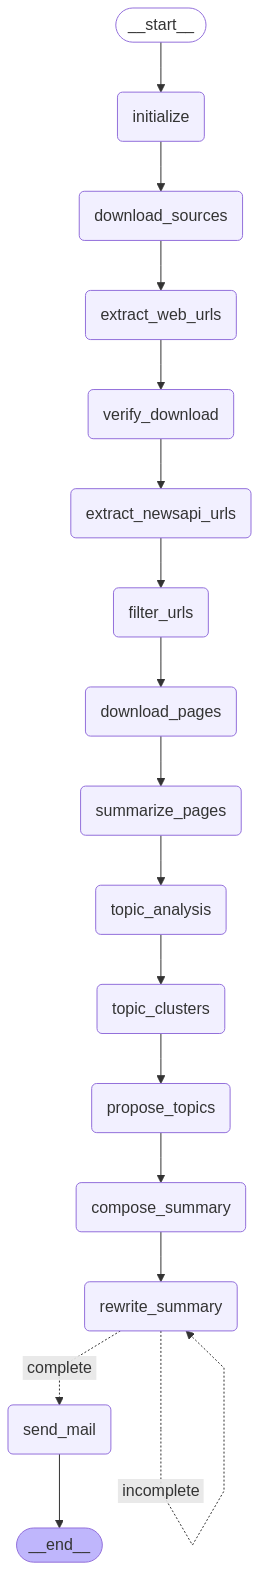

In [9]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-24 12:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [10]:
lg_state = lg_agent.initialize_config(lg_state)


2025-04-24 19:46:04,889 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-24 19:46:04,890 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-24 19:46:04,890 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-24 19:46:04,891 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-24 19:46:04,891 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-24 19:46:04,891 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-24 19:46:04,892 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [11]:
lg_state = lg_agent.download_sources(lg_state)


2025-04-24 19:46:06,399 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-04-24 19:46:06,402 - AInewsbot - INFO - Found 16 previously downloaded files
2025-04-24 19:46:06,403 - AInewsbot - INFO - htmldata/Hacker News 1 (04_24_2025 06_01_40 PM).html
2025-04-24 19:46:06,403 - AInewsbot - INFO - htmldata/Business Insider (04_24_2025 06_01_29 PM).html
2025-04-24 19:46:06,404 - AInewsbot - INFO - htmldata/Ars Technica (04_24_2025 06_01_30 PM).html
2025-04-24 19:46:06,405 - AInewsbot - INFO - htmldata/The Verge (04_24_2025 06_02_05 PM).html
2025-04-24 19:46:06,405 - AInewsbot - INFO - htmldata/HackerNoon (04_24_2025 06_01_43 PM).html
2025-04-24 19:46:06,405 - AInewsbot - INFO - htmldata/Techmeme (04_24_2025 06_01_54 PM).html
2025-04-24 19:46:06,406 - AInewsbot - INFO - htmldata/New York Times (04_24_2025 06_01_52 PM).html
2025-04-24 19:46:06,406 - AInewsbot - INFO - htmldata/Feedly AI (04_24_2025 06_02_50 PM).html
2025-04-24 19:46:06,406 - AInewsbot - INFO - html

In [12]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-04-24 19:46:06,898 - AInewsbot - INFO - Parsing html files
2025-04-24 19:46:06,899 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (04_24_2025 06_01_30 PM).html
2025-04-24 19:46:06,936 - AInewsbot - INFO - parse_file - found 169 raw links
2025-04-24 19:46:06,938 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-04-24 19:46:06,938 - AInewsbot - INFO - 35 links found
2025-04-24 19:46:06,939 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg (04_24_2025 06_01_32 PM).html
2025-04-24 19:46:06,961 - AInewsbot - INFO - parse_file - found 246 raw links
2025-04-24 19:46:06,963 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-04-24 19:46:06,963 - AInewsbot - INFO - 37 links found
2025-04-24 19:46:06,964 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider (04_24_2025 06_01_29 PM).html
2025-04-24 19:46:06,982 - AInewsbot - INFO - parse_file - found 211 raw links
2025-04-24 19:46:06,985 - AInewsbot - INFO - parse_file - found 21 filtered l

In [13]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,35
Bloomberg,30
Business Insider,21
FT,61
Feedly AI,33
Hacker News 1,24
Hacker News 2,23
HackerNoon,17
New York Times,18


number of missing sources 0


set()

In [14]:
lg_state = lg_agent.verify_download(lg_state)


2025-04-24 19:46:08,086 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [15]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-04-24 19:46:09,280 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-23T19:46:09 from NewsAPI


In [16]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-04-24 19:46:14,819 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-24 12:00'
2025-04-24 19:46:15,466 - AInewsbot - INFO - URLs in orig_df: 857
2025-04-24 19:46:15,469 - AInewsbot - INFO - Existing URLs in DB: 249374
2025-04-24 19:46:15,536 - AInewsbot - INFO - New URLs in df filtered by URL: 282
2025-04-24 19:46:15,665 - AInewsbot - INFO - Existing src+title: 8
2025-04-24 19:46:15,666 - AInewsbot - INFO - New URLs in df filtered by src+title: 274
2025-04-24 19:46:15,681 - AInewsbot - INFO - Found 274 unique new headlines
2025-04-24 19:46:15,683 - AInewsbot - INFO - Found 266 unique cleaned new headlines
2025-04-24 19:46:19,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:46:23,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:46:23,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTT

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,26
Hacker News 1,3
HackerNoon,1
New York Times,2
NewsAPI,28


In [17]:
lg_state = lg_agent.download_pages(lg_state)


2025-04-24 19:46:24,054 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-24 19:47:35,475 - AInewsbot - INFO - Processing page 0: https://www.axios.com/2025/04/24/ai-slop-studio-ghibli-barbie-deepfakes
2025-04-24 19:47:35,480 - AInewsbot - INFO - Processing page 1: https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray-bans/
2025-04-24 19:47:35,481 - AInewsbot - INFO - Processing page 2: https://www.fastcompany.com/91322491/ai-coding-tools-could-bring-us-the-one-employee-unicorn
2025-04-24 19:47:35,481 - AInewsbot - INFO - Processing page 3: https://www.businessinsider.com/ai-supercomputers-power-2030-city-nuclear-2025-4
2025-04-24 19:47:35,482 - AInewsbot - INFO - get_url(https://www.axios.com/2025/04/24/ai-slop-studio-ghibli-barbie-deepfakes) - starting get_url https://www.axios.com/2025/04/24/ai-slop-studio-ghibli-barbie-deepfakes
2025-04-24 19:47:35,483 - AInewsbot - INFO - get_url(https://www.cnet.com/tech/mobile/hey-meta-new-ai-features-come-to-metas-ray

2025-04-24 19:47:35,501 - AInewsbot - INFO - get_url(https://www.nzherald.co.nz/entertainment/black-mirror-showed-us-a-future-some-of-it-is-here-now/M5QZVWZC3VBOLGTLKXJRCIMEWE/) - starting get_url https://www.nzherald.co.nz/entertainment/black-mirror-showed-us-a-future-some-of-it-is-here-now/M5QZVWZC3VBOLGTLKXJRCIMEWE/
2025-04-24 19:47:35,501 - AInewsbot - INFO - Processing page 22: https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence
2025-04-24 19:47:35,502 - AInewsbot - INFO - get_url(https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence) - starting get_url https://law.yale.edu/yls-today/news/charting-new-courses-artificial-intelligence
2025-04-24 19:47:35,500 - AInewsbot - INFO - Processing page 21: https://www.nbcnews.com/news/us-news/california-bar-discloses-ai-used-develop-questions-problem-exam-rcna202713
2025-04-24 19:47:35,502 - AInewsbot - INFO - Processing page 24: https://biztoc.com/x/9514d7f70182e97c
2025-04-24 19:47:3

2025-04-24 19:47:35,522 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit) - starting get_url https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit
2025-04-24 19:47:35,522 - AInewsbot - INFO - get_url(https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural) - starting get_url https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural
2025-04-24 19:47:35,521 - AInewsbot - INFO - Processing page 40: https://techcrunch.com/2025/04/24/threads-officially-moves-to-threads-com-and-updates-its-web-app/
2025-04-24 19:47:35,523 - AInewsbot - INFO - Processing page 41: https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html
2025-04-24 19:47:35,525 - AInewsbot - INFO - get_url(https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola

2025-04-24 19:47:35,538 - AInewsbot - INFO - get_url(https://arxiv.org/abs/2503.19779) - starting get_url https://arxiv.org/abs/2503.19779
2025-04-24 19:47:35,538 - AInewsbot - INFO - Processing page 59: https://biztoc.com/x/d0fa23d65190fd94
2025-04-24 19:47:35,539 - AInewsbot - INFO - Processing page 60: https://www.inc.com/jason-aten/sam-altman-just-trolled-everyone-and-its-the-smartest-idea-ive-seen-yet/91180622
2025-04-24 19:47:35,540 - AInewsbot - INFO - get_url(https://www.inc.com/jason-aten/sam-altman-just-trolled-everyone-and-its-the-smartest-idea-ive-seen-yet/91180622) - starting get_url https://www.inc.com/jason-aten/sam-altman-just-trolled-everyone-and-its-the-smartest-idea-ive-seen-yet/91180622
2025-04-24 19:47:35,539 - AInewsbot - INFO - Processing page 61: https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html
2025-04-24 19:47:35,540 - AInewsbot - INFO - get_url(https://biztoc.com/x/d0fa23d65190fd94) - starting get_url https://biztoc.com/x/d0fa2

2025-04-24 19:47:35,570 - AInewsbot - INFO - Processing page 79: https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html
2025-04-24 19:47:35,571 - AInewsbot - INFO - get_url(https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html) - starting get_url https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html
2025-04-24 19:47:35,572 - AInewsbot - INFO - Quit webdriver
2025-04-24 19:47:36,220 - AInewsbot - INFO - get_url(SK Hynix Posts Strong First Quarter Earnings on AI Chip Demand) - Saving SK_Hynix_Posts_Strong_First_Quarter_Earnings_on_AI_Chip_Demand.html as utf-8
2025-04-24 19:47:36,221 - AInewsbot - INFO - Quit webdriver
2025-04-24 19:47:37,123 - AInewsbot - INFO - get_url(Two of the three men leading our nation are to some degree members of a cult that posits that Democracy is irrational and AI is always six months away from becoming God, and they have killed over 43,000 people in accordance with this philosoph

In [18]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-04-24 19:47:43,714 - AInewsbot - INFO - Starting summarize
2025-04-24 19:47:43,717 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-24 19:47:43,742 - AInewsbot - INFO - clean_html - Page title: The problem with AI slop
Social card title: Not all AI is slop
Social card description: One person's slop is another person's fun meme.

2025-04-24 19:47:43,851 - AInewsbot - INFO - Queuing 0: Page title: The problem with AI slop
Social card t...
2025-04-24 19:47:43,915 - AInewsbot - INFO - clean_html - Page title: 'Hey Meta': New AI Features Come to Meta's Ray-Bans - CNET
Social card title: 'Hey Meta': New AI Features Come to Meta's Ray-Bans
Social card description: Updates to the Meta glasses bring a "live AI" button and real-time translation services, among other new features.

2025-04-24 19:47:43,961 - AInewsbot - INFO - Queuing 1: Page title: 'Hey Meta': New AI Features Come to Me...
2025-04-24 19:47:43,977 - AInewsbot - INFO - clean_html - Page title: AI coding tools c

2025-04-24 19:47:45,481 - AInewsbot - INFO - clean_html - Page title: Asia-Pacific newsrooms share AI adoption journeys | The Star
Social card title: Asia-Pacific newsrooms share AI adoption journeys
Social card description: KUALA LUMPUR: From creating customised reader personas to utilising an artificial intelligence-aided therapist for readers, news organisations from across the Asia-Pacific region have shared their journeys in adopting AI within newsrooms.

2025-04-24 19:47:45,542 - AInewsbot - INFO - Queuing 18: Page title: Asia-Pacific newsrooms share AI adopti...
2025-04-24 19:47:45,580 - AInewsbot - INFO - clean_html - Page title: Beyond Work: 4 Arenas To Chart The Course Of Life Amid Agentic AI
Social card title: Beyond Work: 4 Arenas To Chart The Course Of Life Amid Agentic AI
Social card description: The Future with AI is not happening to but because of us. The transition to a life with agentic AI requires a proactive stance from all of us. 

2025-04-24 19:47:45,618 - AInewsb

2025-04-24 19:47:46,078 - AInewsbot - INFO - Queuing 33: Page title: Google’s AI Overviews in Search now ha...
2025-04-24 19:47:46,092 - AInewsbot - INFO - clean_html - Page title: OpenAI's ChatGPT is the perfect shopping experience for those who hate to shop | Fortune
Social card title: I hate shopping. ChatGPT is already helping me in ways Google never did
Social card description: A basic Google search can't match the personalized styling tips and recommendations that ChatGPT offers.

2025-04-24 19:47:46,117 - AInewsbot - INFO - Queuing 34: Page title: OpenAI's ChatGPT is the perfect shoppi...
2025-04-24 19:47:46,128 - AInewsbot - INFO - clean_html - Page title: If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times
Social card title: If A.I. Systems Become Conscious, Should They Have Rights?
Social card description: As artificial intelligence systems become smarter, one A.I. company is trying to figure out what to do if they become conscious.

2025-04-24 19:

2025-04-24 19:47:46,754 - AInewsbot - INFO - Queuing 50: Page title: OpenAI may be developing its own socia...
2025-04-24 19:47:46,769 - AInewsbot - INFO - clean_html - Page title: Introducing our latest image generation model in the API | OpenAI
Social card title: Introducing our latest image generation model in the API
Social card description: Our latest image generation model is now available in the API via ‘gpt-image-1’—enabling developers and businesses to build professional-grade, customizable visuals directly into their own tools and platforms.

2025-04-24 19:47:46,805 - AInewsbot - INFO - Queuing 51: Page title: Introducing our latest image generatio...
2025-04-24 19:47:46,816 - AInewsbot - INFO - clean_html - Page title: OpenAI wants its 'open' AI model to call models in the cloud for help | TechCrunch
Social card title: OpenAI wants its 'open' AI model to call models in the cloud for help | TechCrunch
Social card description: OpenAI is reportedly planning for its forthcoming 

2025-04-24 19:47:47,411 - AInewsbot - INFO - Queuing 65: Page title: Step aside, Siri: Perplexity's new AI ...
2025-04-24 19:47:47,427 - AInewsbot - INFO - clean_html - Page title: The AI-generated movie What’s Next opens new questions on AI filmmaking | Polygon
Social card title: The AI-generated movie What’s Next opens a fresh debate over AI filmmaking
Social card description: Director Cao Yiwen says AI opened a door that sexism and cronyism shut — but she shrugs off the ethical questions her movie raises.

2025-04-24 19:47:47,462 - AInewsbot - INFO - Queuing 66: Page title: The AI-generated movie What’s Next ope...
2025-04-24 19:47:47,489 - AInewsbot - INFO - clean_html - Page title: US to loosen rules on self-driving vehicles criticised by Elon Musk
Social card title: US to loosen rules on self-driving vehicles criticised by Elon Musk
Social card description: National Highway Traffic Safety Administration will make it easier to get autonomous cars on the road

2025-04-24 19:47:47,5

2025-04-24 19:47:50,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:50,588 - httpx 

2025-04-24 19:47:57,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:47:57,191 - AInewsbot - INFO - Received 79 summaries
2025-04-24 19:47:57,192 - AInewsbot - INFO - Summary for 0 (length 771): no content
2025-04-24 19:47:57,192 - AInewsbot - INFO - Summary for 1 (length 2084): • Meta is rolling out new AI features for its Ray-Ban smart glasses in the US and Canada, including a "Hey Meta, start live AI" command that enables users to get real-time answers and problem-solving by analyzing what the glasses see.  
• The glasses will support live translation in English, French, Italian, and Spanish, translating conversations in real time with both audio and on-screen transcripts.  
• Additional updates include voice-controlled Instagram posts and Messenger messages, compatibility with major music streaming services, and object recognition updates for EU users expected next week; most new features will roll out this spring an

2025-04-24 19:47:57,196 - AInewsbot - INFO - Summary for 11 (length 1777): • Apple is relocating its secret robotics unit from the artificial intelligence (AI) division led by John Giannandrea to the hardware division overseen by Senior Vice President John Ternus later this month, according to sources familiar with the matter.
• This move marks the second major project removed from Giannandrea's oversight in recent weeks, following the transfer of responsibility for the Siri voice assistant in March.
2025-04-24 19:47:57,196 - AInewsbot - INFO - Summary for 12 (length 3522): • Apple has detailed the process behind its AI-generated App Store review summaries, introduced to the public in March 2025 with iOS 18.4, aiming to provide users with clear and up-to-date overviews of app reviews.

• The system filters out spam and profanity, then uses multiple specialized large language models (LLMs) to extract insights, identify common themes, and balance user sentiment, resulting in summaries of

2025-04-24 19:47:57,203 - AInewsbot - INFO - Summary for 22 (length 9336): • Yale Law School is offering two new spring courses focused on artificial intelligence: “Law and Large Language Models,” which teaches students how to train LLMs on legal texts, and “Artificial Intelligence Law and Policy,” which examines regulation and legal frameworks for AI.
• The courses emphasize interdisciplinary collaboration between law and computer science, with one class focusing on practical tool-building with coding and legal reasoning, and the other analyzing the application and regulation of AI in areas like privacy, freedom of expression, and intellectual property.
• Professors Scott Shapiro highlighted the aim to equip students to communicate across disciplines, stating, “We’re trying to create law students who can speak to technologists,” while Professor Jack Balkin noted Yale Law School's commitment to proactively addressing the future impact of AI on the legal profession.
2025-04-24 19:47:57,

2025-04-24 19:47:57,207 - AInewsbot - INFO - Summary for 33 (length 2501): • Google CEO Sundar Pichai announced that AI Overviews in Search now have “1.5 billion users per month,” as part of Alphabet’s Q1 2025 earnings report.
• Alphabet reported Q1 2025 revenues of $90.2 billion, a 12% year-over-year increase, and surpassed 270 million subscriptions driven by YouTube and Google One.
• Google continues to expand its AI offerings, rolling out tools like the Gemini 2.5 Pro AI model and announcing plans to replace Assistant with Gemini on mobile and other devices later this year.
• The company faces the possibility of being broken up due to significant antitrust losses and ongoing trials following US Department of Justice rulings that Google is a monopoly in search and ad tech.
2025-04-24 19:47:57,208 - AInewsbot - INFO - Summary for 34 (length 11762): • OpenAI's ChatGPT, now integrating real-time data from Bing and OpenAI’s web crawlers, is providing highly personalized shopping recommen

2025-04-24 19:47:57,211 - AInewsbot - INFO - Summary for 44 (length 2573): • SK Hynix reported operating income of 7.44 trillion won ($5.2 billion) and revenue of 17.64 trillion won for the March quarter, both surpassing analyst estimates and marking its second-highest quarterly performance, driven by global demand for high-bandwidth memory used in AI and Nvidia accelerators.  
• The company maintained its forecast that demand for high-bandwidth memory (HBM) will double in 2024, but warned of increased uncertainty and volatility due to US tariff policies and global trade tensions.  
• Despite strong earnings, SK Hynix’s stock has risen only about 4% this year as fears of a tariff-fueled recession and questions about AI profitability have dampened momentum, with analysts cautioning that broader economic factors could outweigh earnings results.
2025-04-24 19:47:57,211 - AInewsbot - INFO - Summary for 45 (length 4068): • News organisations from across the Asia-Pacific shared their AI adop

2025-04-24 19:47:57,213 - AInewsbot - INFO - Summary for 54 (length 2475): • Perplexity's Chief Business Officer testified in Google's antitrust trial that Google previously blocked Perplexity from being bundled with Motorola phones due to restrictive distribution contracts.
• After this testimony, Perplexity is now included on Motorola's newly announced Razr flip phones, indicating a possible shift in Google's approach.
• Shevelenko described Google's mobile integration contracts as "a gun to your head" and emphasized the challenges of securing default placement due to Google's dominance on mobile devices.
2025-04-24 19:47:57,213 - AInewsbot - INFO - Summary for 55 (length 9747): • Hewlett Packard Enterprise (HPE) launched eight new ProLiant Compute Gen12 servers in February 2024, focusing on enhanced security, performance, and automation to meet the demands of enterprise AI workloads.  
• ProLiant Gen12 servers feature security upgrades such as quantum-resistant algorithms, complianc

2025-04-24 19:47:57,216 - AInewsbot - INFO - Summary for 66 (length 12261): • "What’s Next?", a 72-minute movie made entirely of AI-generated video clips by director Cao Yiwen, premiered at the 75th Berlin International Film Festival, raising new debates on the ethical, legal, and creative implications of AI in filmmaking.

• Cao Yiwen describes AI as a means to overcome barriers she faced in traditional filmmaking due to sexism and a lack of industry connections, stating, “AI opened a door that sexism and cronyism shut”—but she largely dismissed concerns about copyright and the ethical use of generative AI.

• Experts and festival organizers acknowledge ongoing legal uncertainties; the AI platform used (Runway) has faced lawsuits for being trained on existing works, highlighting unresolved issues of potential copyright infringement and the need for clearer guidance as AI-generated films become more prevalent.
2025-04-24 19:47:57,216 - AInewsbot - INFO - Summary for 67 (length 3476): •

2025-04-24 19:47:57,218 - AInewsbot - INFO - Summary for 79 (length 3211): • Ziff Davis, publisher of sites including Mashable and PCMag, filed a lawsuit against OpenAI in federal court in Delaware, alleging copyright infringement and trademark dilution over OpenAI's alleged use of Ziff Davis content to train AI models and generate responses in ChatGPT.

• Ziff Davis claims OpenAI "intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works," and is seeking at least hundreds of millions of dollars in damages.

• The lawsuit follows similar actions by other media companies against OpenAI, with several claims now consolidated in U.S. courts, and comes as some publishers strike licensing deals while others pursue legal action over AI use of their content.
2025-04-24 19:47:57,218 - AInewsbot - INFO - Received 79 summaries


In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [20]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-04-24 19:48:08,500 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:48:19,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:19,407 - AInewsbot - INFO - missing items: {74, 76}
2025-04-24 19:48:19,408 - AInewsbot - INFO - Retrying after No id found in the results, attempt 1
2025-04-24 19:48:19,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:19,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:22,171 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:30,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:30,230 - AInewsbot - INFO - missing items: {74, 76}
2025-04-24 19:48:30,

2025-04-24 19:48:52,431 - AInewsbot - INFO - Canonical topic virtual assistants
2025-04-24 19:48:52,432 - AInewsbot - INFO - Canonical topic agriculture
2025-04-24 19:48:52,432 - AInewsbot - INFO - Canonical topic health & fitness
2025-04-24 19:48:52,432 - AInewsbot - INFO - Canonical topic privacy & surveillance
2025-04-24 19:48:52,433 - AInewsbot - INFO - Canonical topic anthropic
2025-04-24 19:48:52,433 - AInewsbot - INFO - Canonical topic society & culture
2025-04-24 19:48:52,434 - AInewsbot - INFO - Canonical topic review
2025-04-24 19:48:52,434 - AInewsbot - INFO - Canonical topic stocks
2025-04-24 19:48:52,434 - AInewsbot - INFO - Canonical topic economics
2025-04-24 19:48:52,434 - AInewsbot - INFO - Canonical topic healthcare
2025-04-24 19:48:52,435 - AInewsbot - INFO - Canonical topic brain-computer interfaces
2025-04-24 19:48:52,435 - AInewsbot - INFO - Canonical topic lifestyle & travel
2025-04-24 19:48:52,435 - AInewsbot - INFO - Canonical topic music
2025-04-24 19:48:52,43

2025-04-24 19:48:58,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:58,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:58,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:58,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:58,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,019 - httpx 

2025-04-24 19:48:59,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,632 - httpx 

2025-04-24 19:48:59,938 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,957 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:48:59,963 - httpx 

2025-04-24 19:49:00,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,148 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,162 - httpx 

2025-04-24 19:49:00,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,414 - httpx 

2025-04-24 19:49:00,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:00,767 - httpx 

2025-04-24 19:49:01,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:01,597 - httpx 

In [21]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-04-24 19:49:06,094 - AInewsbot - INFO - Fetching embeddings for 79 headlines
2025-04-24 19:49:07,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-24 19:49:07,878 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-24 19:49:07,892 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-24 19:49:08,806 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-24 19:49:08,861 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-24 19:49:08,875 - AInewsbot - INFO - Found 3 clusters


,title_topic_str
0,"Apple explains how App Store reviews are summarized with AI (Topics: AI Adoption, AI Demand, AI Training, AI-Generated Summaries, App Store Reviews, Apple, Automation, Chatgpt, Code Assistants, Customer Service, Gen AI, Generative AI, Innovation, Language Models, Large Language Models, Products, Reader Engagement, Recommendation Systems, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, Testing, User Sentiment)"
1,"Apple To Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri (Topics: Apple, Gen AI, Generative AI, Hardware, Hardware Division, John Giannandrea, Robotics Unit, Robots, Siri, Speech Recognition & Synthesis, Virtual Assistants)"
2,"Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri (Topics: Apple, Gen AI, Generative AI, Hardware, John Giannandrea, Leadership Change, Robotics Team, Robots, Siri, Siri Development, Speech Recognition & Synthesis, Virtual Assistants)"
3,"Apple's Secret Robotics Team Gets New Leadership (Topics: AI Chief Leadership, AI Demand, Apple, Automation, Gen AI, Generative AI, Hardware, Innovation, John Giannandrea, Mergers And Acquisitions, Products, Project Management, Robotics Division, Robots, Siri, Speech Recognition & Synthesis, Team Restructuring, Virtual Assistants)"


2025-04-24 19:49:10,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:10,197 - AInewsbot - INFO - I dub this cluster: Apple's AI and Robotics Restructuring


,title_topic_str
4,"As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever (Topics: AI Adoption, AI Literacy, Art & Design, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Critical Thinking, Curriculum Redesign, Education, Engineering Education, Ethical Implications, Ethics, Gen AI, Generative AI, Jobs & Careers, Labor Market, Language Models, OpenAI, Opinion, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants)"
5,"I hate shopping. ChatGPT is already helping me in ways Google never did (Topics: AI Adoption, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Customer Service, Deals, Economics, Fashion, Gen AI, Generative AI, Google, Google Search, Innovation, John Giannandrea, Language Models, Lifestyle & Travel, OpenAI, Opinion, Perplexity AI, Personalized Recommendations, Politics, Products, Recommendation Systems, Review, Shopping Experience, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
6,"Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. (Topics: AI Interaction, Anthropic, Chatbots, Chatgpt, Climate, Code Assistants, Computational Costs, Economics, Energy, Ethical Implications, Ethics, Finance, Gen AI, Generative AI, Language Models, OpenAI, Opinion, Politeness, Resource Consumption, Society & Culture, Sustainability, Virtual Assistants)"


2025-04-24 19:49:11,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:11,512 - AInewsbot - INFO - I dub this cluster: ChatGPT's Impact on Society and Education


,title_topic_str
7,"Nvidia Supplier SK Hynixs Earnings Beat Estimates on AI Boom (Topics: AI Adoption, AI Chip Demand, AI Demand, AI Training, Earnings Report, Economics, Finance, Gen AI, Generative AI, Hardware, High-Bandwidth Memory, Innovation, Korea, Policy And Regulation, Products, Semiconductor Chips, Sk Hynix, Stocks, Tariff Concerns, Us Tariffs)"
8,"US biz stockpilers boost SK Hynix top line as memory market undergoes structural change'Inventory accumulation' as vendors hoard HBM amid tariff and other pressuresStorage7 hrs| (Topics: AI Adoption, AI Demand, Artificial General Intelligence, Economics, Energy, Finance, Gen AI, Generative AI, Hardware, High-Bandwidth Memory, Infrastructure, Innovation, Korea, Language Models, Manufacturing, Memory Market, Products, Semiconductor Chips, Sk Hynix, Stocks, Supply Chain Optimization, Tariff Pressures, Us Tariffs)"
9,"SK Hynix Posts Strong First Quarter Earnings on AI Chip Demand (Topics: AI Adoption, AI Chips, AI Demand, AI Training, Alphabet Earnings, Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, Bubble, China, Computer Vision, Cryptocurrency, Drones, Economics, Energy, Facial Recognition, Finance, Fintech, First Quarter Earnings, Gaming, Gen AI, Generative AI, Hardware, Innovation, Internet Of Things, Ipos, Korea, Labor Market, Legal Issues, Manufacturing, Market Demand, Military, Neuromorphic Computing, Policy And Regulation, Products, Quantum Computing, Robots, Semiconductor Chips, Sk Hynix, Smart Grid, Stocks, Supply Chain Optimization, Tariff Uncertainty, Transformers, Us Tariffs)"
10,"Nvidia supplier SK Hynix's Q1 profit soars, flags H2 demand risks from tariffs (Topics: AI Adoption, AI Chip Market, AI Demand, AI Training, China, Economics, Finance, Gen AI, Generative AI, Hardware, High-Bandwidth Memory, Innovation, Korea, Mobile Dram, Policy And Regulation, Products, Profit Increase, Semiconductor Chips, Sk Hynix, Stocks, Us Tariffs)"
11,"Nvidia supplier SK Hynix's Q1 profit more than doubles, tops expectations (Topics: AI Adoption, AI Demand, AI Training, Economics, Finance, Gen AI, Generative AI, Hardware, High-Bandwidth Memory, Innovation, Korea, Policy And Regulation, Products, Q1 Profit, Semiconductor Chips, Sk Hynix, Stocks, Us Tariffs)"
12,"Nvidia supplier SK Hynix's Q1 profit jumps, beating expectations (Topics: AI Adoption, AI Demand, AI Training, Authors & Writing, Automation, Bias And Fairness, Digital Media Asia 2025, Ethical Implications, Ethics, Gen AI, Generative AI, Innovation, Job Automation, Korea, Media Innovation, Newsroom Efficiency, Reader Engagement, Recommendation Systems, Society & Culture, Taiwan, Virtual Assistants)"


2025-04-24 19:49:12,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:12,971 - AInewsbot - INFO - I dub this cluster: SK Hynix's AI-Driven Chip Growth
2025-04-24 19:49:13,009 - AInewsbot - INFO - Sending bullet points email
2025-04-24 19:49:14,163 - AInewsbot - INFO - ["Apple's AI and Robotics Restructuring", "ChatGPT's Impact on Society and Education", "SK Hynix's AI-Driven Chip Growth"]


In [22]:
# flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state, model_str='o3-mini')


2025-04-24 19:49:14,213 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:49:14,214 - AInewsbot - INFO - Initial cluster topics: 
Apple's AI and Robotics Restructuring
ChatGPT's Impact on Society and Education
SK Hynix's AI-Driven Chip Growth
2025-04-24 19:49:33,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:49:33,131 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Apple's AI and Robotics Restructuring
ChatGPT's Impact on Society and Education
SK Hynix's AI-Driven Chip Growth
Apple AI App Store Reviews
Apple Restructures Robotics Unit
ChatGPT Engineering Study Sparks Curriculum Change
AI Powers Personalized Shopping Experience
Politeness in ChatGPT Raises Costs
SK Hynix Boosts AI Chip Demand
Asia-Pacific Newsrooms Embrace AI Integration
Google Free AI Tools for Students
NYC Mayoral AI Language

In [23]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-04-24 19:49:56,496 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:50:44,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-24 19:50:44,491 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# Apple’s A.I. and Robotic Remix  
- Apple debuts AI-generated App Store review summaries in iOS 18.4 by filtering spam and profanity and leveraging multiple LLMs for clear, balanced user insights – [Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)  
- Apple relocates its secret robotics unit from AI chief John Giannandrea’s division to the hardware team led by John Ternus, marking another shift after moving Siri’s oversight – [apple.slashdot.org](https://apple.slashdot.org/story/25/04/24/2025223/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)  
- Apple merges its robotics teams and appoints Kevin Lynch as the new leader, aiming to accelerate innovative robot development and integrate advanced sensor technologies – [MacRumors](https://www.macrumors.com/2025/04/24/apple-robotics-team-leadership-change/)

# Chip Happens: SK Hynix’s AI Power Play  
- SK Hynix smashes estimates with an operating income of 7.44 trillion won driven by high demand for AI chips and high-bandwidth memory, forecasting a doubling of demand in 2024 – [Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html)  
- SK Hynix posts a 42% revenue jump amid industry stockpiling and tariff uncertainties, reflecting a structural shift in memory markets – [The Register](https://www.theregister.com/2025/04/24/sk_hynix_gets_revenue_boost/)  
- SK Hynix’s Q1 operating profit surges 158% year-on-year, bolstered by AI chip and smartphone segment demand, while key sales to Nvidia remain unchanged – [Channel NewsAsia](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)

# OpenAI and Industry Turbulence  
- Former OpenAI staffers, including AI experts and Nobel laureates, urge California and Delaware AGs to block the company’s for-profit restructuring to preserve public-interest safeguards – [CNBC](https://www.cnbc.com/2025/04/23/ex-openai-staffers-urge-california-delaware-not-to-allow-restructure.html)  
- Ten ex-OpenAI employees press AGs to reject converting ChatGPT maker to a for-profit entity, warning that such a move would erode essential governance clauses – [Japan Today](https://japantoday.com/category/tech/ex-openai-workers-ask-california-and-delaware-ags-to-block-for-profit-conversion-of-chatgpt-maker)  
- Ziff Davis launches a federal lawsuit against OpenAI alleging that its content was used to train ChatGPT without permission, seeking hundreds of millions in damages – [The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)  
- OpenAI is reportedly exploring an X-like social platform centered on ChatGPT’s image generation to harness unique, real-time data for further model training – [TechCrunch](https://techcrunch.com/video/openai-may-be-developing-its-own-social-platform-but-whos-it-for/)

# Everyday A.I.: Smarter Searches, Shopping, and Voices  
- ChatGPT, now integrating real-time data streams, offers personalized shopping recommendations and styling tips that challenge traditional Google search paradigms – [Fortune](https://fortune.com/2025/04/24/i-hate-shopping-chatgpt-is-already-helping-me-in-ways-google-never-did-eye-on-ai/)  
- Perplexity debuts a new AI voice assistant for iPhone which taps into native data and app integrations to tackle Siri’s longstanding limitations – [ZDNet](https://www.zdnet.com/article/step-aside-siri-perplexitys-new-ai-voice-assistant-for-iphone-can-take-it-from-here/)

# Smart Lessons & Policy Pivots: AI in Education and Ethics  
- A pilot study at the University of Illinois reveals that ChatGPT scores a B- in an engineering course, prompting professors to reshape assignments and emphasize AI literacy and critical thinking – [The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)  
- President Trump signs an executive order to bolster AI education and workforce training, launching public-private partnerships and task forces to prepare students for a tech-driven future – [biztoc.com](https://biztoc.com/x/6495e81fd39cc74a)  
- The UK's Copyright Licensing Agency unveils a Generative AI Training Licence that promises legal certainty for LLM developers and fair compensation for publishers over AI training data use – [The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

# Earnings, Servers, and Supercomputing: Broader Tech Moves  
- Alphabet reports Q1 earnings that beat expectations, with Google’s AI Overviews now reaching 1.5 billion users per month and a robust rollout of the Gemini 2.5 model amidst intensified antitrust scrutiny – [Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)  
- Hewlett Packard Enterprise launches its new ProLiant Gen12 servers featuring quantum-resistant security and liquid-cooling options, targeting enhanced performance for enterprise AI workloads – [SiliconANGLE](https://siliconangle.com/2025/04/24/hpe-proliant-new-capabilities-enterprise-ai-hpefutureready/)

2025-04-24 19:50:44,495 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:51:07,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Today's AI Pulse: Tech Shifts and Policy Moves

Apple's AI & Robotics Shake-Up
- Apple launches AI-generated App Store review summaries in iOS 18.4 for improved moderation – [Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)
- Apple shifts its secret robotics unit from AI chief division to hardware team led by John Ternus – [apple.slashdot.org](https://apple.slashdot.org/story/25/04/24/2025223/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)
- Apple consolidates robotics teams and names Kevin Lynch as leader to accelerate development – [MacRumors](https://www.macrumors.com/2025/04/24/apple-robotics-team-leadership-change/)

SK Hynix's AI Chip Surge
- SK Hynix posts 7.44 trillion won operating income driven by AI chip demand and forecasts doubling demand in 2024 – [Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668.html)
- SK Hynix revenue jumps 42% amid industry stockpiling and tariff uncertainties – [The Register](https://www.theregister.com/2025/04/24/sk_hynix_gets_revenue_boost/)
- SK Hynix’s Q1 operating profit climbs 158% year-on-year, bolstered by AI chip and smartphone demand, with stable Nvidia sales – [Channel NewsAsia](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)

OpenAI: Restructuring & Lawsuits
- Former OpenAI staff urge state AGs to block the company's for-profit conversion, warning of governance erosion – [CNBC](https://www.cnbc.com/2025/04/23/ex-openai-staffers-urge-california-delaware-not-to-allow-restructure.html) [Japan Today](https://japantoday.com/category/tech/ex-openai-workers-ask-california-and-delaware-ags-to-block-for-profit-conversion-of-chatgpt-maker)
- Ziff Davis files a federal lawsuit against OpenAI, alleging unauthorized use of content in training ChatGPT and seeking hundreds of millions in damages – [The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)
- OpenAI explores developing an X-like social platform for ChatGPT image generation to access real-time training data – [TechCrunch](https://techcrunch.com/video/openai-may-be-developing-its-own-social-platform-but-whos-it-for/)

Everyday AI: Search, Style, & Voice
- ChatGPT now incorporates real-time data to offer personalized shopping recommendations and styling tips – [Fortune](https://fortune.com/2025/04/24/i-hate-shopping-chatgpt-is-already-helping-me-in-ways-google-never-did-eye-on-ai/)
- Perplexity debuts an AI voice assistant for iPhone featuring native data and app integrations to overcome Siri’s limitations – [ZDNet](https://www.zdnet.com/article/step-aside-siri-perplexitys-new-ai-voice-assistant-for-iphone-can-take-it-from-here/)

AI in Education & Policy
- A University of Illinois pilot study shows ChatGPT earning a B- in an engineering course, prompting educators to adjust assignments and emphasize AI literacy – [The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)
- President Trump signs an executive order to enhance AI education and workforce training through public-private partnerships – [biztoc.com](https://biztoc.com/x/6495e81fd39cc74a)
- The UK's Copyright Licensing Agency launches a Generative AI Training Licence to provide legal clarity and fair compensation for AI training data use – [The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Corporate AI & Quantum Capabilities
- Alphabet reports Q1 earnings surpassing expectations, with Google's AI Overviews reaching 1.5 billion users monthly and the Gemini 2.5 rollout amid antitrust scrutiny – [Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)
- Hewlett Packard Enterprise unveils ProLiant Gen12 servers featuring quantum-resistant security and liquid-cooling to support enterprise AI workloads – [SiliconANGLE](https://siliconangle.com/2025/04/24/hpe-proliant-new-capabilities-enterprise-ai-hpefutureready/)

2025-04-24 19:51:07,138 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-24 19:51:31,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Today's AI Headliners: Tech Reforms, Chip Booms & Policy Shifts

Apple's AI Reboot
- Apple launches AI-generated App Store review summaries in iOS 18.4 for enhanced moderation – [Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)
- Apple restructures its robotics unit by shifting it from the AI division to the hardware team led by John Ternus and naming Kevin Lynch to consolidate development – [apple.slashdot.org](https://apple.slashdot.org/story/25/04/24/2025223/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri) | [MacRumors](https://www.macrumors.com/2025/04/24/apple-robotics-team-leadership-change/)

SK Hynix’s AI Chip Boom
- SK Hynix posts strong Q1 results driven by AI chip demand, reporting 7.44 trillion won operating income, 42% revenue growth, and a 158% increase in operating profit – [Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668) | [The Register](https://www.theregister.com/2025/04/24/sk_hynix_gets_revenue_boost/) | [Channel NewsAsia](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)

OpenAI Under Fire
- Former OpenAI employees urge state AGs to block the company’s for-profit conversion over governance concerns – [CNBC](https://www.cnbc.com/2025/04/23/ex-openai-staffers-urge-california-delaware-not-to-allow-restructure.html) | [Japan Today](https://japantoday.com/category/tech/ex-openai-workers-ask-california-and-delaware-ags-to-block-for-profit-conversion-of-chatgpt-maker)
- Ziff Davis files a federal lawsuit against OpenAI for alleged unauthorized use of content in training ChatGPT, seeking significant damages – [The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)
- OpenAI explores developing a social platform for ChatGPT image generation to access real-time data – [TechCrunch](https://techcrunch.com/video/openai-may-be-developing-its-own-social-platform-but-whos-it-for/)

Everyday AI: Smart Assistants
- ChatGPT now incorporates real-time data to offer personalized shopping recommendations – [Fortune](https://fortune.com/2025/04/24/i-hate-shopping-chatgpt-is-already-helping-me-in-ways-google-never-did-eye-on-ai/)
- Perplexity debuts an AI voice assistant for iPhone with native data and app integrations – [ZDNet](https://www.zdnet.com/article/step-aside-siri-perplexitys-new-ai-voice-assistant-for-iphone-can-take-it-from-here/)

Educating AI: Policy & Classrooms
- A University of Illinois pilot finds ChatGPT earned a B- in an engineering course, prompting assignment adjustments – [The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)
- An executive order enhances AI education and workforce training through public-private partnerships – [biztoc.com](https://biztoc.com/x/6495e81fd39cc74a)
- The UK's Copyright Licensing Agency launches a Generative AI Training Licence for legal clarity and fair AI training data compensation – [The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Corporate AI & Quantum Edge
- Alphabet reports Q1 earnings surpassing expectations with Google’s AI Overviews reaching 1.5 billion monthly users and rolls out Gemini 2.5 amid antitrust scrutiny – [Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)
- Hewlett Packard Enterprise unveils ProLiant Gen12 servers featuring quantum-resistant security and liquid-cooling for enterprise AI workloads – [SiliconANGLE](https://siliconangle.com/2025/04/24/hpe-proliant-new-capabilities-enterprise-ai-hpefutureready/)

2025-04-24 19:51:31,329 - AInewsbot - INFO - Sending summary email
2025-04-24 19:51:31,336 - AInewsbot - INFO - Email subject AI news summary 19:51:31
2025-04-24 19:51:31,336 - AInewsbot - INFO - Email length 3978


Today's AI Headliners: Tech Reforms, Chip Booms & Policy Shifts

Apple's AI Reboot
- Apple launches AI-generated App Store review summaries in iOS 18.4 for enhanced moderation – [Apple Insider](https://appleinsider.com/articles/25/04/24/apple-explains-how-app-store-reviews-are-summarized-with-ai)
- Apple restructures its robotics unit by shifting it from the AI division to the hardware team led by John Ternus and naming Kevin Lynch to consolidate development – [apple.slashdot.org](https://apple.slashdot.org/story/25/04/24/2025223/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri) | [MacRumors](https://www.macrumors.com/2025/04/24/apple-robotics-team-leadership-change/)

SK Hynix’s AI Chip Boom
- SK Hynix posts strong Q1 results driven by AI chip demand, reporting 7.44 trillion won operating income, 42% revenue growth, and a 158% increase in operating profit – [Live Mint](https://www.livemint.com/companies/company-results/nvidia-supplier-sk-hynix-s-earnings-beat-estimates-on-ai-boom-11745449610668) | [The Register](https://www.theregister.com/2025/04/24/sk_hynix_gets_revenue_boost/) | [Channel NewsAsia](https://www.channelnewsasia.com/business/nvidia-supplier-sk-hynixs-q1-profit-more-doubles-tops-expectations-5085026)

OpenAI Under Fire
- Former OpenAI employees urge state AGs to block the company’s for-profit conversion over governance concerns – [CNBC](https://www.cnbc.com/2025/04/23/ex-openai-staffers-urge-california-delaware-not-to-allow-restructure.html) | [Japan Today](https://japantoday.com/category/tech/ex-openai-workers-ask-california-and-delaware-ags-to-block-for-profit-conversion-of-chatgpt-maker)
- Ziff Davis files a federal lawsuit against OpenAI for alleged unauthorized use of content in training ChatGPT, seeking significant damages – [The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)
- OpenAI explores developing a social platform for ChatGPT image generation to access real-time data – [TechCrunch](https://techcrunch.com/video/openai-may-be-developing-its-own-social-platform-but-whos-it-for/)

Everyday AI: Smart Assistants
- ChatGPT now incorporates real-time data to offer personalized shopping recommendations – [Fortune](https://fortune.com/2025/04/24/i-hate-shopping-chatgpt-is-already-helping-me-in-ways-google-never-did-eye-on-ai/)
- Perplexity debuts an AI voice assistant for iPhone with native data and app integrations – [ZDNet](https://www.zdnet.com/article/step-aside-siri-perplexitys-new-ai-voice-assistant-for-iphone-can-take-it-from-here/)

Educating AI: Policy & Classrooms
- A University of Illinois pilot finds ChatGPT earned a B- in an engineering course, prompting assignment adjustments – [The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)
- An executive order enhances AI education and workforce training through public-private partnerships – [biztoc.com](https://biztoc.com/x/6495e81fd39cc74a)
- The UK's Copyright Licensing Agency launches a Generative AI Training Licence for legal clarity and fair AI training data compensation – [The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Corporate AI & Quantum Edge
- Alphabet reports Q1 earnings surpassing expectations with Google’s AI Overviews reaching 1.5 billion monthly users and rolls out Gemini 2.5 amid antitrust scrutiny – [Business Insider](https://www.businessinsider.com/alphabet-q1-earnings-2025-4)
- Hewlett Packard Enterprise unveils ProLiant Gen12 servers featuring quantum-resistant security and liquid-cooling for enterprise AI workloads – [SiliconANGLE](https://siliconangle.com/2025/04/24/hpe-proliant-new-capabilities-enterprise-ai-hpefutureready/)

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",            
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
"ColPali: EFFICIENT DOCUMENT RETRIEVAL WITH VISION LANGUAGE MODELS".title()